<a href="https://colab.research.google.com/github/eisbetterthanpi/JEPA/blob/main/procgen_JEPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq procgen faiss-cpu vector-quantize-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 304.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
# @title faiss
import faiss
import numpy as np

# d = 256 # dimension
# res = faiss.StandardGpuResources()  # use a single GPU
# nlist = 100
# m = 8
# index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
# index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
# # index = faiss.IndexIVFPQ(index, d, nlist, m, 8) # each sub-vector is encoded as 8 bits # 3-IVFPQ.py
# # index = faiss.index_cpu_to_gpu(res, 0, index) # 4-GPU.py
# # index = faiss.index_cpu_to_all_gpus(index) # 5-Multiple-GPUs.py


# import torch
# ltmk = torch.rand(1000,d)
# ltmv = torch.rand(1000,d)

def makefaissindex(vert_store):
    d = vert_store.shape[-1]
    nlist = 100
    index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
    index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
    if not index.is_trained: index.train(vert_store)
    index.add(vert_store)
    return index
# index = makefaissindex(ltmk)


def vecsearch(query, index, k=5, treshold=36): # k nearest neighbors
    # index.nprobe = 5 # 1
    D, I = index.search(query, k) # dist, idx
    D, I = D[0], I[0]
    mask = I[D<treshold]
    return mask

# import torch
# query = torch.rand(1,d)

# mask = vecsearch(query, index, k=5, treshold=37)
# print(mask)
# rag = ltmk[mask]
# print(rag)


# removing = torch.tensor([998, 769, 643])
# index.remove_ids(removing)



In [ ]:
# @title mem
import faiss
import pickle
import torch

class Stm():
    def __init__(self): # [batch_size, len_ltm, d_model]
        self.stmk, self.stmv = torch.tensor([], device=device), torch.tensor([], device=device)

    def __call__(self, query): # [batch_size, d_model]
        if len(self.stmk)==0: return torch.zeros((1), device=device)
        attn = query.unsqueeze(1) @ self.stmk.transpose(-1,-2) # [batch_size, 1, d_model] @ [batch_size, d_model, len_ltm] = [batch_size, 1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, 1, len_ltm]
        x = attention @ self.stmv
        return x.squeeze(1) # [batch_size, d_model]

    def add(self, k, v): # [batch_size, 1, d_model]
        self.stmk = torch.cat([self.stmk, k], dim=1)
        self.stmv = torch.cat([self.stmv, v], dim=1)


class Mem():
    def __init__(self, batch_size=1):
        self.index = None
        self.ltmk, self.ltmv = torch.tensor([]), torch.tensor([])
        # self.stmk, self.stmv, self.meta = torch.tensor([]), torch.tensor([]), torch.tensor([])
        # self.ltmk, self.ltmv = torch.tensor([], device=device), torch.tensor([], device=device)
        self.stmk, self.stmv, self.meta = torch.tensor([], device=device), torch.tensor([], device=device), torch.tensor([], device=device)
        self.batch_size = batch_size

    def __call__(self, query, a=0.5):
        return a*self.Stm(query) + (1-a)*self.Ltm(query.cpu()).to(device)

    def Stm(self, query): # [1, d_model]
        if len(self.stmk)==0: return torch.zeros((1), device=device)
        attn = query @ self.stmk.T # [1, d_model] @ [d_model, len_ltm] = [1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [1, len_ltm]
        x = attention @ self.stmv # [1, len_ltm] @ [len_ltm, d_model] = [1, d_model]
        self.meta = self.meta + attn.squeeze(0) # attention # [len_ltm]
        return x # [1, d_model]

    def Ltm(self, query, k=5, treshold=36): # [batch_size, d_model] or [d_model]
        if self.index: rag = self.vecsearch(query, k, treshold)
        else: rag = self.ltmk
        if len(rag)==0: return torch.zeros(1)
        # print("ltm call", query.shape, rag.shape)
        attn = query @ rag.T # [1, d_model] @ [d_model, len_ltm] = [1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [1, len_ltm]
        x = attention @ rag
        return x # [1, d_model]

    def add(self, k, v): # [batch_size, d_model] or [d_model]
        # print("add", k.shape,self.stmk.shape)
        self.stmk = torch.cat([self.stmk, k], dim=0)
        self.stmv = torch.cat([self.stmv, v], dim=0)
        self.meta = torch.cat([self.meta, torch.ones((1), device=device)], dim=-1)
        if torch.rand(1)<0.1:
            self.pop()
            self.decay()

    def decay(self, g=0.9, k=256): # remove unimportant mem in stm
        self.meta = g*self.meta # decay
        mask = self.meta>0.001 # forget not retrieved
        self.stmk, self.stmv = self.stmk[mask], self.stmv[mask]
        self.meta = self.meta[mask]

        if len(self.meta)>k:
            topk = torch.topk(self.meta, k)#, dim=None, largest=True, sorted=True
            self.meta = topk.values # cap stm size
            self.stmk, self.stmv = self.stmk[topk.indices], self.stmv[topk.indices]

    def pop(self, t=5): # transfer from stm to ltm
        # if important long term, if
        mask = self.meta>t # to pop to ltm
        k, v = self.stmk[mask], self.stmv[mask]
        self.stmk, self.stmv = self.stmk[~mask], self.stmv[~mask] # remove from stm
        self.meta = self.meta[~mask]
        # print("pop", k.shape, self.ltmk.shape, k)
        k, v = k.cpu(), v.cpu()
        if k.ndim==1: k, v = k.unsqueeze(0), v.unsqueeze(0)
        self.ltmk = torch.cat([self.ltmk, k], dim=0) # add to ltm
        self.ltmv = torch.cat([self.ltmv, v], dim=0)
        if self.index:
            self.index.add(k)
            if torch.rand(1)<0.01:
                self.index.train(self.ltmk)
        else:
            if len(self.ltmk)>=100:
                self.index = makefaissindex(self.ltmk)

    def makefaissindex(self, vert_store):
        d = vert_store.shape[-1]
        nlist = 100
        index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
        index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
        if not index.is_trained: index.train(vert_store)
        index.add(vert_store)
        return index

    def vecsearch(self, query, k=5, treshold=36): # k nearest neighbors
        # index.nprobe = 5 # 1
        D, I = self.index.search(query, k) # dist, idx
        D, I = D[0], I[0]
        mask = I[D<treshold]
        rag = self.ltmk[mask] # [len_rag, d_model]
        return rag

    def remove_ids(self, removing): # torch.tensor indexes
        mask = torch.ones(len(self.ltmk), dtype=torch.bool)
        mask[removing] = False
        self.ltmk, self.ltmv = self.ltmk[mask], self.ltmv[mask]
        if self.index: self.index = makefaissindex(ltmk)

    def save(self, file='mem.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.ltmk, self.ltmv, self.stmk, self.stmv, self.meta), f)

    def load(self, file='mem.pkl'):
        with open(file, 'rb') as f: self.ltmk, self.ltmv, self.stmk, self.stmv, self.meta = pickle.load(f)


In [ ]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import models # https://pytorch.org/vision/0.12/models.html#id10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_res(dim_embd):
    model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
    num_ftrs = model.fc.in_features # 1000
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
    model.layer4 = nn.Sequential()
    model.fc = nn.Sequential( # og
        # nn.Linear(num_ftrs, dim_embd, bias=None),
        # nn.Linear(512, dim_embd, bias=None),
        # nn.Softmax(dim=1),
        )
    return model

# print(get_res(256).to(device))
# model = get_res(256).to(device)
# input = torch.rand(16,3,64,64)
# input = torch.rand(16,1,256,256)
# out = model(input)
# print(out.shape)


In [ ]:
# @title conv deconv
import torch
import torch.nn as nn

class Conv(torch.nn.Module):
    def __init__(self, d_model = 256):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] #
        # d_list = [min(d, d_model) for d in d_list]
        self.cnn = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            # nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
            nn.Linear(4*d_list[4],d_model), nn.ReLU(),
        )
    def forward(self, x): return self.cnn(x)

class Deconv(torch.nn.Module):
    def __init__(self, d_model = 1024):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] #
        # d_list = [min(d, d_model) for d in d_list]
        self.decoder = nn.Sequential(
            nn.Linear(d_model,4*d_list[4]), nn.ReLU(),
            # nn.Linear(d_list[5],4*d_list[4]), nn.ReLU(),
            nn.Unflatten(-1, (d_list[4],2,2)),
            # nn.Unflatten(-1, (d_list[5],1,1)),
            # nn.ConvTranspose2d(d_list[5], d_list[4], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[4], d_list[3], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[3], d_list[2], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[2], d_list[1], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[1], d_list[0], 5, 2, 2, output_padding=1), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[0], 3, 7, 2, 3, output_padding=1),
        )
    def forward(self, x): return self.decoder(x)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# conv = Conv().to(device)
# # print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# # input = torch.rand((4,1,256,256), device=device)
# out = conv(input)
# print(out.shape)

# conv = Deconv(256).to(device)
# # print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# input = torch.rand((4,256), device=device)
# out = conv(input)
# print(out.shape)


In [ ]:
# @title vector quantize
# https://github.com/lucidrains/vector-quantize-pytorch?tab=readme-ov-file#finite-scalar-quantization
import torch
from vector_quantize_pytorch import FSQ
device = 'cuda' if torch.cuda.is_available() else 'cpu'
quantizer = FSQ(levels = [3,3,2]).to(device) # https://github.com/lucidrains/vector-quantize-pytorch/blob/master/vector_quantize_pytorch/finite_scalar_quantization.py

# # x = torch.randn(1, 1024, 3) # last dim is num levels
# x = torch.randn(4, 256, 3)*3 -1.5 # [batch_size, T, num_levels]
# xhat, indices = quantizer(x) # [batch_size, T, num_levels], [batch_size, T]
# # print(xhat[0])
# # print(indices[0])

# # assert torch.all(xhat == quantizer.indices_to_codes(indices))


In [ ]:
# @title intrinsic cost
import faiss
import torch

class ICost():
    def __init__(self, d_model, n=100):
        self.recent=[]
        # self.linmul = torch.linspace(0,1/n,n).unsqueeze(-1) # 1/n so that sum to 1
        self.linsx = torch.zeros((n, d_model), device=device)
        self.n = n
        self.p=(n-1)/n

    def boredom(self, lsx, linsx=None): # lsx: [len_seq, d_model]; for simulate only
        if linsx==None: linsx = self.linsx.clone()
        lsx, linsx = F.normalize(lsx, dim=-1), F.normalize(linsx, dim=-1)
        len_seq = lsx.shape[0]
        linsx = torch.cat([linsx, lsx], dim=0)
        weights = 1-self.p**torch.cat([torch.ones(self.n)*len_seq, torch.linspace(len_seq-1, 0, len_seq)], dim=0).float()
        idx = torch.multinomial(weights, len_seq)
        mask = torch.ones(self.n+len_seq, dtype=bool)
        mask[idx] = False
        linsx = linsx[mask]
        bore = (linsx[:-1]@lsx[-1].T).sum()/(self.n-1)
        return bore#.squeeze()

    def update(self, lsx): # lsx: []
        # self.linsx = torch.cat([lsx, self.linsx[:-lsx.shape[0]]], dim=0)
        lsx = F.normalize(lsx, dim=-1)
        len_seq = lsx.shape[0]
        linsx = torch.cat([self.linsx, lsx], dim=0)
        weights = 1-self.p**torch.cat([torch.ones(self.n)*len_seq, torch.linspace(len_seq-1, 0, len_seq)], dim=0).float()
        idx = torch.multinomial(weights, len_seq)
        mask = torch.ones(self.n+len_seq, dtype=bool)
        mask[idx] = False
        self.linsx = linsx[mask]


    # def curiousity(self, sx):
    #     lin= nn.Linear(d_model, 100)#, bias=False)
    #     with torch.no_grad():
    #         data=lin(data) # random projection
    #         data = F.normalize(data, dim=-1)

    #         n,d=10,2
    #         data=torch.rand(n,d)

    #         index = faiss.IndexFlatIP(d) # IndexFlatL2, IndexFlatIP
    #         index = faiss.IndexIDMap(index)
    #         ids=torch.arange(n)
    #         index.add_with_ids(data,ids)
    #         a=torch.rand(1,2)
    #         id=torch.tensor([0])
    #         index.remove_ids(id) # https://github.com/facebookresearch/faiss/wiki/Faiss-indexes#supported-operations
    #         index.add_with_ids(a,id)

    #         D, I = index.search(a, 20)
    #         D, I = index.search(sample, k) # estimate clusteredness using k nearest neighbors # dist, idx
    #         priority = (2**-D).sum(-1) # L2
    #         curious = 1-torch.clamp(priority, 0, 1)
    #         D.sum(-1)
    #         curious = 1-torch.clamp(, max=1) # IP


    # def __call__(self, st, a): # [batch_size, d_model]
    def __call__(self, x): # [batch_size, d_model**2]
        return 0

# pain, death, boredom, empathy


In [ ]:
# @title procgen
# https://github.com/openai/procgen
import gym
# env = gym.make("procgen:procgen-coinrun-v0")
# env = gym.make("procgen:procgen-coinrun-v0", start_level=0, num_levels=1)

# from procgen import ProcgenGym3Env
# env = ProcgenGym3Env(num=1, env_name="coinrun")

env_name="procgen:procgen-{}-v0".format("bigfish") # https://github.com/openai/procgen/blob/master/procgen/gym_registration.py#L29
# env = gym.make(env_name, use_sequential_levels=True, render_mode="rgb_array")
env = gym.make(env_name, use_sequential_levels=True, render_mode="rgb_array", use_backgrounds=False, restrict_themes=True, use_monochrome_assets=True)


ENV_NAMES = ["bigfish", "bossfight", "caveflyer", "chaser", "climber", "coinrun", "dodgeball", "fruitbot", "heist", "jumper", "leaper", "maze", "miner", "ninja", "plunder", "starpilot",]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# @title jepa
# https://openreview.net/pdf?id=BZ5a1r-kVsf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
device = "cuda" if torch.cuda.is_available() else "cpu"
# from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class JEPA(nn.Module):
    def __init__(self, in_dim, d_model, dim_a, dim_z, dim_v):
        super(JEPA, self).__init__()
        # self.enc = nn.Sequential(nn.Linear(in_dim, d_model), nn.ReLU(),)
        # self.enc = get_res(d_model)
        # # self.enc.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # self.enc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.enc = Conv(d_model)

        self.pred = nn.Sequential(
            nn.Linear(d_model+dim_a+dim_z, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model),
            )
        # self.pred = gru(emb_dim, rnn_units, num_layers)
        self.exp = nn.Sequential(
            nn.Linear(d_model, dim_v), nn.ReLU(),
            nn.Linear(dim_v, dim_v), nn.ReLU(),
            nn.Linear(dim_v, dim_v),# nn.ReLU(),
            )
        self.d_model = d_model
        self.dim_z = dim_z
        self.sim_coeff=25. # 10.0 # 25.0 # λ
        self.std_coeff=25. # 1.0 # 25.0 # µ
        self.cov_coeff=1. # 25.0 # 1.0 # ν
        self.z=torch.zeros((1,dim_z),device=device)
        # self.enc_ema = AveragedModel(self.enc, multi_avg_fn=get_ema_multi_avg_fn(0.999))
        # self.exp_ema = AveragedModel(self.exp, multi_avg_fn=get_ema_multi_avg_fn(0.999))

    def v_creg(self, x): # vx [batch_size, d_model]
        x = x - x.mean(dim=0)
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_loss = torch.mean(F.relu(1 - std_x)) / 2
        batch_size, num_features = x.shape
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)
        # return self.std_coeff * std_loss, self.cov_coeff * cov_loss
        return std_loss, cov_loss

    def argm(self, sx, a, sy, lr=1e5): # 3e3
        batch=sx.size(dim=0)
        z = nn.Parameter(torch.zeros((batch,self.dim_z),device=device))
        optim = torch.optim.SGD([z], lr=lr)
        lossfn = torch.nn.MSELoss()
        sx, a, sy = sx.detach(), a.detach(), sy.detach()
        num_steps = 5 # 10
        for i in range(num_steps):
            sxaz = torch.cat([sx, a, z], dim=-1)
            sy_ = self.pred(sxaz)
            # print("y_, y",y_.shape, y.shape)
            loss = lossfn(sy_, sy)
            loss.backward()
            optim.step()
            optim.zero_grad()
            # print("argm in",loss.item())
        # print(z.squeeze())
        if loss.item()>0.9: print("argm",loss.item(), torch.mean(abs(z.detach())).item())
        return z#.detach()

    def loss(self, x, y, a, z=None):
        sx, sy = self.enc(x), self.enc(y)
        z = self.argm(sx, a, sy)
        sxaz = torch.cat([sx, a, z], dim=-1)
        sy_ = self.pred(sxaz)
        repr_loss = self.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
        # v_c_loss = self.v_creg(self.exp(sx))
        vx, vy = self.exp(sx), self.exp(sy)
        v_c_loss = self.v_creg(vx) + self.v_creg(vy)
        return repr_loss + v_c_loss

    def forward(self, sx, a): # state, ctrl
        batch=sx.size(dim=0)
        z=torch.zeros((batch,self.dim_z),device=device)
        sxaz = torch.cat([sx, a, z], dim=-1)
        sy_ = self.pred(sxaz)
        return sy_ # state1


# d_model=16
# dim_z= 1#-5
# dim_v=32
# dim_a=4
# model = JEPA(in_dim, d_model, dim_a, dim_z, dim_v).to(device)
# x=torch.rand(1, in_dimx)
# y=torch.rand(1, in_dimy)
# loss = model.loss(x,y)
# distance = torch.norm(embeddings.weight.data - my_sample, dim=-1)
# nearest = torch.argmin(distance)


In [ ]:
# @title agent
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.transforms as transforms
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()


class Agent(nn.Module):
    def __init__(self, d_model=256, dim_a=3, dim_z=1, dim_v=512):
        super().__init__()
        self.d_model = d_model
        self.dim_a, self.dim_z, self.dim_v = dim_a, dim_z, dim_v
        self.sense = get_res(d_model)
        self.sense.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.mem = Mem()
        self.world_state = torch.zeros((d_model, d_model), device=device) # Sum i] vi kiT
        self.jepa = JEPA(d_model**2, d_model, dim_a, dim_z, dim_v)
        # self.critic = GRU(
        # self.critic = nn.Sequential(
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            # nn.Linear(d_model, d_model),
            # )
        # self.actor = nn.Sequential( # -> goal sx/ssx/sssx/...
        #     nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
        #     nn.Linear(d_model, d_model),
        #     )
        self.icost = ICost(d_model) # intrinsic cost
        self.tcost = nn.Sequential( # trained cost
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, 1),
            )
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.quantizer = FSQ(levels = [3,3,2])
        self.conv = Conv()

    def forward(self, state): # live run in env # np (64, 64, 3)
        self.eval()
        with torch.no_grad():
            self.mem, self.world_state = self.get(state, self.mem, self.world_state)
            sx = self.jepa.enc(self.world_state.flatten()).unsqueeze(0)
            self.icost.update(sx)
        la, lact = self.search(sx, T=2) # 20
        # a, act = la[0][0], lact[0][0]
        # return act
        return lact[0]

    # def search(self, sx, T=256, bptt=32):
    def search(self, sx, T=None, bptt=None):
        if T==None: T = 256
        if bptt==None: bptt = min(T,32)
        batch=sx.size(dim=0)
        x = nn.Parameter(torch.rand((batch, T, 3),device=device)*2 -1) # FSQ 3 levels
        optim = torch.optim.SGD([x], lr=1e5)
        xx = torch.split(x, bptt, dim=1)
        for _ in range(5): # num epochs
            sx_ = sx.detach()
            for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
                la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
                loss, sx_ = self.rnn_pred(sx_, la)
                loss.backward()
                optim.step()
                optim.zero_grad()
                sx_ = sx_.detach()
        print("search",loss.item())
        return la, lact # [batch_size, T]

    def rnn_pred(self, sx, la, z=None, gamma=0.95): # [1, d_model], [seq_len, dim_a/z]
        batch, seq_len, dim_a = la.shape
        if z is None: z=torch.zeros((batch,self.dim_z),device=device) # average case?
        # z = self.jepa.argm(sx, a, sx_) # worst case
        # out=[]
        cost = 0
        lsx=sx
        # print("rnn pred",lsx[0][:5])
        for t in range(seq_len): # simple single layer
            a = la[:,t] # [1, dim_a]
            sxaz = torch.cat([sx, a, z], dim=-1)
            # sx = self.jepa.pred(sxaz)
            sx = sx + self.jepa.pred(sxaz)
            lsx = torch.cat([lsx, sx], dim=0)
            # print(lsx.requires_grad, sx.requires_grad)
            icost = 0.1*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
            # print(icost.requires_grad)
            tcost = self.tcost(sx)
            # cost += tcost + icost
            cost += (tcost + icost)*gamma**t
            # print("tcost icost", tcost.item(), icost.item())
            # out.append(sx)
        # out=torch.cat(out)
        # out = out[:, -1, :] # out: (n, 128)
        return cost, sx#, z

    def get(self, state, _mem=None, world_state=None): # update world_state and mem from state
        if _mem==None: _mem = self.mem
        if world_state==None: world_state = self.world_state
        # print("get", state.shape)
        current = self.sense(state) # [batch_size, d_model] or [1, d_model]
        # current = self.sense(state.unsqueeze(-1)) # [batch_size, d_model] or [1, d_model]
        Q = self.q(current) # [batch_size, d_model]
        # mem = _mem(Q) # _mem(current)
        obs = current# + mem # [batch_size, d_model]
        K, V = self.k(obs), self.v(obs) # [batch_size, d_model]
        # self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))
        # K, V = F.normalize(K, dim=-1), F.normalize(V, dim=-1)
        K = F.normalize(K, dim=-1)
        if V.shape[0]>1 and V.ndim==2: K, V = K.unsqueeze(1), V.unsqueeze(1) # [batch_size, 1, d_model]
        V_ = world_state @ K.transpose(-1,-2) # [batch_size, d_model, d_model] @ [batch_size, d_model, 1] = [batch_size, d_model, 1]
        world_state = world_state + (V.transpose(-1,-2) - V_) @ K#.T # -V_.K^T, + V.K^T # update world state
        # _mem.add(K, V) # [batch_size, 1, d_model] or [1, d_model]
        return _mem, world_state#, cost

    def train_jepa(self, dataloader, optim, bptt=32):
        self.train()
        for batch, Sar in enumerate(dataloader):
            _mem = Stm()
            world_state = torch.zeros((batch_size, self.d_model, self.d_model), device=device) # Sum i] vi kiT
            # sx_ = self.jepa.enc(world_state.flatten(start_dim=1))
            sx_ = self.jepa.enc(world_state.unsqueeze(1)) # [batch_size, 1, d_model, d_model]
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
            # print(lst,len(Sar[0]))
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    _mem, world_state_ = self.get(state, _mem, world_state)
                    # sy = self.jepa.enc(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(world_state_.unsqueeze(1)) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.quantizer.indices_to_codes(action)
                    z = self.jepa.argm(sx_, a, sy)
                    sxaz = torch.cat([sx_, a, z], dim=-1)
                    # sy_ = self.jepa.pred(sxaz)
                    sy_ = sx_ + self.jepa.pred(sxaz)
                    # print("train jepa sy_", sy_) # 11.7910 # 1.3963e-06
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    repr_loss = self.jepa.sim_coeff * F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    jloss = repr_loss + std_loss + cov_loss
                    # c_ = torch.cat([c_, self.tcost(sy_).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # c = torch.cat([c, self.icost(sy) + reward.to(torch.float32)])
                    # with torch.no_grad(): c = torch.cat([c, self.icost(sy.detach()) + reward.to(torch.float32)])

                    state_ = self.conv(world_state_.detach())
                    conv_loss = F.mse_loss(state_, state)
                    loss = loss + jloss + conv_loss

                if i+1 in lst:
                    # print(c_)
                    # print(c)
                    # closs=F.l1_loss(c_, c) # mse_loss, l1_loss
                    # print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # loss = loss + 100*closs
                    # loss.backward()
                    # optim.step()
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    world_state = world_state_.detach()
                    sx_ = sx_.detach()
                    loss=0
                    c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
                else:
                    scaler.scale(jloss).backward(retain_graph=True)

                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                except: pass
                # if batch % 100 == 0:
                #     loss, current = loss.item(), batch * len(X)
                #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # model.conv_ema.update_parameters(model.conv)


    # def save(self, folder, name='agent.pth'):
    #     torch.save(self.state_dict(), folder+name)
    #     self.mem.save(file=folder+name)
    # def load(self, folder, name='agent.pth'):
    #     self.load_state_dict(torch.load(folder+name), strict=False)
    #     # self.mem.load(file=folder+name)


# lsx, lc
# self.tcost(sx).squeeze(-1)
# self.icost(sx_) + reward.to(torch.float32)
#                     closs=F.l1_loss(c_, c) # mse_loss, l1_loss


agent = Agent().to(device)
optim = torch.optim.AdamW(agent.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-4 #3e-4

tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
others = [p for name, p in agent.named_parameters() if 'tcost' not in name]
optim = torch.optim.AdamW([{'params': others, 'lr': 1e-3},
    {'params': tcost_params, 'lr': 1e-2}], betas=(0.9, 0.95))



# print(sum(p.numel() for p in agent.parameters() if p.requires_grad)) # 28488545
# dreamer v3 https://arxiv.org/pdf/2301.04104 https://vitalab.github.io/article/2023/01/19/DreamerV3.html


In [ ]:
# @title agent pixel
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.transforms as transforms
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()


sim_coeff, std_coeff, cov_coeff = 0.1,0.487,0.01 # 0.08, 0.48, 0.004 # 0.005 0.42 0.024
class Agent(nn.Module):
    def __init__(self, d_model=256, dim_a=3, dim_z=1, dim_v=512):
        super().__init__()
        self.d_model = d_model
        self.dim_a, self.dim_z, self.dim_v = dim_a, dim_z, dim_v
        self.jepa = JEPA(d_model**2, d_model, dim_a, dim_z, dim_v)
        # self.icost = ICost(d_model) # intrinsic cost
        self.tcost = nn.Sequential( # trained cost
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.LeakyReLU(),
            nn.Linear(d_model, d_model), nn.LeakyReLU(),
            nn.Linear(d_model, d_model), nn.LeakyReLU(),
            nn.Linear(d_model, 1),
            )
        self.quantizer = FSQ(levels = [3,3,2])
        self.deconv = Deconv(d_model)
        self.jepa.sim_coeff=100.0 # 25.0 # λ repr Invariance reconstruction, ->0 slowly
        self.jepa.std_coeff=1.0 # 25.0 # µ std Variance
        self.jepa.cov_coeff=20.0 # 1.0 # ν cov Covariance

    def forward(self, state): # live run in env # np (64, 64, 3)
        self.eval()
        with torch.no_grad():
            sx = self.jepa.enc(state).unsqueeze(0)
            self.icost.update(sx)
        la, lact = self.search(sx, T=2) # 20
        return lact[0]

    # def search(self, sx, T=256, bptt=32):
    def search(self, sx, T=None, bptt=None):
        if T==None: T = 256
        if bptt==None: bptt = min(T,32)
        batch=sx.size(dim=0)
        x = nn.Parameter(torch.rand((batch, T, 3),device=device)*2 -1) # FSQ 3 levels
        optim = torch.optim.SGD([x], lr=1e5)
        xx = torch.split(x, bptt, dim=1)
        for _ in range(5): # num epochs
            sx_ = sx.detach()
            for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
                la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
                loss, sx_ = self.rnn_pred(sx_, la)
                loss.backward()
                optim.step()
                optim.zero_grad()
                sx_ = sx_.detach()
        print("search",loss.item())
        return la, lact # [batch_size, T]

    def rnn_pred(self, sx, la, z=None, gamma=0.95): # [1, d_model], [seq_len, dim_a/z]
        batch, seq_len, dim_a = la.shape
        if z is None: z=torch.zeros((batch,self.dim_z),device=device) # average case?
        # z = self.jepa.argm(sx, a, sx_) # worst case
        # out=[]
        cost = 0
        lsx=sx
        # print("rnn pred",lsx[0][:5])
        for t in range(seq_len): # simple single layer
            a = la[:,t] # [1, dim_a]
            sxaz = torch.cat([sx, a, z], dim=-1)
            # sx = self.jepa.pred(sxaz)
            sx = sx + self.jepa.pred(sxaz)
            lsx = torch.cat([lsx, sx], dim=0)
            # print(lsx.requires_grad, sx.requires_grad)
            icost = 0.1*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
            # print(icost.requires_grad)
            tcost = self.tcost(sx)
            # cost += tcost + icost
            cost += (tcost + icost)*gamma**t
            # print("tcost icost", tcost.item(), icost.item())
            # out.append(sx)
        # out=torch.cat(out)
        # out = out[:, -1, :] # out: (n, 128)
        return cost, sx#, z

    def train_jepa(self, dataloader, optim, bptt=32):
        self.train()
        global sim_coeff, std_coeff, cov_coeff
        for batch, Sar in enumerate(dataloader):
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
            # print(lst,len(Sar[0]))
            state = torch.rand((batch_size, 3,64,64), device=device)
            sx_ = self.jepa.enc(state) # [batch_size, d_model]
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.quantizer.indices_to_codes(action)
                    z = self.jepa.argm(sx_, a, sy)
                    sxaz = torch.cat([sx_, a, z], dim=-1)
                    sy_ = self.jepa.pred(sxaz)
                    # sy_ = sx_ + self.jepa.pred(sxaz)
                    # print("train jepa sy_", sy_) # 11.7910 # 1.3963e-06
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    repr_loss = self.jepa.sim_coeff * F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    # repr_loss = F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    jloss = repr_loss + std_loss + cov_loss

                    decay=0.999
                    sim_coeff, std_coeff, cov_coeff = sim_coeff*decay + (1-decay)*repr_loss.detach(), std_coeff*decay + (1-decay)*std_loss.detach(), cov_coeff*decay + (1-decay)*cov_loss.detach()

                    step=0.01
                    if repr_loss.detach()>sim_coeff: self.jepa.sim_coeff=self.jepa.sim_coeff*(1+step)
                    if std_loss.detach()>std_coeff: self.jepa.std_coeff=self.jepa.std_coeff*(1+step)
                    if cov_loss.detach()>cov_coeff: self.jepa.cov_coeff=self.jepa.cov_coeff*(1+step)
                    self.jepa.sim_coeff, self.jepa.std_coeff = self.jepa.sim_coeff/self.jepa.cov_coeff, self.jepa.std_coeff/self.jepa.cov_coeff
                    self.jepa.cov_coeff = 1.

                    c_ = torch.cat([c_, self.tcost(sy_).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # c = torch.cat([c, self.icost(sy) + reward.to(torch.float32)])
                    with torch.no_grad(): c = torch.cat([c, self.icost(sy.detach()) + reward.to(torch.float32)])

                    state_ = self.deconv(sy.detach())
                    # state_ = self.deconv(sy)
                    tsmall = torch.nn.Sequential(transforms.Resize((32,32)), transforms.Grayscale(1))
                    # conv_loss = F.mse_loss(state_, state)
                    conv_loss = F.mse_loss(state_, tsmall(state))
                    # loss = jloss + conv_loss


                    loss = loss + jloss + conv_loss

                if i+1 in lst:
                    # print(c_)
                    # print(c)
                    closs=F.l1_loss(c_, c) # mse_loss, l1_loss
                    # print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    # print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # print("repr, std, cov, conv", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item())
                    print("repr, std, cov, conv, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item(), closs.item())
                    loss = loss + 100*closs
                    # loss.backward()
                    # optim.step()
                    print(self.jepa.sim_coeff, self.jepa.std_coeff, self.jepa.cov_coeff)
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    sx_ = sx_.detach()
                    loss=0
                    c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
                else:
                    scaler.scale(jloss).backward(retain_graph=True)

                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                except: pass
                # if batch % 100 == 0:
                #     loss, current = loss.item(), batch * len(X)
                #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # model.conv_ema.update_parameters(model.conv)



    def train_ae(self, dataloader, optim, bptt=32):
        self.train()
        for batch, Sar in enumerate(dataloader):
            # state = torch.rand((batch_size, 3,64,64), device=device)
            # sx_ = self.jepa.enc(state) # [batch_size, d_model]
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]

                    # std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    # jloss = std_loss + cov_loss

                    # state_ = self.deconv(sy.detach()) # pure jepa
                    state_ = self.deconv(sy) # ae
                    # tsmall = torch.nn.Sequential(transforms.Resize((32,32)), transforms.Grayscale(1))

                    conv_loss = F.mse_loss(state_, state)
                    # conv_loss = F.mse_loss(state_, tsmall(state))
                    # loss = jloss + conv_loss
                    loss = conv_loss

                    # print("std, cov, conv", std_loss.item(), cov_loss.item(), conv_loss.item())
                    print("loss", loss.item())
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    # sx_ = sx_.detach()

                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                try: wandb.log({"std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                except: pass


    def train_jepa(self, dataloader, c_loader, optim, bptt=32):
        self.train()
        global sim_coeff, std_coeff, cov_coeff
        trainiter = iter(c_loader)
        for batch, Sar in enumerate(dataloader):
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
            state = torch.rand((batch_size, 3,64,64), device=device)
            sx_ = self.jepa.enc(state) # [batch_size, d_model]
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.quantizer.indices_to_codes(action)
                    z = self.jepa.argm(sx_, a, sy)
                    sxaz = torch.cat([sx_, a, z], dim=-1)
                    sy_ = self.jepa.pred(sxaz)
                    # sy_ = sx_ + self.jepa.pred(sxaz)
                    # print("train jepa sy_", sy_) # 11.7910 # 1.3963e-06
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    repr_loss = F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    # std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy_))

                    jloss = self.jepa.sim_coeff * repr_loss + self.jepa.std_coeff * std_loss + self.jepa.cov_coeff * cov_loss
                    # jloss = repr_loss + std_loss + cov_loss

                    decay=0.99
                    sim_coeff, std_coeff, cov_coeff = sim_coeff*decay + (1-decay)*repr_loss.detach(), std_coeff*decay + (1-decay)*std_loss.detach(), cov_coeff*decay + (1-decay)*cov_loss.detach()
                    step=0.001
                    if repr_loss.detach()>sim_coeff: self.jepa.sim_coeff=self.jepa.sim_coeff*(1+step)
                    if std_loss.detach()>std_coeff: self.jepa.std_coeff=self.jepa.std_coeff*(1+step)
                    if cov_loss.detach()>cov_coeff: self.jepa.cov_coeff=self.jepa.cov_coeff*(1+step)
                    self.jepa.sim_coeff, self.jepa.std_coeff = self.jepa.sim_coeff/self.jepa.cov_coeff, self.jepa.std_coeff/self.jepa.cov_coeff
                    self.jepa.cov_coeff = 1.


                    # # c_ = torch.cat([c_, self.tcost(sy_).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # c_ = torch.cat([c_, self.tcost(sy).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # # c = torch.cat([c, self.icost(sy) + reward.to(torch.float32)])
                    # with torch.no_grad(): c = torch.cat([c, self.icost(sy.detach()) + reward.to(torch.float32)])

                    # # ae loss
                    state_ = self.deconv(sy)
                    # state_ = self.deconv(sy.detach())
                    conv_loss = F.mse_loss(state_, state)
                    # # tsmall = torch.nn.Sequential(transforms.Resize((32,32)), transforms.Grayscale(1))
                    # # conv_loss = F.mse_loss(state_, tsmall(state))
                    # # loss = jloss + conv_loss


                    loss = loss + jloss + conv_loss

                if i+1 in lst:

                    try:
                        st, r = next(trainiter)
                    except StopIteration:
                        st, r = next(trainiter)
                        trainiter = iter(c_loader)
                    # st, r = st.to(device), r.to(device).squeeze(-1)
                    st, r = st.to(device), torch.tensor(r, device=device, dtype=torch.float).squeeze(-1)
                    with torch.cuda.amp.autocast():
                        closs = F.mse_loss(self.tcost(self.jepa.enc(st)), r)

                    # closs=F.l1_loss(c_, c) # mse_loss, l1_loss
                    # print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    # print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # print("repr, std, cov, conv", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item())
                    print("repr, std, cov, conv, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item(), closs.item())
                    loss = loss + closs
                    # loss.backward()
                    # optim.step()
                    print(self.jepa.sim_coeff, self.jepa.std_coeff, self.jepa.cov_coeff)
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    sx_ = sx_.detach()
                    loss=0
                    # c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
                # else:
                #     scaler.scale(jloss).backward(retain_graph=True)

                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item(), "closs": closs.item()})
                except: pass


    # def save(self, folder, name='agent.pth'):
    #     torch.save(self.state_dict(), folder+name)
    #     self.mem.save(file=folder+name)
    # def load(self, folder, name='agent.pth'):
    #     self.load_state_dict(torch.load(folder+name), strict=False)
    #     # self.mem.load(file=folder+name)


# lsx, lc
# self.tcost(sx).squeeze(-1)
# self.icost(sx_) + reward.to(torch.float32)
#



# agent = Agent().to(device)
agent = Agent(d_model=256).to(device)
# agent = Agent(d_model=1024,dim_v=4096).to(device)
optim = torch.optim.AdamW(agent.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-4 #3e-4
# optim = torch.optim.AdamW(agent.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-4 #3e-4

# tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
# others = [p for name, p in agent.named_parameters() if 'tcost' not in name]
# optim = torch.optim.AdamW([{'params': others, 'lr': 1e-4},
#     {'params': tcost_params, 'lr': 1e-2}], betas=(0.9, 0.95))



# print(sum(p.numel() for p in agent.parameters() if p.requires_grad)) # 28488545
# dreamer v3 https://arxiv.org/pdf/2301.04104 https://vitalab.github.io/article/2023/01/19/DreamerV3.html


In [ ]:
!gdown 1GlZxrzdH5f28Qo4olbOi0vmAK5WDV7jc -O agentoptim.pkl # A2


Downloading...
From (original): https://drive.google.com/uc?id=1GlZxrzdH5f28Qo4olbOi0vmAK5WDV7jc
From (redirected): https://drive.google.com/uc?id=1GlZxrzdH5f28Qo4olbOi0vmAK5WDV7jc&confirm=t&uuid=3f015d85-5cb1-4d73-8c0e-13cc8ddd381d
To: /content/agentoptim.pkl
100% 44.2M/44.2M [00:02<00:00, 18.4MB/s]


In [ ]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'
import pickle

def save(folder, name='agent.pth'):
    torch.save(agent.state_dict(), folder+name)
    # agent.mem.save(file=folder+name)
    # with open(folder+'buffer.pkl', 'wb') as f: pickle.dump((buffer), f)

def load(folder, name='agent.pth'):
    # agent.load_state_dict(torch.load(folder+name, map_location=torch.device(device)), strict=False)
    # agent.load_state_dict(torch.load(folder+name, map_location=device), strict=False)
    # torch.load(folder+name, map_location=torch.device('cpu'))
    # agent.mem.load(file=folder+name)
    with open(folder+'buffer512.pkl', 'rb') as f: return pickle.load(f)

# save(folder)
# save(folder, name='agent_jepa753333256.pth')
# buffer = load(folder)
# save('/content/')
# buffer = load('/content/')

# name='agent.pth'
# print(folder+name)
# torch.load(folder+name, map_location='o')
# with open(folder+'buffer512down.pkl', 'wb') as f: pickle.dump((buffer), f)
with open(folder+'buffer512down.pkl', 'rb') as f: buffer = pickle.load(f)


# checkpoint = {'model': agent.state_dict(), 'optimizer': optim.state_dict(),}
# torch.save(checkpoint, folder+'agentoptim.pkl')

# modelsd, optimsd = torch.load(folder+'agentoptim.pkl').values()
modelsd, optimsd = torch.load('agentoptim.pkl').values()
# modelsd, optimsd = torch.load('/content/agentoptim.pkl').values()
agent.load_state_dict(modelsd)
optim.load_state_dict(optimsd)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
checkpoint = {'model': agent.state_dict(), 'optimizer': optim.state_dict(),}
torch.save(checkpoint, folder+'agentoptim.pkl')

In [ ]:
# @title buffer dataloader
# RNNs https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR#scrollTo=IV5HmCFv_ITo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
# import faiss
import random
import torchvision
import torch.nn.functional as F
import numpy as np

class BufferDataset(Dataset): # https://github.com/karpathy/minGPT
    def __init__(self, buffer, seq_len):
        # self.data = self.data_process(buffer)
        # self.data = buffer
        self.data = [step for episode in buffer for step in episode] # 0.00053
        self.seq_len = seq_len
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # def data_process(self, data): # str 10780437
    #     return torch.tensor([self.stoi.get(c) for c in data]) # list of int 4570571 # stoi.get(c,UNK_IDX)

    def __len__(self):
        return len(self.data)//self.seq_len
        # return len(self.data)

    def __getitem__(self, idx):
        sar = self.data[idx*self.seq_len : (idx+1)*self.seq_len]
        state, action, reward = zip(*sar)
        state = [self.transform(s) for s in state]
        return state, action, reward
        # state, action, reward = self.data[idx]
        # # print("__getitem__",state)
        # state = self.transform(state)
        # # print("__getitem__",type(state))
        # return state

    def add(self, episode):
        self.data.append(episode)

    # def pop(self, data, p=1, k=5, n=3): # p: num eps to pop; k: knn clustered; n: ave frames
    #     lin= nn.Linear(3*64*64, 100)#, bias=False)
    #     with torch.no_grad():
    #         imgs = [[sample[0] for sample in random.sample(episode,n)] for episode in buffer] # [num_episodes, num_samples, 64, 64, 3]
    #         data=torch.from_numpy(np.stack(imgs)).float().mean(1) # sum mean
    #         # imshow(torchvision.utils.make_grid(data.int().permute(0,3,1,2),nrow=4))
    #         data=data.flatten(start_dim=-3)
    #         data=lin(data) # random projection
    #         data = F.normalize(data, dim=-1)
    #         idx = torch.randperm(len(data))[:100] # sample some episodes
    #         sample = data[idx]
    #         index = faiss.IndexFlatL2(data.shape[-1]) # 6.53 ms ± 1.23 ms
    #         # index = faiss.IndexFlatIP(data.shape[-1]) #
    #         index.add(data)
    #         D, I = index.search(sample, k) # estimate clusteredness using k nearest neighbors # dist, idx
    #         priority = (2**-D).sum(-1) # L2
    #         # priority = -D.sum(-1) # IP
    #         topk = torch.topk(priority, p)#, dim=None, largest=True, sorted=True
    #         index_list = idx[topk.values] # most clustered
    #         for i in reversed(index_list): data.pop(i)
    #     return data

from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(30, 14))
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


seq_len = 50 # 50
train_data = BufferDataset(buffer, seq_len) # one line of poem is roughly 50 characters
from torch.utils.data.dataloader import DataLoader
batch_size = 64 #512
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4

# train_data.data = train_data.data + episode


In [ ]:
# @title data weighted
import torch
import torch.nn as nn

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

data = [step for episode in buffer for step in episode]
state, action, reward = zip(*data)
# print("reward",type(reward))
data_targets=(torch.tensor(reward)==0).int()
train_data=list(zip(state,reward))


from torch.utils.data import Dataset
import torchvision.transforms as transforms
class Datasetme(Dataset):
    def __init__(self, dataset, transform=None):
        super().__init__()
        self.dataset = dataset
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        # return x, torch.tensor(y, dtype=torch.float)
        return x, y+1
train_data = Datasetme(train_data)


from collections import Counter
class_count = torch.tensor(list(Counter(data_targets.tolist()).values()))
class_count = sorted(Counter(data_targets.tolist()).items())
class_count=torch.tensor([x[1] for x in class_count])
weight=1./class_count
weights = weight[data_targets]

# batch_size = 64 #

train_sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))
# train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
c_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, pin_memory=True)



import matplotlib
import numpy as np
matplotlib.rcParams['figure.dpi'] = 300
def imshow(img): # display img from torch tensor
    img = img / 2 + 0.5  # unnormalize
    plt.axis('off')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

trainiter = iter(c_loader)
images, labels = next(trainiter)
# imshow(torchvision.utils.make_grid(images,nrow=4))
print(labels)

# try:
# with torch.no_grad(): print(agent.tcost(agent.jepa.enc(images.to(device))).squeeze(-1))
with torch.no_grad():
    pred = tcost(agent.jepa.enc(images.to(device))).argmax(-1).cpu()
    print((labels==pred).sum())
# except: pass


tensor([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0])
tensor(35)


In [ ]:
# @title bin clss
# def train(model, train_loader, loss_function, optimizer):
#     model.train()
#     for image, _ in train_loader:
#         image = image.to(device)#.reshape(-1, 28*28)
#         reconstructed = model(image)
#         loss = loss_function(reconstructed, image)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()


# class Agent(torch.nn.Module):
#     def __init__(self, d_model = 256):
#         super().__init__()
#         # d_list=[32, 64, 128, 256, 512, 1024] #
#         d_list=[32, 64, 128, 256, 256, 256] #
#         # d_list = [min(d, d_model) for d in d_list]
#         self.cnn = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
#             nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
#             nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
#             nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
#             nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
#             nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
#             # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.ReLU(),
#             nn.Flatten(start_dim=1),
#             # nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
#             nn.Linear(4*d_list[4],d_model), nn.ReLU(),
#             nn.Linear(d_model,1),
#         )
#     def forward(self, x): return self.cnn(x)

d_model = 256
# tcost = nn.Sequential( # trained cost
#     # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
#     nn.Linear(d_model, d_model), nn.LeakyReLU(),
#     nn.Linear(d_model, d_model), nn.LeakyReLU(),
#     nn.Linear(d_model, d_model), nn.LeakyReLU(),
#     nn.Linear(d_model, 1),
#     ).to(device)
mul=4
tcost = nn.Sequential( # trained cost
    # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
    nn.Dropout(), nn.Linear(d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, mul*d_model), nn.LeakyReLU(),
    nn.Dropout(), nn.Linear(mul*d_model, 2),
    ).to(device)


# agent = Agent(d_model=256).to(device)
# optim = torch.optim.AdamW(agent.parameters(), 1e-2, (0.9, 0.95))
optim = torch.optim.AdamW(tcost.parameters(), 1e-3, (0.9, 0.95))
# optim.param_groups[0]["lr"] = 1e-1

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

# loss_function = torch.nn.MSELoss()
# loss_function = torch.nn.L1Loss()
loss_function = torch.nn.CrossEntropyLoss()
def train_cost(model, dataloader, optim, loss_function=loss_function):
    model.train()
    tcost.train()
    for batch, (st, r) in enumerate(dataloader):
        st, r = st.to(device), r.to(device)#.squeeze(-1)
        # st.requires_grad=True; r.requires_grad=True
        # print(st.requires_grad, r.requires_grad)
        # loss = F.mse_loss(model.tcost(model.jepa.enc(st)), r)
        # print(model.jepa.enc(st))
        # loss = loss_function(model.tcost(model.jepa.enc(st)), r)
        with torch.no_grad(): sx = model.jepa.enc(st)
        with torch.cuda.amp.autocast(): loss = loss_function(tcost(sx), r)
        # print(tcost(sx).squeeze(-1))
        # loss = loss_function(model(st), r)
        # print(next(model.tcost[0].parameters()).grad)
        # print(next(model.jepa.enc.parameters()).grad)
        # print(model.tcost.parameters()[0].grad)
        # print(loss)
        # loss.backward()
        # optim.step()
        # optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        optim.zero_grad()
        print(loss.item())
        try: wandb.log({"closs": loss.item()})
        except: pass


for i in range(30):
    train_cost(agent, c_loader, optim)


In [ ]:
# optim.param_groups[0]["lr"] = 1e-3

for i in range(30):
    train_cost(agent, c_loader, optim)


Streaming output truncated to the last 5000 lines.
0.6282196044921875
0.7100734710693359
0.6678085327148438
0.6314582824707031
0.6365604400634766
0.6369152069091797
0.6512660980224609
0.6651573181152344
0.6848087310791016
0.6434345245361328
0.7174644470214844
0.6344699859619141
0.6903085708618164
0.6624231338500977
0.6291112899780273
0.6610794067382812
0.6655502319335938
0.7017707824707031
0.6327075958251953
0.7175064086914062
0.6504325866699219
0.6873664855957031
0.6798725128173828
2.036048173904419
0.6862087249755859
0.6142330169677734
0.6209754943847656
0.6765782833099365
0.700347900390625
0.6514816284179688
0.631101131439209
0.6844673156738281
0.7316436767578125
0.6593246459960938
0.63543701171875
0.7001919746398926
0.6588268280029297
0.6355743408203125
0.6471633911132812
0.7385921478271484
0.6884899139404297
0.6642923355102539
0.6366291046142578
0.7360401153564453
0.6862678527832031
0.7439041137695312
0.6033048629760742
0.6959075927734375
0.6630961894989014
0.6129589080810547
0.64

In [ ]:
for x in tcost.parameters():
    print(x)


Parameter containing:
tensor([[-0.0183, -0.0395, -0.0553,  ...,  0.0087,  0.0099,  0.0174],
        [-0.0558, -0.1075,  0.0386,  ..., -0.0029, -0.0503, -0.0063],
        [-0.0597, -0.0010, -0.0524,  ..., -0.0364, -0.0480, -0.0350],
        ...,
        [ 0.0060,  0.0112, -0.0471,  ...,  0.0037,  0.0260, -0.0601],
        [-0.0240, -0.0577, -0.0306,  ...,  0.0106, -0.0476,  0.0562],
        [ 0.0603, -0.0373,  0.0238,  ..., -0.0374, -0.0064, -0.0324]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0801, -0.1786, -0.2479,  ...,  0.1087, -0.1703, -0.0853],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0064,  0.1527,  0.0623,  ..., -0.0062,  0.0952, -0.0507],
        [ 0.0143, -0.0180,  0.0538,  ..., -0.0237,  0.0689, -0.0043],
        [-0.0677, -0.0027,  0.0921,  ..., -0.0120,  0.0166,  0.0875],
        ...,
        [ 0.0049,  0.0279,  0.1115,  ..., -0.0987,  0.0691, -0.0048],
        [ 0.1010,  0.0416,  0.0320,  ..., -0.0633,

In [ ]:
# @title data
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
# https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),)
# test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor(),) #opt no download
batch_size = 64 # 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12676913.09it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 345850.99it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3183383.63it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9158908.06it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# @title train


class Agent(torch.nn.Module):
    def __init__(self, d_model = 256):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] #
        # d_list = [min(d, d_model) for d in d_list]
        self.cnn = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            nn.Conv2d(1, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            # # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            # # nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
            # nn.Linear(4*d_list[4],d_model), nn.ReLU(),
            nn.Linear(d_model,10),
        )
    def forward(self, x): return self.cnn(x)

model = Agent(d_model=256).to(device)


loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-3


def train(model, train_loader, loss_function, optimizer):
    model.train()
    for image, r in train_loader:
        with torch.no_grad():
            image, r = image.to(device), r.to(device)
        with torch.cuda.amp.autocast():
            pred = model(image)
            loss = loss_function(pred, r)
        # loss.backward()
        # optim.step()
        # optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        optim.zero_grad()
        print(loss.item())
        # try: wandb.log({"loss": loss.item()})
        # except: pass

for epoch in range(10):
    train(model, train_loader, loss_function, optimizer)


2.3648433685302734
1.7921546697616577
1.4837111234664917
1.2055065631866455
0.8943438529968262
0.9038766622543335
0.72673100233078
0.7390204668045044
0.6665992736816406
0.6503223180770874
0.7057209610939026
0.5513389110565186
0.6456005573272705
0.5741469264030457
0.3996122479438782
0.4908873736858368
0.5196535587310791
0.5898392200469971
0.36871182918548584
0.4278915822505951
0.336498886346817
0.24458672106266022
0.3443809449672699
0.4844556748867035
0.40314072370529175
0.4337444305419922
0.3071894943714142
0.2647975981235504
0.20961077511310577
0.19047889113426208
0.21734388172626495
0.19015461206436157
0.26883479952812195
0.2054469883441925
0.18652522563934326
0.17804057896137238
0.23768439888954163
0.2584305703639984
0.3480421006679535
0.27997344732284546
0.19570915400981903
0.14727845788002014
0.3345831632614136
0.3415224552154541
0.17047682404518127
0.22817188501358032
0.18923020362854004
0.09154637902975082
0.18560725450515747
0.2071710228919983
0.34443172812461853
0.218786031007

KeyboardInterrupt: 

0


<ipython-input-21-48275c82d334>:273: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  st, r = st.to(device), torch.tensor(r, device=device, dtype=torch.float).squeeze(-1)
<ipython-input-21-48275c82d334>:275: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  closs = F.mse_loss(self.tcost(self.jepa.enc(st)), r)


repr, std, cov, conv, closs 0.660537600517273 0.4765625 3.694253973662853e-05 0.0048125735484063625 0.250002920627594
20.816061739806244 0.007425918419526648 1.0
repr, std, cov, conv, closs 0.6716715097427368 0.47607421875 3.991764970123768e-05 0.004770647268742323 0.25007349252700806
20.73300523787059 0.0073154157264568274 1.0
repr, std, cov, conv, closs 0.6688631772994995 0.475341796875 4.4780317693948746e-05 0.005140477791428566 0.25015854835510254
20.54733776525583 0.007085141567560325 1.0
repr, std, cov, conv, closs 0.6503008604049683 0.474609375 5.081971175968647e-05 0.004469207488000393 0.2498674988746643
20.18097597871086 0.0069588125437096224 1.0
repr, std, cov, conv, closs 0.6464391946792603 0.475341796875 4.460010677576065e-05 0.004798930138349533 0.24970078468322754
19.840967618399493 0.006739763515555854 1.0
repr, std, cov, conv, closs 0.6569660305976868 0.47607421875 4.00361604988575e-05 0.004634092561900616 0.250011682510376
19.663288489412892 0.006679407824540607 1.0
re

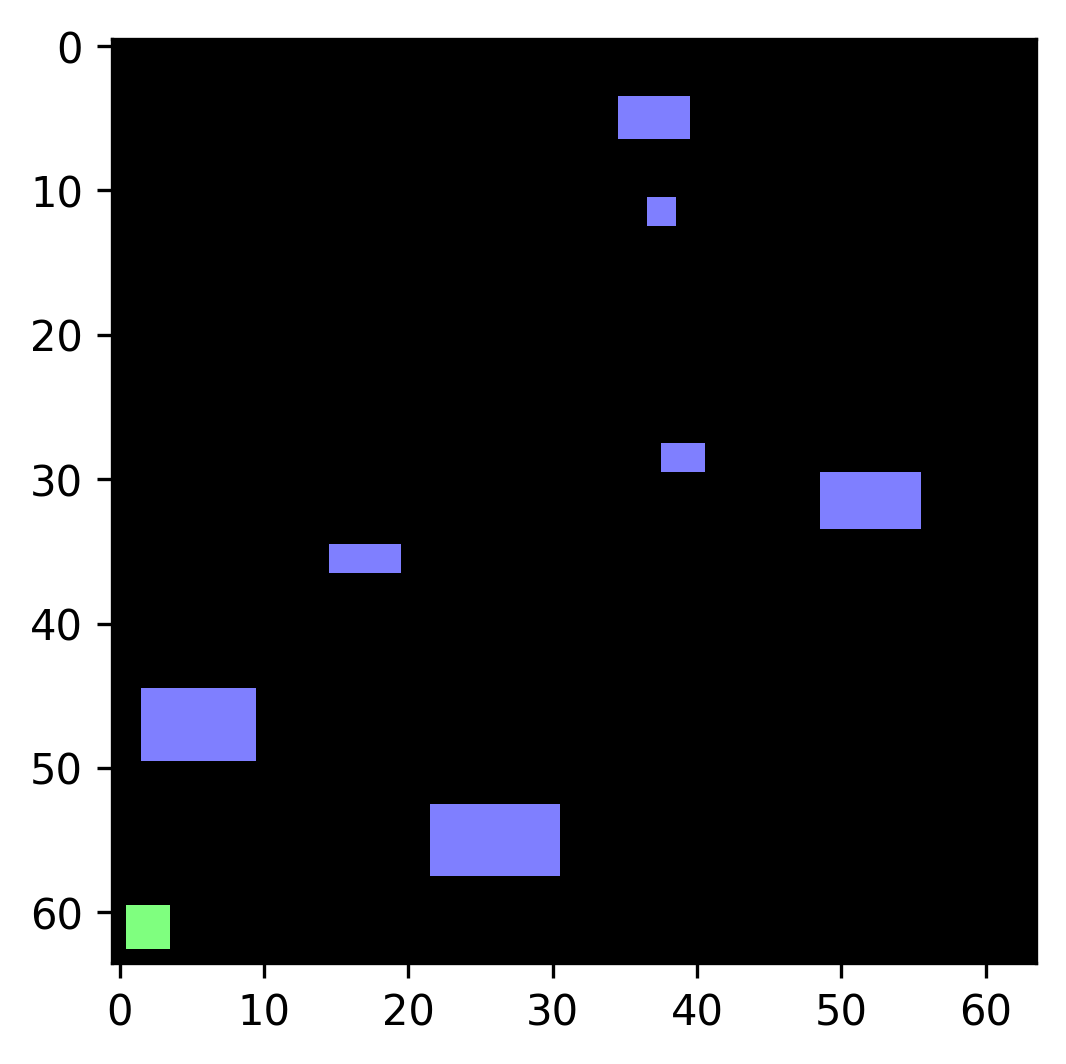

(3, 64, 64)


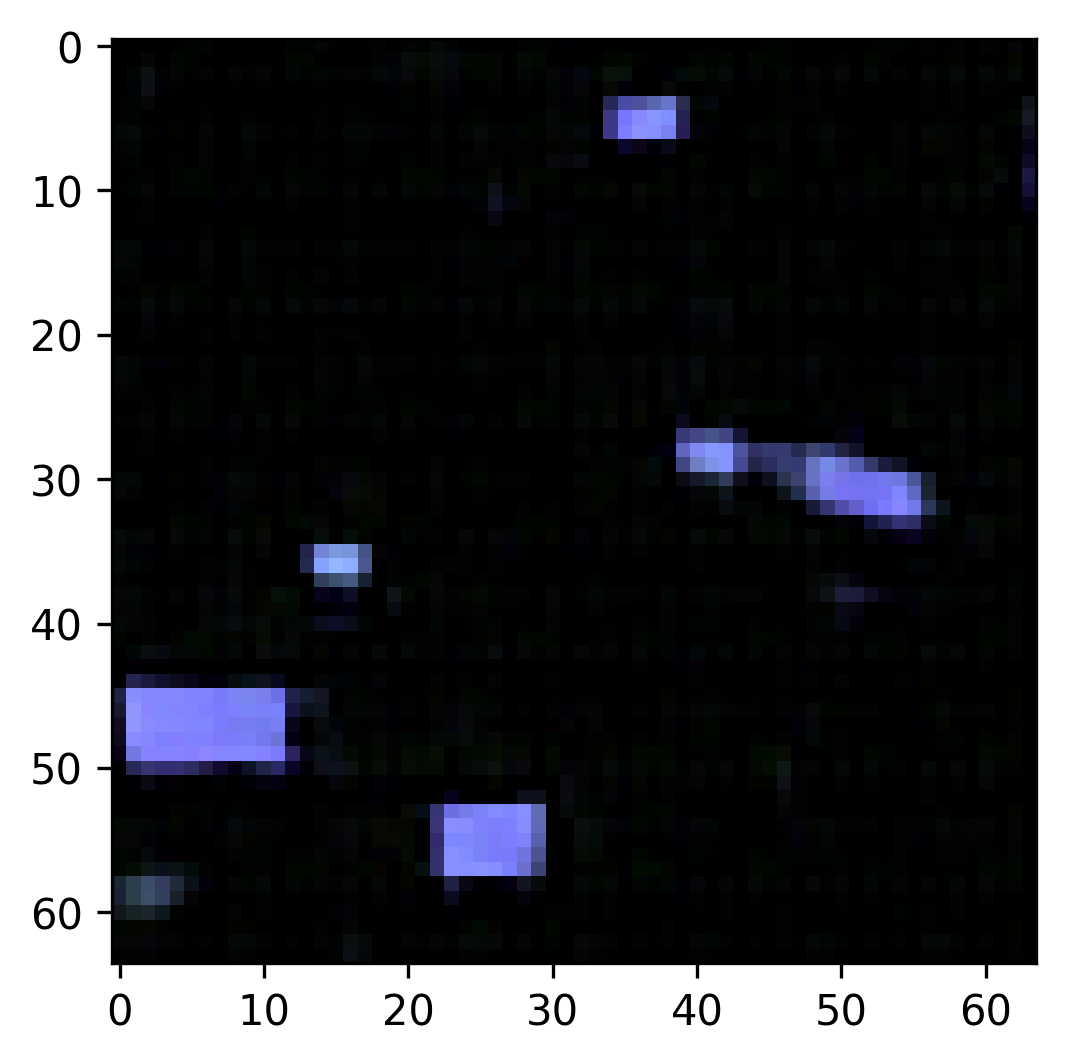

1
repr, std, cov, conv, closs 0.6444924473762512 0.47509765625 4.7174980863928795e-05 0.004719668533653021 0.25182175636291504
19.063373159989336 0.006547212116268346 1.0
repr, std, cov, conv, closs 0.631308913230896 0.475341796875 4.547019489109516e-05 0.004271276295185089 0.2478640079498291
18.723470661268713 0.0064304744466389075 1.0
repr, std, cov, conv, closs 0.6617743372917175 0.47705078125 3.387080505490303e-05 0.005310140550136566 0.24808984994888306
19.332002109375203 0.00663947127195077 1.0
repr, std, cov, conv, closs 0.6671527624130249 0.476318359375 3.681983798742294e-05 0.0046247155405581 0.2524092197418213
19.624020823744583 0.00676000303213283 1.0
repr, std, cov, conv, closs 0.6516828536987305 0.476806640625 3.534834831953049e-05 0.00448906933888793 0.2483869194984436
20.18097597871086 0.006979709864737193 1.0
repr, std, cov, conv, closs 0.6395453214645386 0.476806640625 3.616325557231903e-05 0.004981921054422855 0.25523144006729126
20.140674489058256 0.00709222670912788

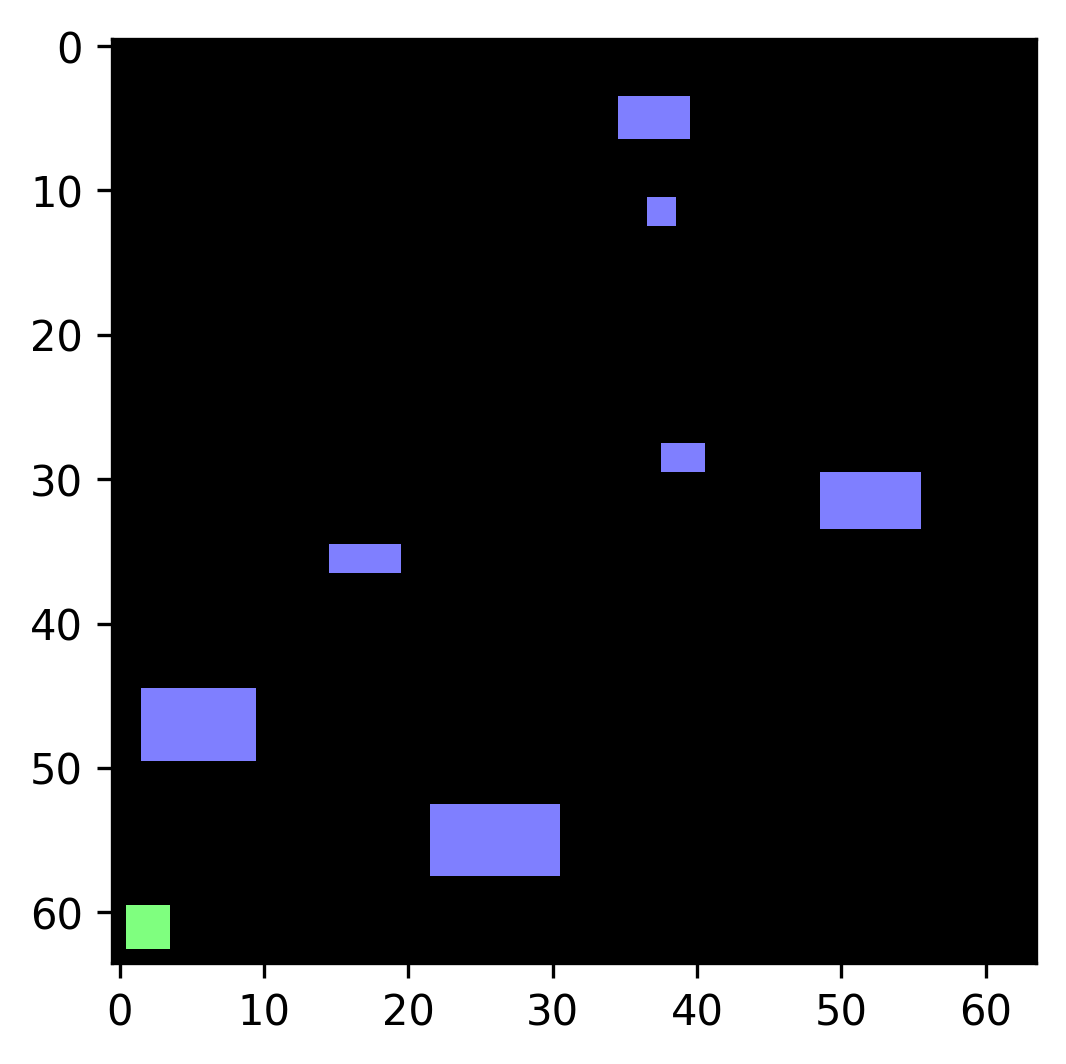

(3, 64, 64)


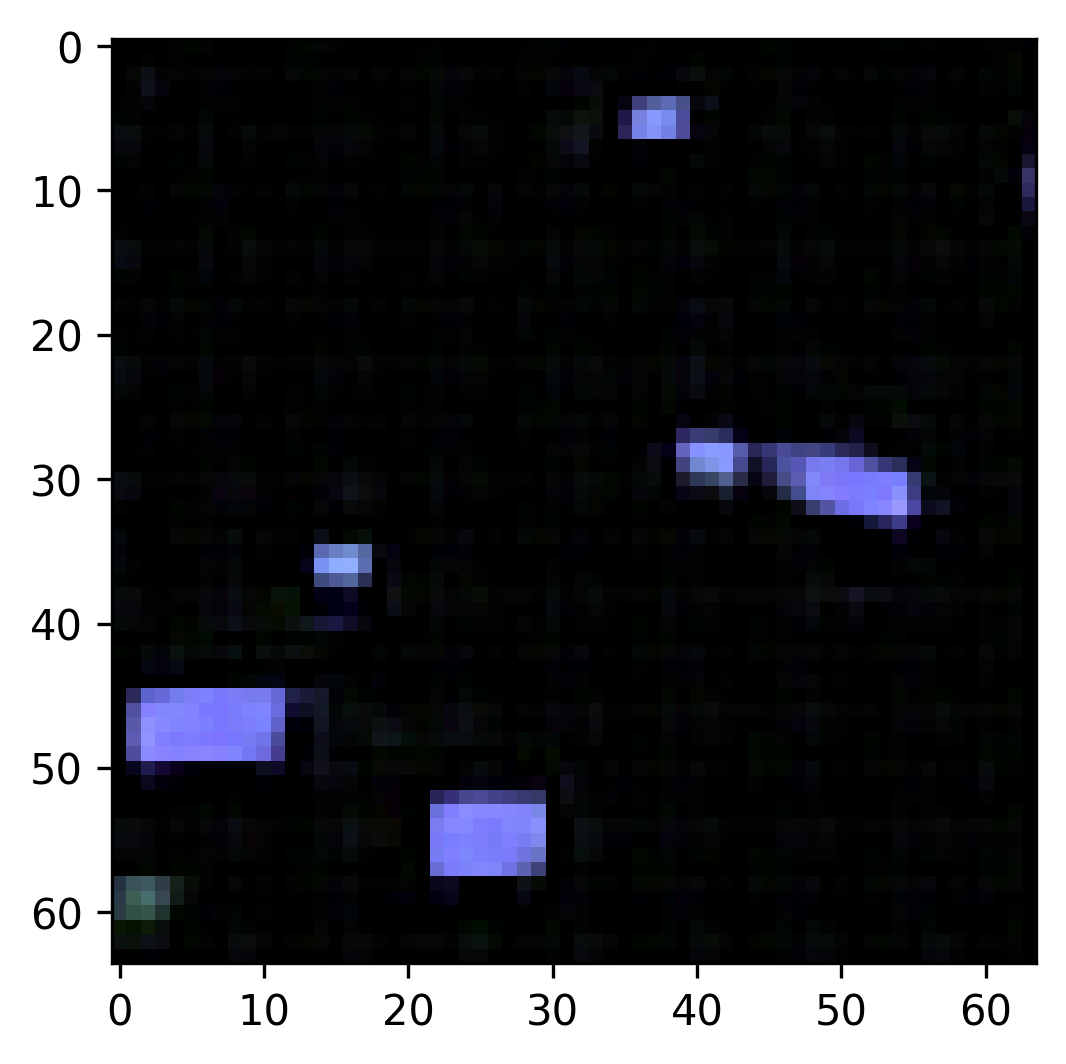

2
repr, std, cov, conv, closs 0.6351145505905151 0.476806640625 3.3952295780181885e-05 0.005014226771891117 0.2500479221343994
21.025161582286604 0.007206557388264859 1.0
repr, std, cov, conv, closs 0.6506981253623962 0.47705078125 3.265100531280041e-05 0.004765640012919903 0.24977707862854004
21.046186743868887 0.00733738392719879 1.0
repr, std, cov, conv, closs 0.6472227573394775 0.47705078125 3.3854274079203606e-05 0.004813624545931816 0.2496490478515625
21.57870394207441 0.0075758562140578675 1.0
repr, std, cov, conv, closs 0.6689772605895996 0.4765625 3.5549281165003777e-05 0.005008998326957226 0.2513160705566406
21.53561118409504 0.007636675612523 1.0
repr, std, cov, conv, closs 0.64735347032547 0.476318359375 3.838050179183483e-05 0.004990683868527412 0.24964356422424316
21.364098999441314 0.007545628396511387 1.0
repr, std, cov, conv, closs 0.6656537055969238 0.475830078125 4.213838838040829e-05 0.0045754630118608475 0.24964356422424316
21.19395275835117 0.007411088830776266 1.

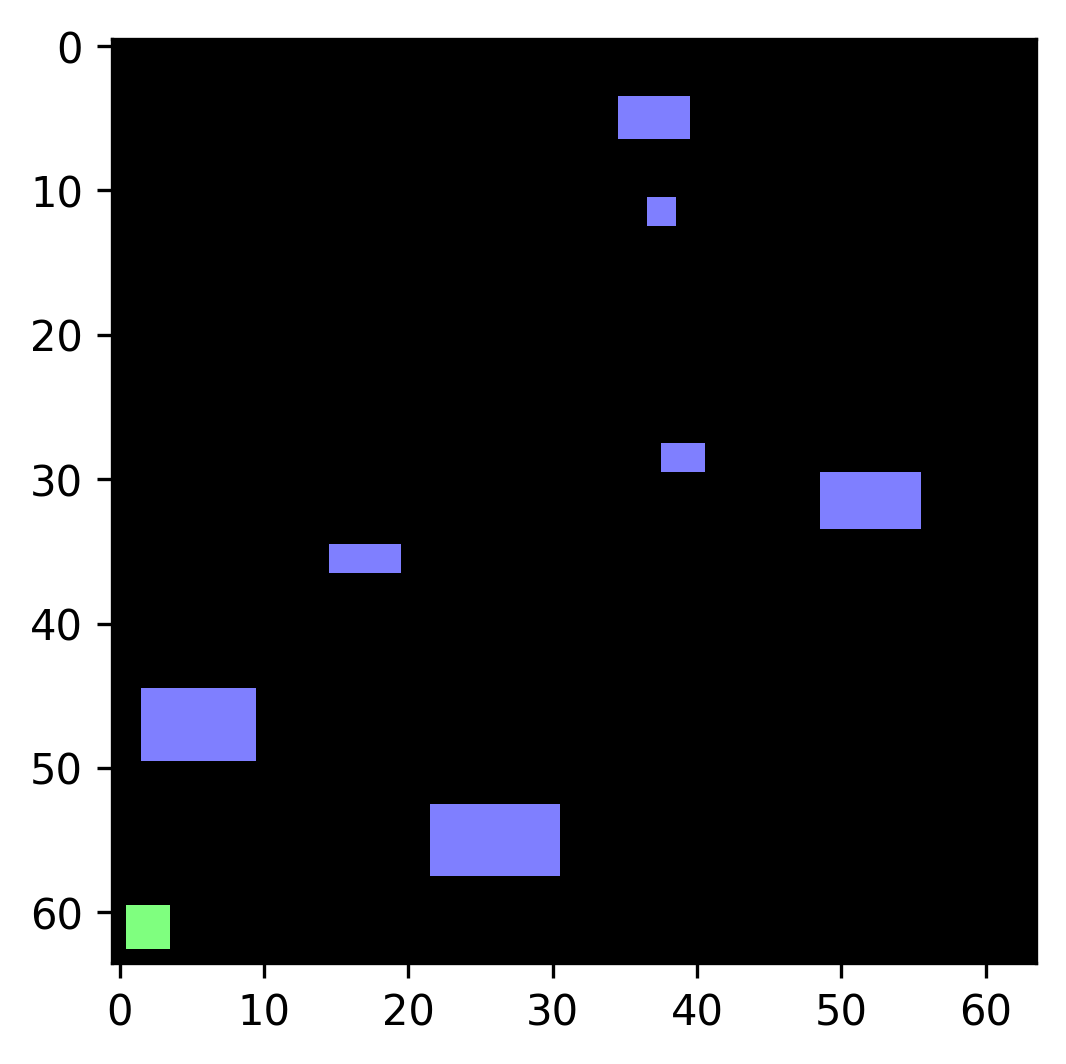

(3, 64, 64)


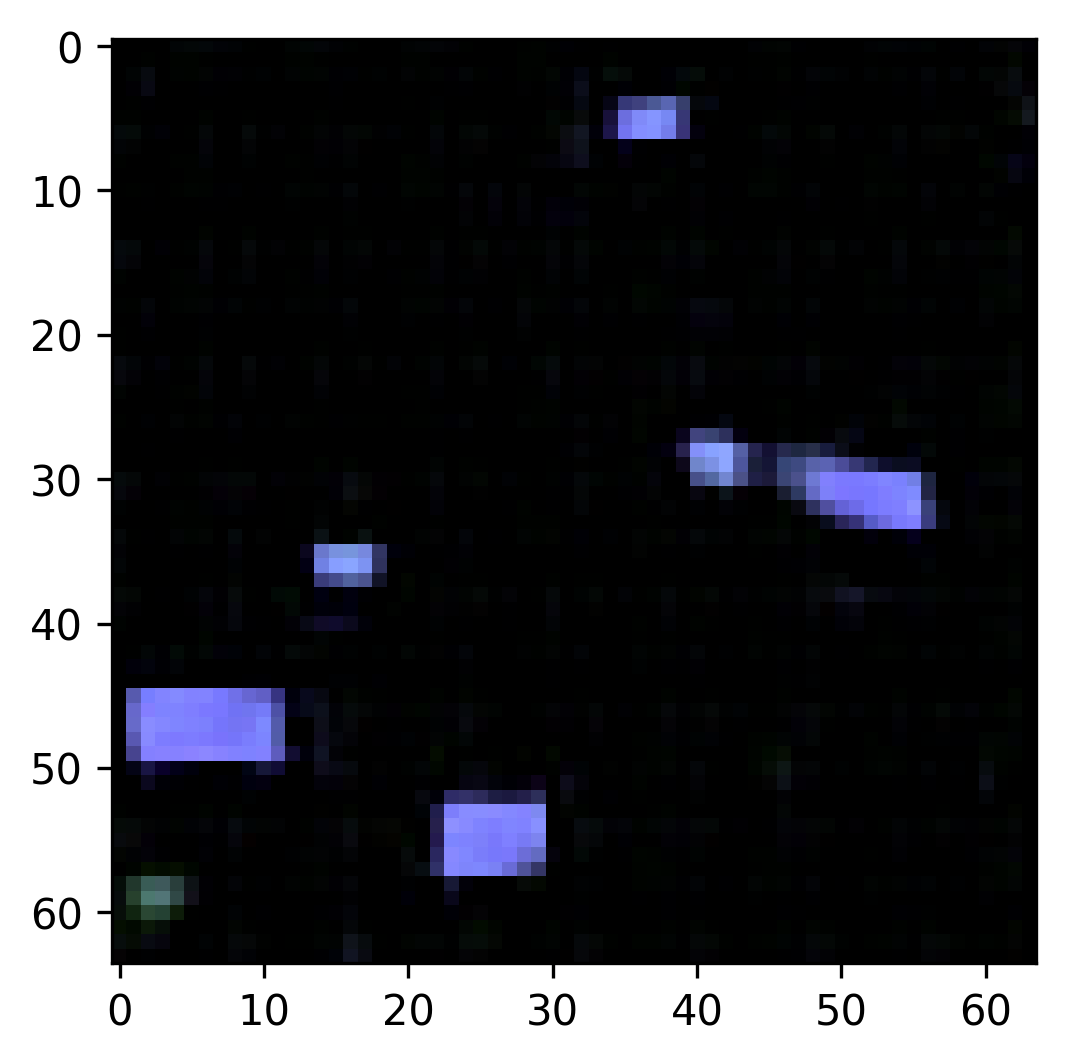

3
repr, std, cov, conv, closs 0.6291595697402954 0.4755859375 4.532677121460438e-05 0.004024541936814785 0.24752575159072876
20.941270767804763 0.00730810761883799 1.0
repr, std, cov, conv, closs 0.6421450972557068 0.474609375 5.396758206188679e-05 0.004007901065051556 0.25352102518081665
20.567885103021084 0.007177803080406364 1.0
repr, std, cov, conv, closs 0.6579477190971375 0.475341796875 4.703574813902378e-05 0.004406315740197897 0.24911880493164062
20.18097597871086 0.006951860683026597 1.0
repr, std, cov, conv, closs 0.677713930606842 0.475830078125 4.17809933423996e-05 0.004976081196218729 0.2497730851173401
20.26182104922565 0.006855260702280024 1.0
repr, std, cov, conv, closs 0.6181921362876892 0.47509765625 4.881061613559723e-05 0.004635983146727085 0.25145554542541504
19.72233736440988 0.00663947127195077 1.0
repr, std, cov, conv, closs 0.6636427640914917 0.4755859375 4.356051795184612e-05 0.0051628053188323975 0.24975591897964478
19.821146471927566 0.006612979649018274 1.0

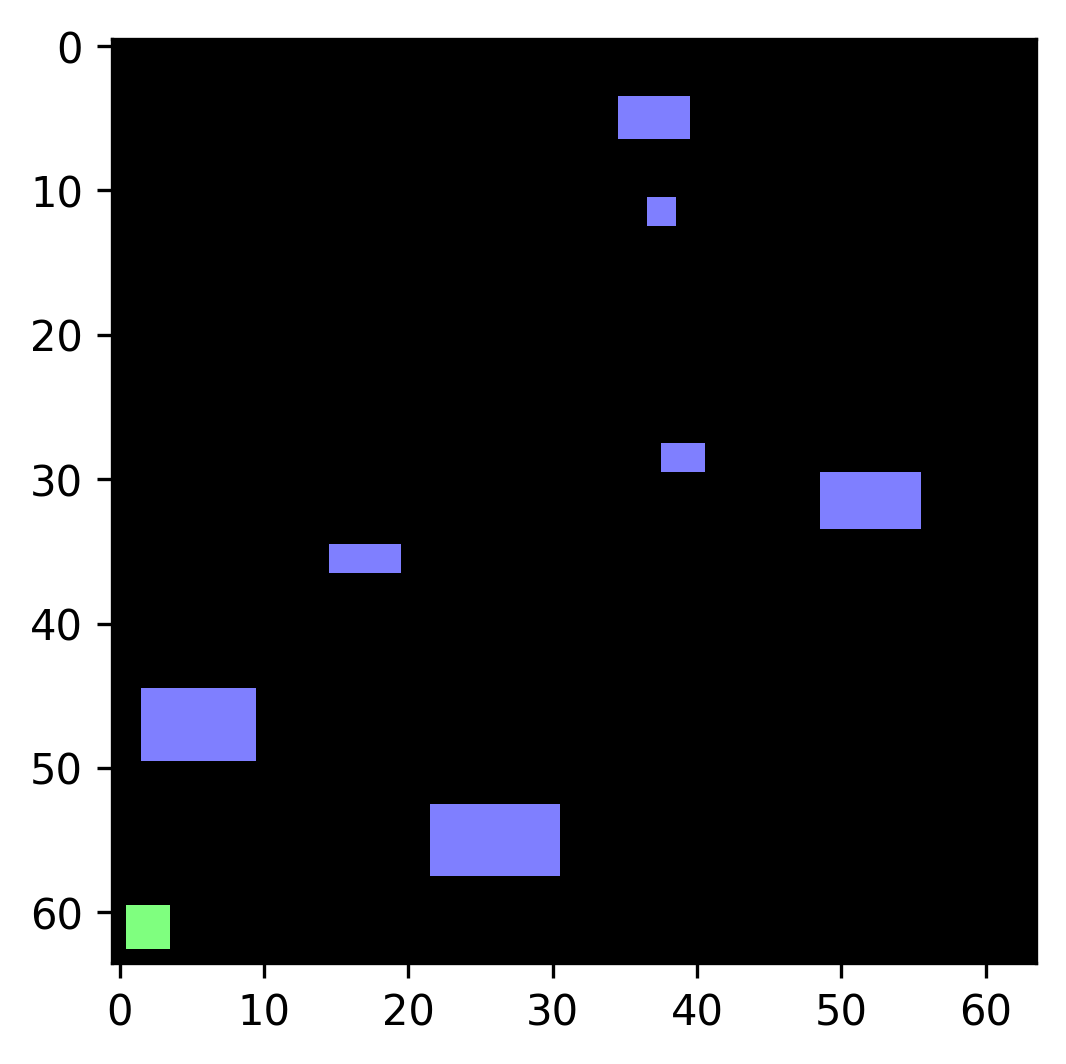

(3, 64, 64)


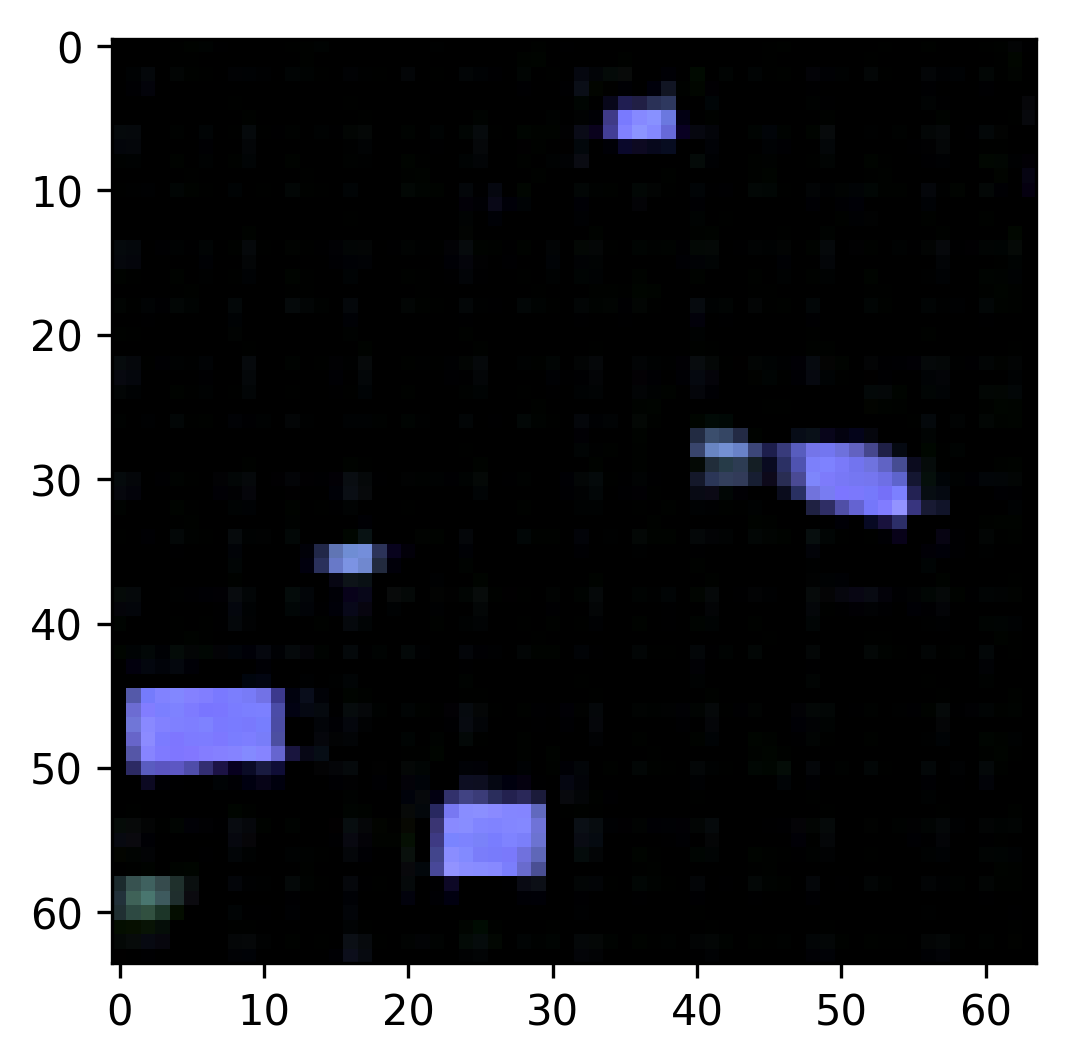

4
repr, std, cov, conv, closs 0.6594473719596863 0.476806640625 3.4248922020196915e-05 0.00426400126889348 0.2511301040649414
21.236361857820626 0.006706165559010024 1.0
repr, std, cov, conv, closs 0.6700153946876526 0.476806640625 3.5797012969851494e-05 0.004822677932679653 0.25115257501602173
21.60028264601648 0.0068279080752122676 1.0
repr, std, cov, conv, closs 0.6643860340118408 0.476806640625 3.4207478165626526e-05 0.004627998918294907 0.25020748376846313
22.30231334939887 0.007049821889361154 1.0
repr, std, cov, conv, closs 0.6568820476531982 0.4765625 3.5886187106370926e-05 0.004281552042812109 0.249758780002594
22.616583387216604 0.007177803080406364 1.0
repr, std, cov, conv, closs 0.6277773380279541 0.47705078125 3.355741500854492e-05 0.004163078963756561 0.25017380714416504
23.07323809863839 0.007411088830776266 1.0
repr, std, cov, conv, closs 0.6570587158203125 0.4765625 3.6048004403710365e-05 0.004209239035844803 0.25054413080215454
22.95821720076558 0.007493019643079232 1

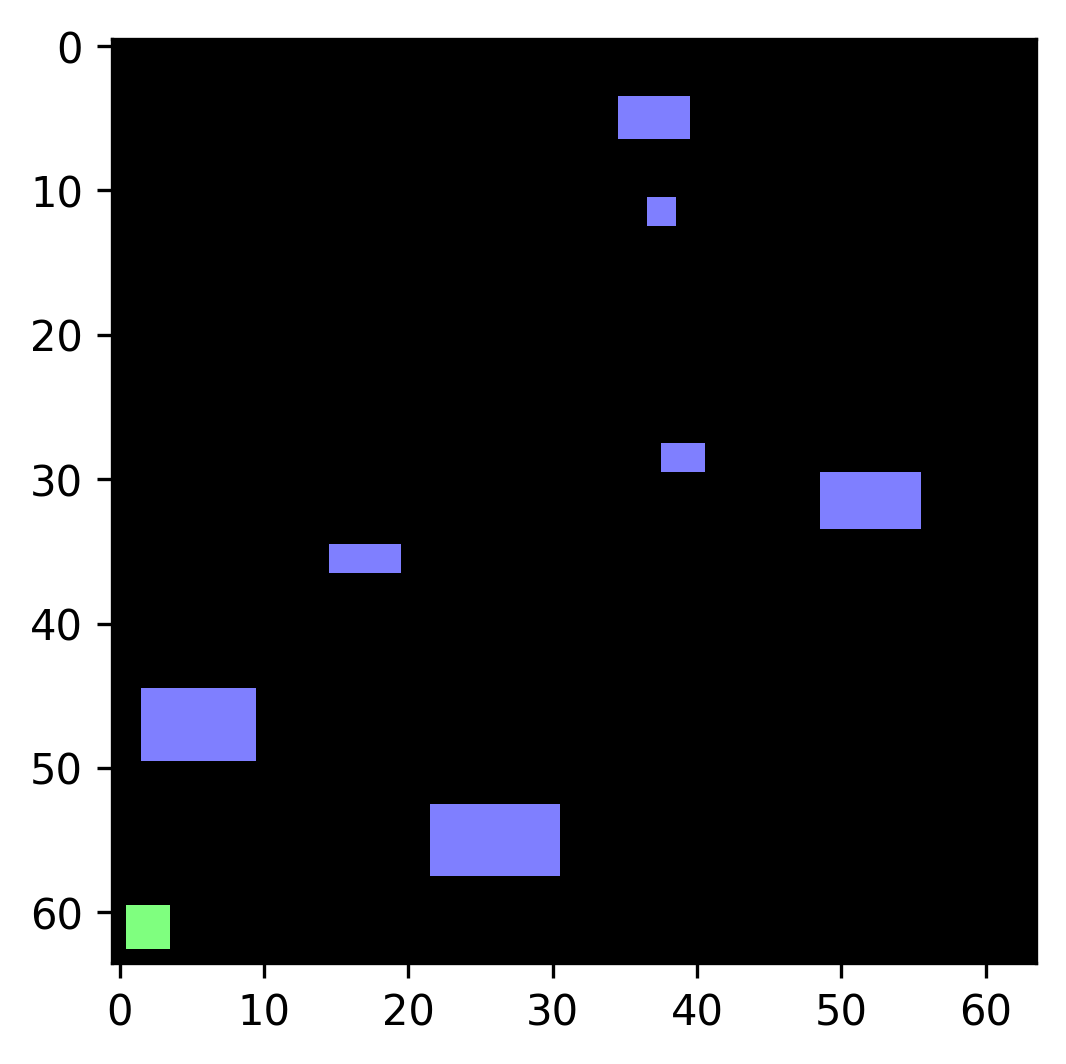

(3, 64, 64)


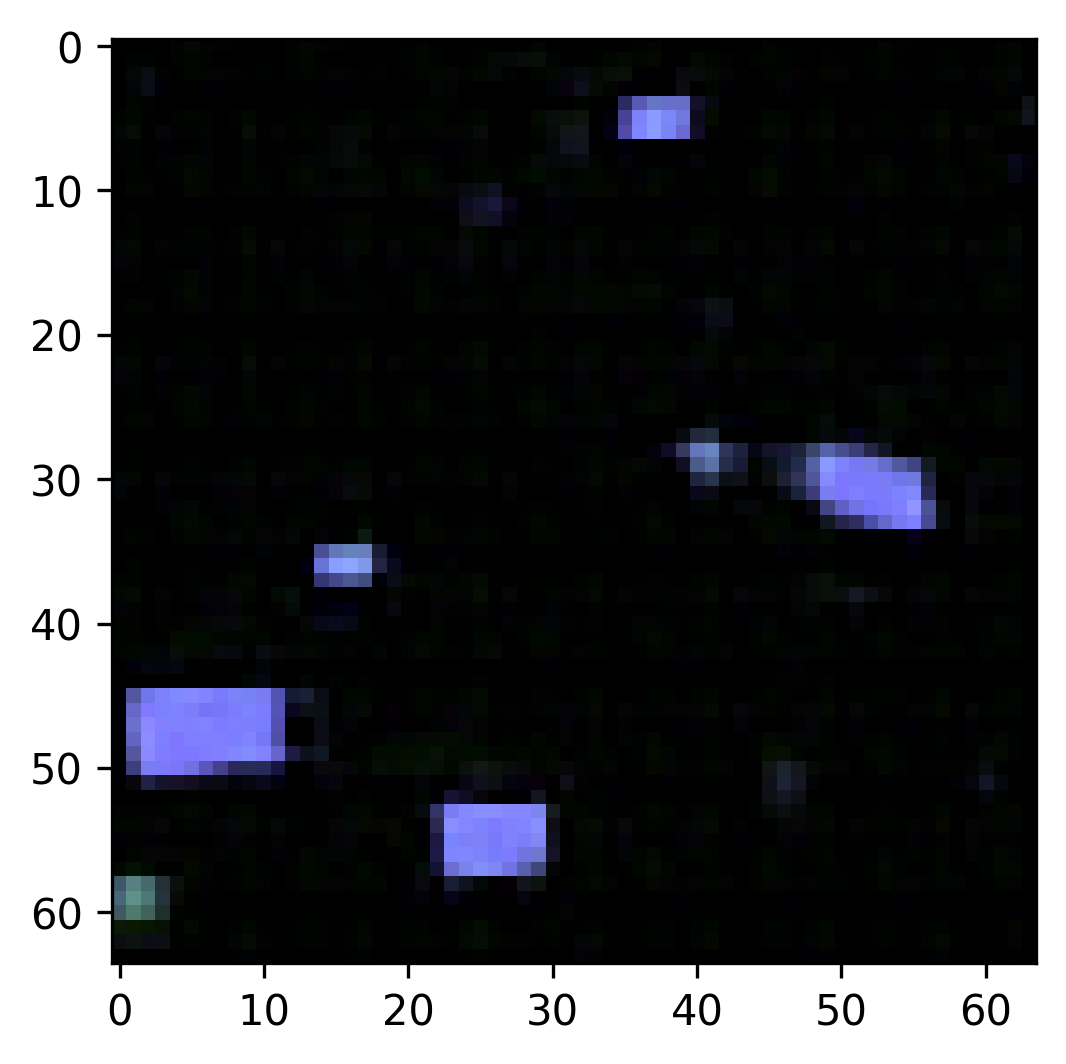

5
repr, std, cov, conv, closs 0.6677321791648865 0.47607421875 3.999914042651653e-05 0.004706347361207008 0.2502768039703369
24.54829600589054 0.007366777516568017 1.0
repr, std, cov, conv, closs 0.6566113233566284 0.475830078125 4.231114871799946e-05 0.004461025819182396 0.24995636940002441
24.183000743314924 0.007249904975194557 1.0
repr, std, cov, conv, closs 0.6499879956245422 0.476318359375 3.962218761444092e-05 0.004421137273311615 0.2500936985015869
23.65704438408794 0.007134886594734244 1.0
repr, std, cov, conv, closs 0.6593638062477112 0.47607421875 3.963685594499111e-05 0.004242186434566975 0.24972748756408691
23.398371518487508 0.0070287146522317896 1.0
repr, std, cov, conv, closs 0.6440913677215576 0.475830078125 4.2250845581293106e-05 0.004888583905994892 0.24977707862854004
23.096311336737028 0.006841570719270765 1.0
repr, std, cov, conv, closs 0.6539906859397888 0.475830078125 4.229671321809292e-05 0.004304224159568548 0.2498931884765625
22.91236954929744 0.0067195845962

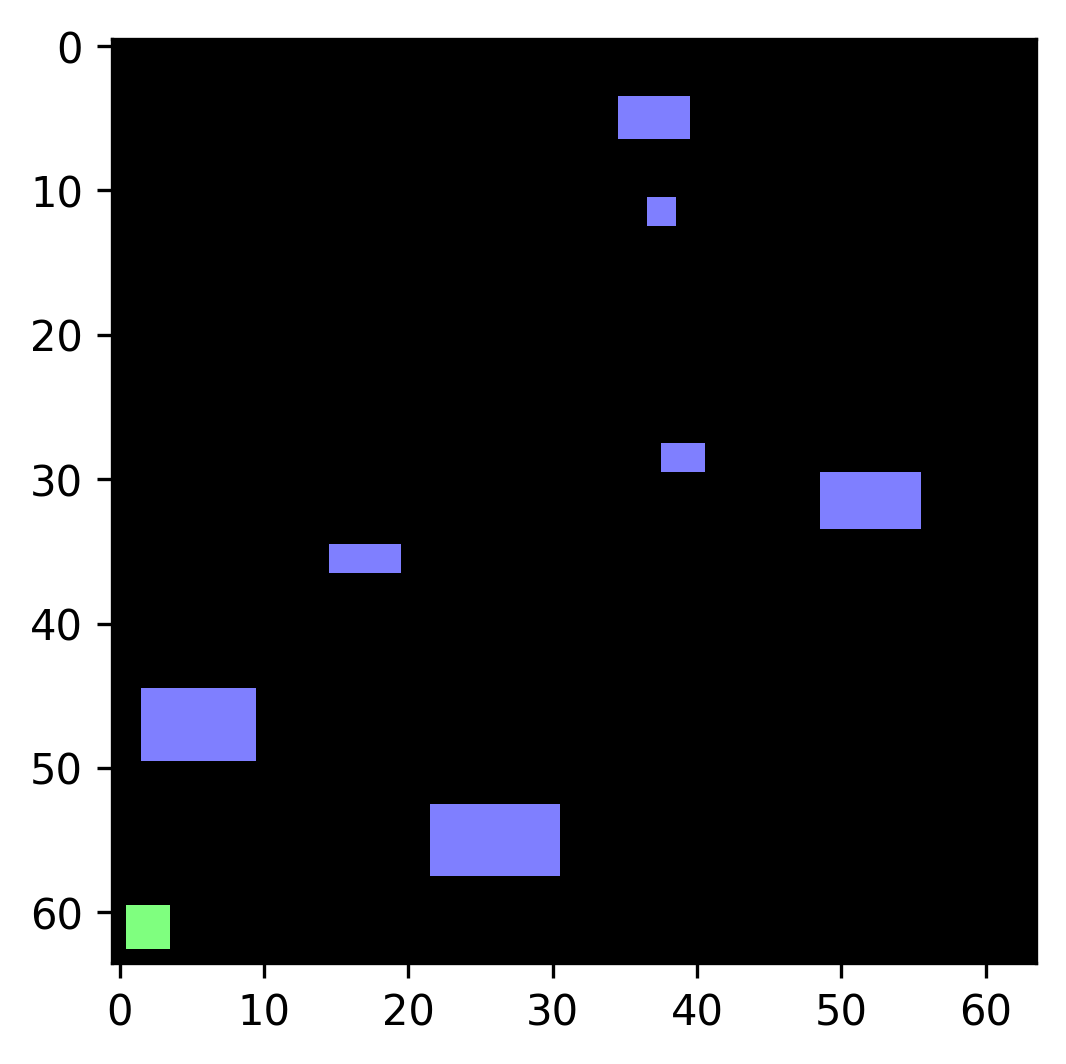

(3, 64, 64)


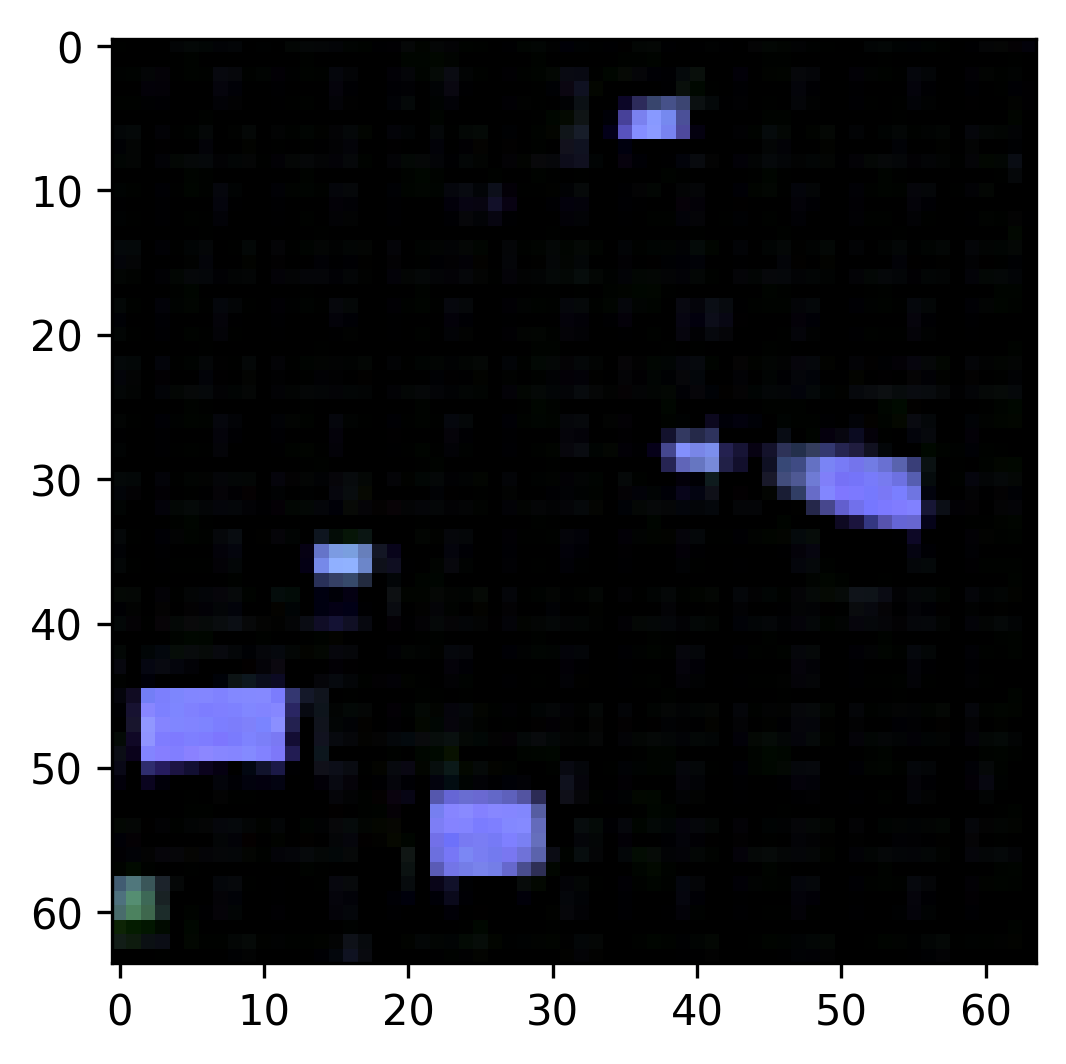

6
repr, std, cov, conv, closs 0.639610230922699 0.47607421875 3.912602551281452e-05 0.004825931042432785 0.2504005432128906
23.25847134781199 0.0063792613786059224 1.0
repr, std, cov, conv, closs 0.6906326413154602 0.476806640625 3.45099251717329e-05 0.004783470183610916 0.24985337257385254
23.562652304681226 0.006495069335464343 1.0
repr, std, cov, conv, closs 0.6199191808700562 0.476318359375 4.0478305891156197e-05 0.004017956089228392 0.250007688999176
23.728086512030387 0.0066594096108199075 1.0
repr, std, cov, conv, closs 0.6625039577484131 0.476806640625 3.390014171600342e-05 0.004082552623003721 0.24970078468322754
23.823141321533644 0.006780303327998326 1.0
repr, std, cov, conv, closs 0.6541030406951904 0.477783203125 2.8040027245879173e-05 0.004531879909336567 0.2511478066444397
24.474798162533663 0.007000669940440706 1.0
repr, std, cov, conv, closs 0.6573197841644287 0.477783203125 2.803071402013302e-05 0.004200486000627279 0.24946504831314087
24.54829600589054 0.007127758835

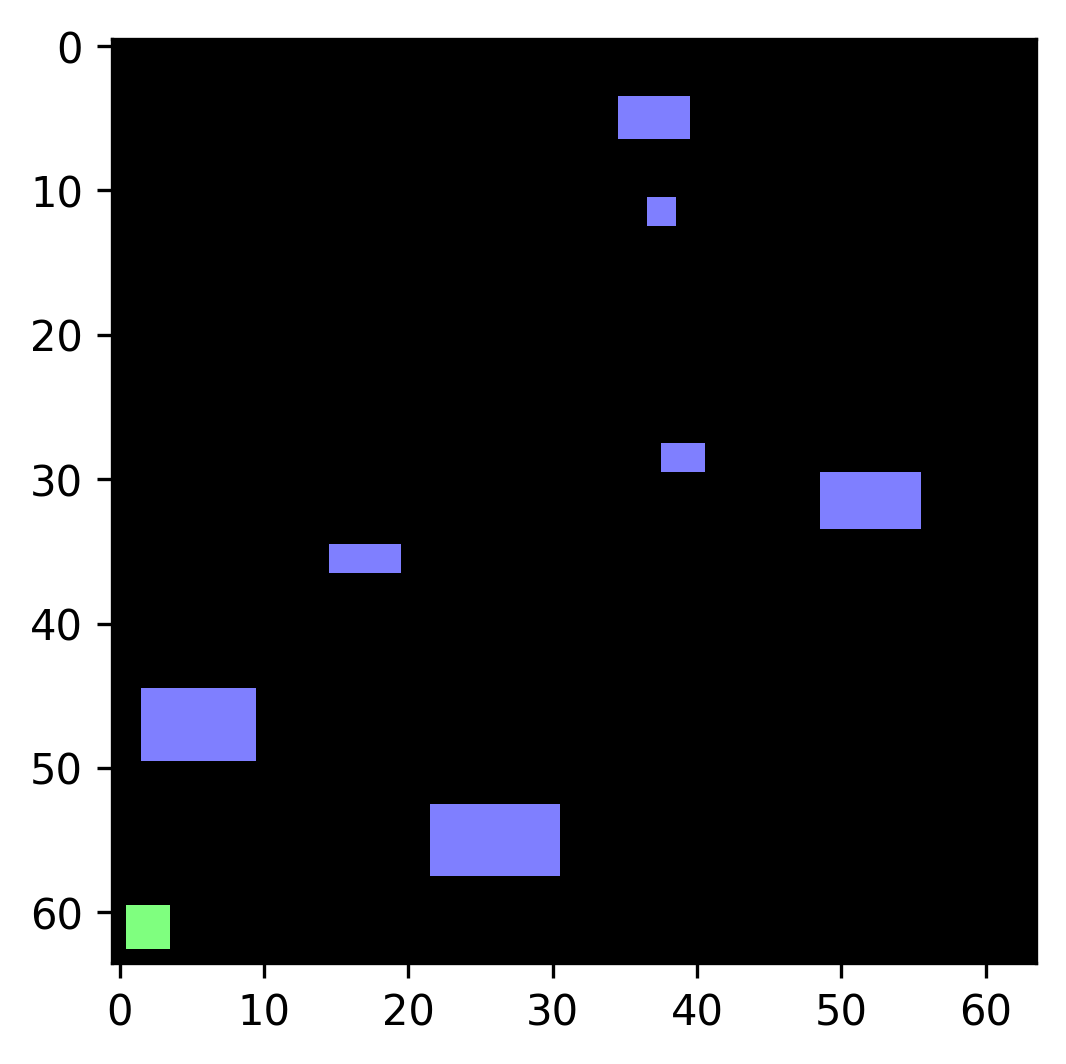

(3, 64, 64)


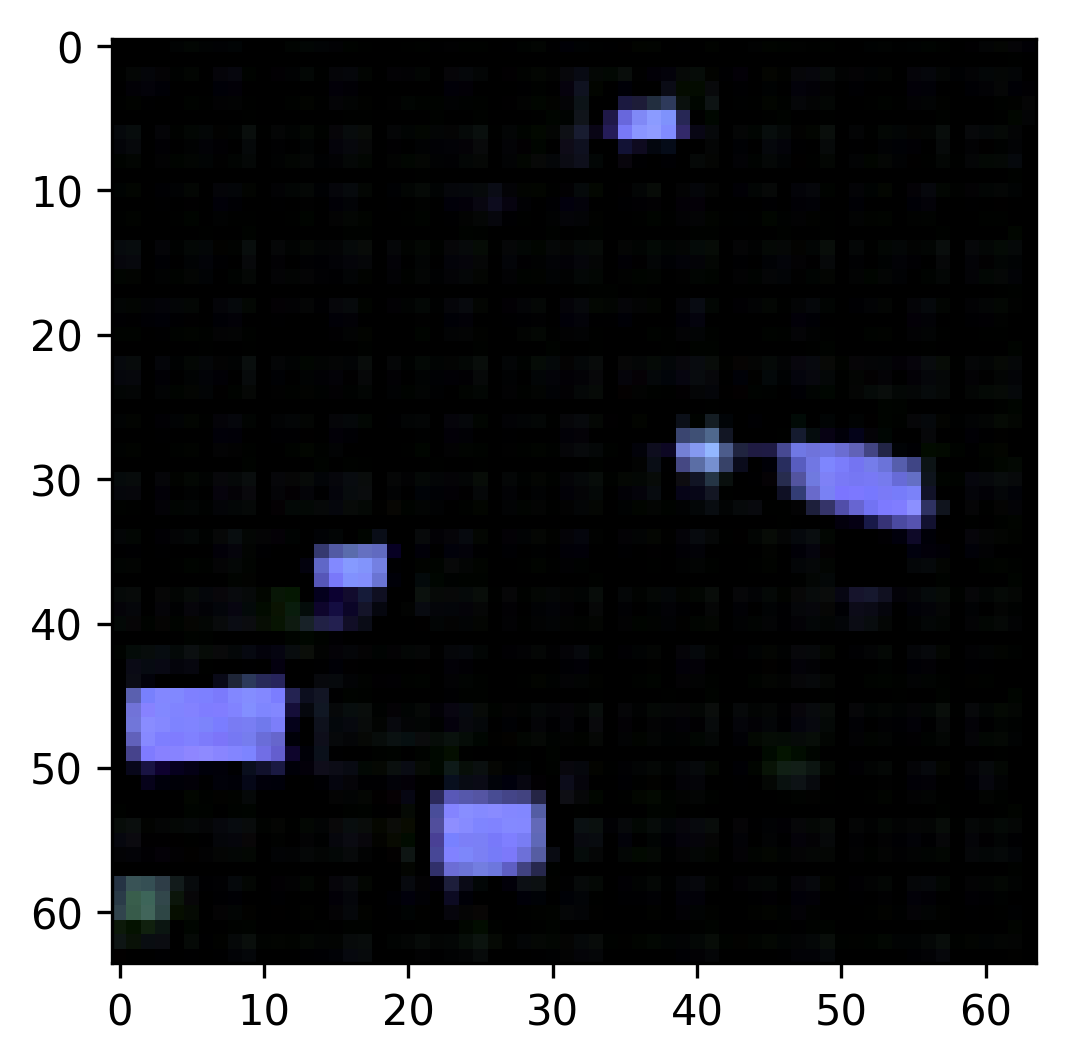

7
repr, std, cov, conv, closs 0.6379034519195557 0.474853515625 4.969770088791847e-05 0.00557634886354208 0.24475955963134766
25.677624167288176 0.0073815184383786685 1.0
repr, std, cov, conv, closs 0.6492231488227844 0.474853515625 4.964414983987808e-05 0.005606729071587324 0.251201868057251
25.219788686525067 0.007249904975194557 1.0
repr, std, cov, conv, closs 0.641161322593689 0.474609375 5.003507249057293e-05 0.005219424143433571 0.24903202056884766
24.54829600589054 0.007021692959272518 1.0
repr, std, cov, conv, closs 0.6505649089813232 0.475341796875 4.545203410089016e-05 0.005550785921514034 0.24369144439697266
24.183000743314924 0.0069033917278449285 1.0
repr, std, cov, conv, closs 0.6416383981704712 0.475341796875 4.3918611481785774e-05 0.005285022314637899 0.2512359619140625
24.328461976808857 0.006841570719270765 1.0
repr, std, cov, conv, closs 0.6451468467712402 0.4755859375 4.462944343686104e-05 0.004610100761055946 0.2501566410064697
24.255622318730094 0.0068210869882240

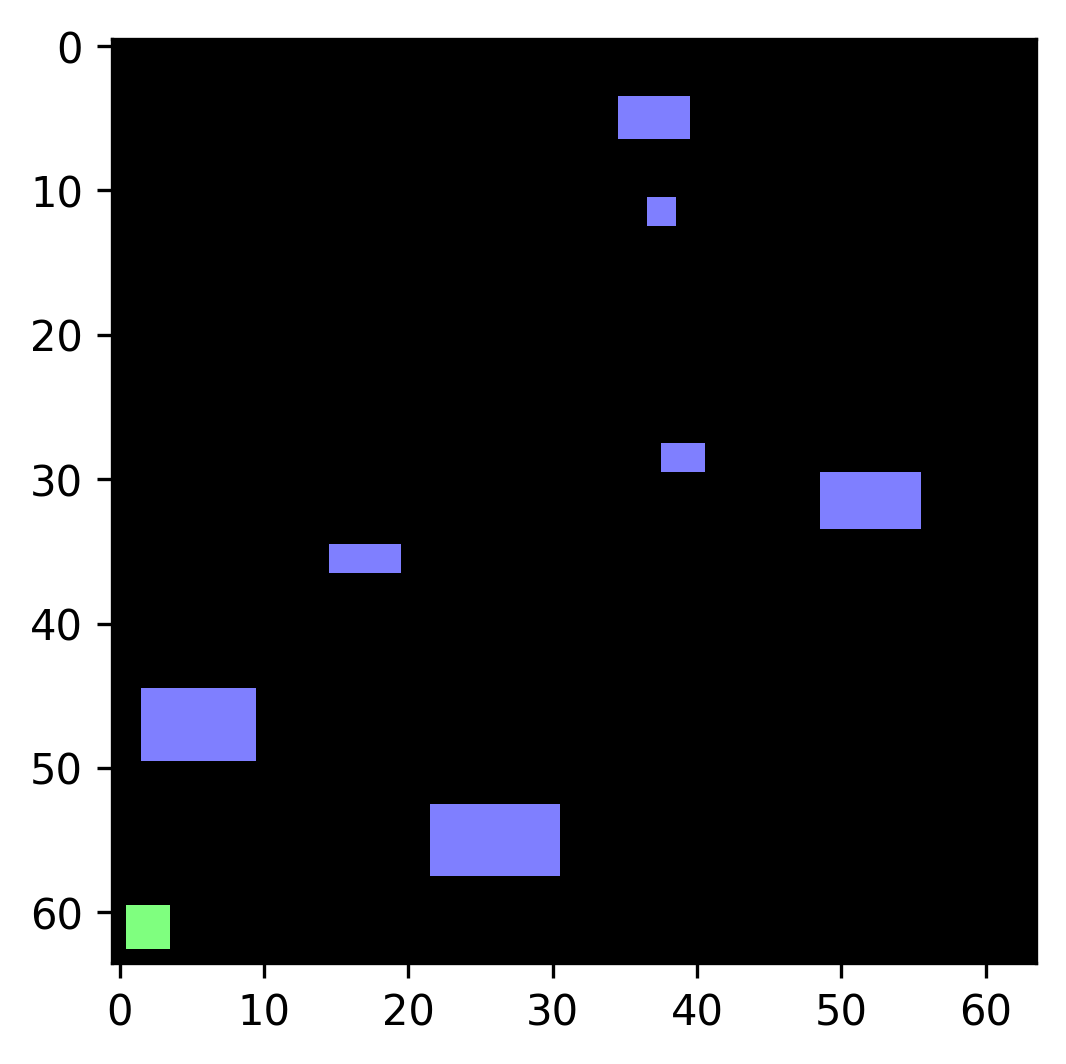

(3, 64, 64)


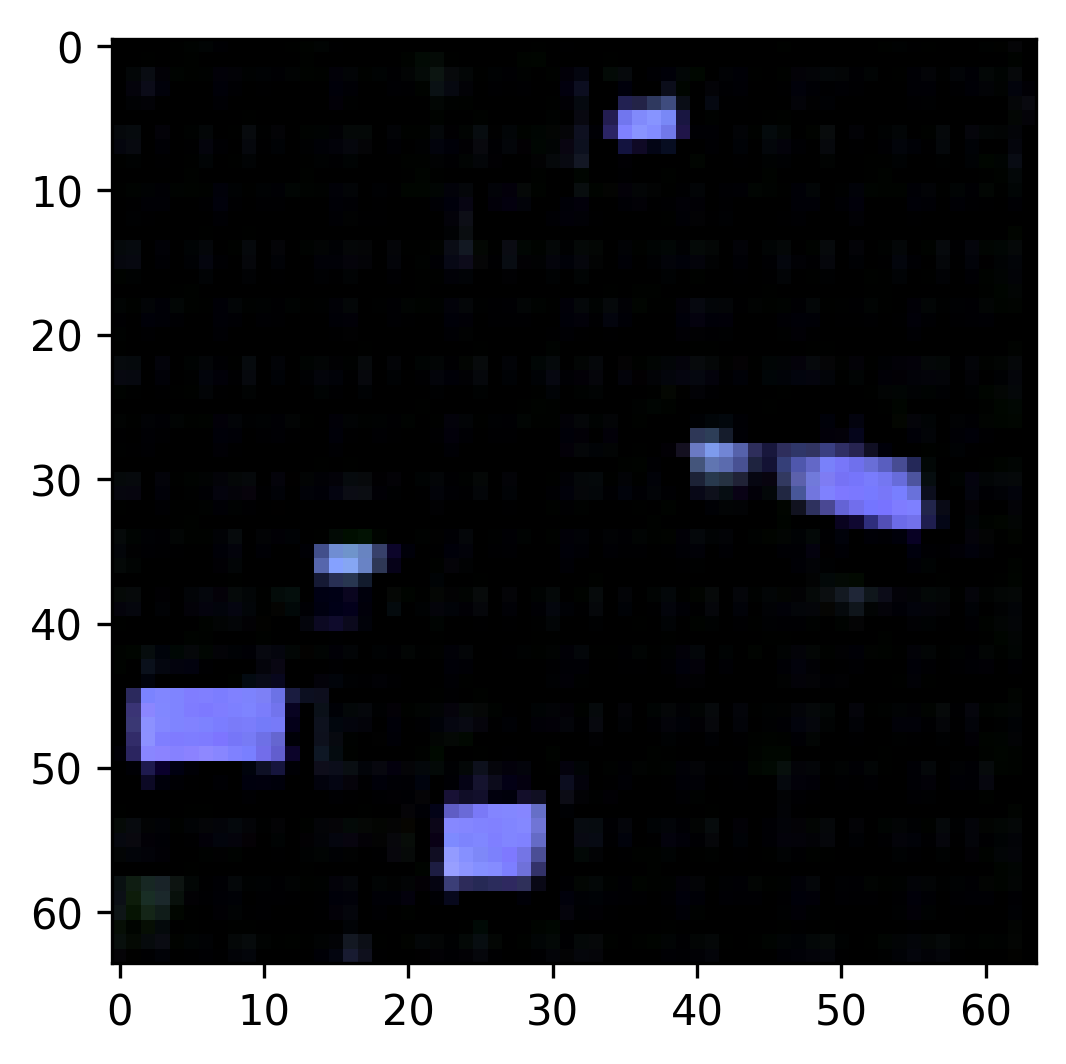

8
repr, std, cov, conv, closs 0.6701686978340149 0.4765625 3.616511821746826e-05 0.004324295092374086 0.24885708093643188
25.219788686525067 0.007014678280991527 1.0
repr, std, cov, conv, closs 0.6571741104125977 0.476806640625 3.342493437230587e-05 0.004066826775670052 0.2540435791015625
25.677624167288176 0.007142021481328977 1.0
repr, std, cov, conv, closs 0.6320788860321045 0.4765625 3.5528792068362236e-05 0.00418830756098032 0.24979931116104126
26.196084796524406 0.007374144294084585 1.0
repr, std, cov, conv, closs 0.6520142555236816 0.47705078125 3.290502354502678e-05 0.004764288663864136 0.2505960464477539
26.51217253180572 0.007508013175385033 1.0
repr, std, cov, conv, closs 0.6556210517883301 0.4765625 3.838422708213329e-05 0.0050630951300263405 0.24575138092041016
27.155835975673764 0.007667268165581103 1.0
repr, std, cov, conv, closs 0.6539117693901062 0.475830078125 4.286668263375759e-05 0.004249250516295433 0.2399492859840393
26.858906325648352 0.007530559746458725 1.0
rep

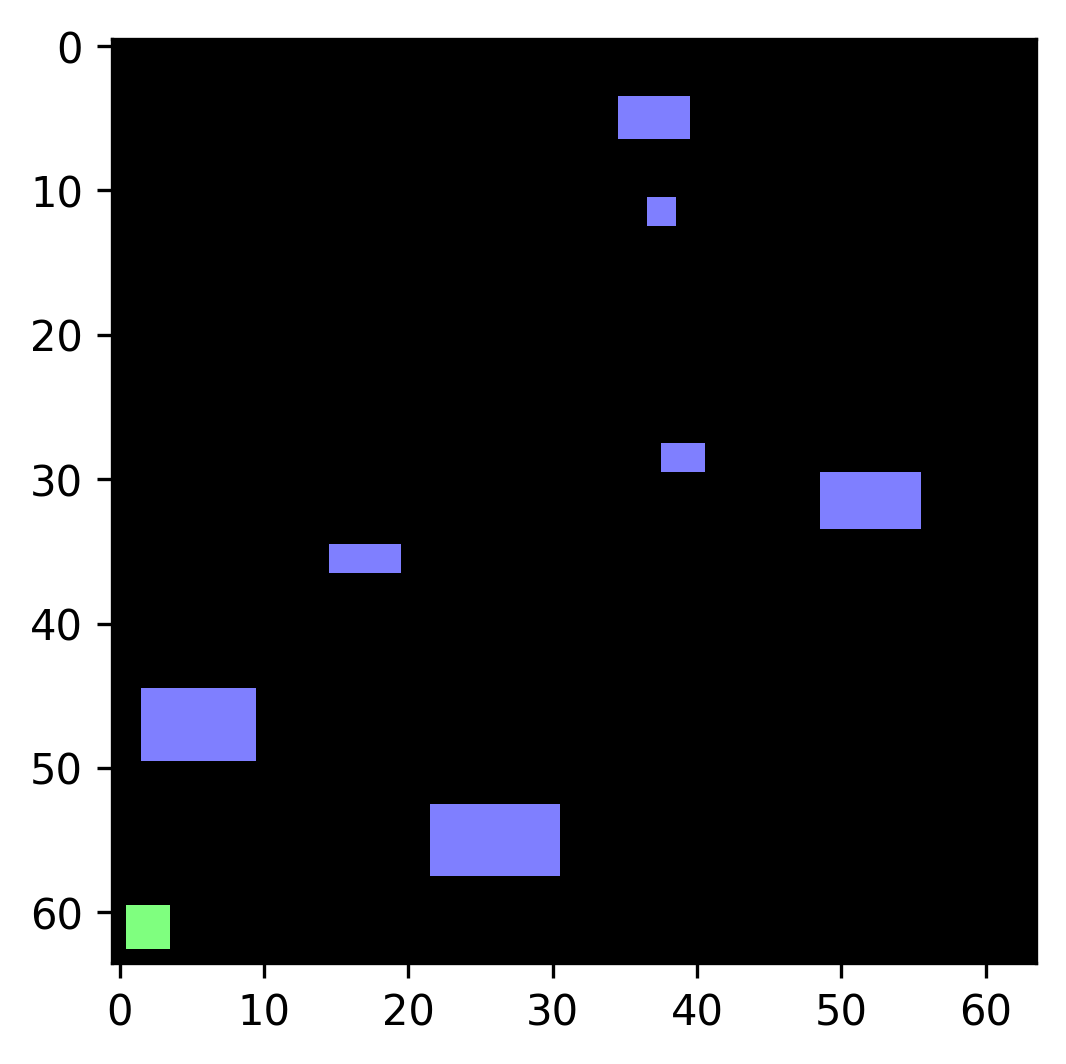

(3, 64, 64)


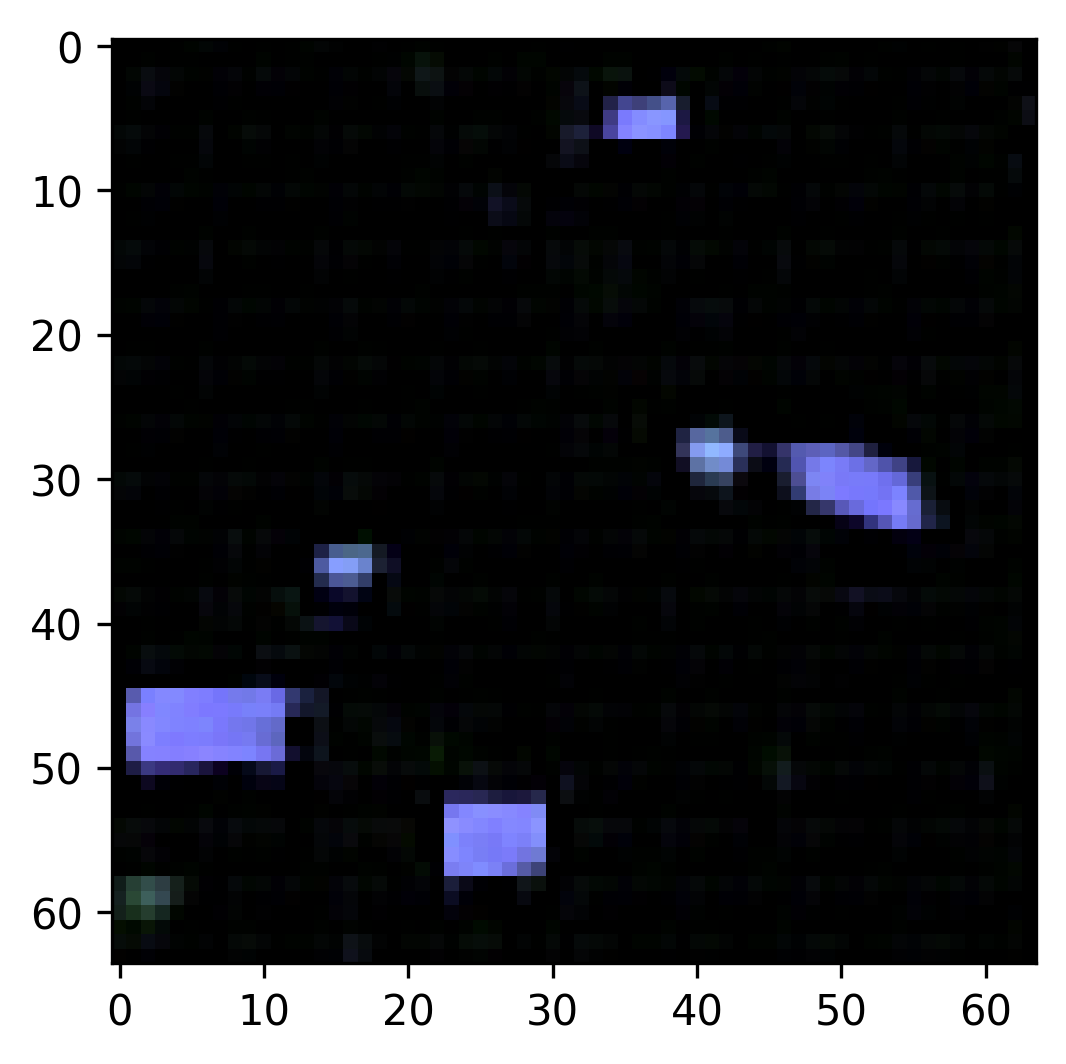

9
repr, std, cov, conv, closs 0.6342381238937378 0.47607421875 3.949133679270744e-05 0.004558290354907513 0.25202012062072754
26.248503162202244 0.007085141567560325 1.0
repr, std, cov, conv, closs 0.6471624374389648 0.475830078125 4.055607132613659e-05 0.00511926831677556 0.2508583068847656
26.327327443446833 0.007007670610381146 1.0
repr, std, cov, conv, closs 0.6425378322601318 0.475830078125 4.0531158447265625e-05 0.004581013694405556 0.2524282932281494
26.327327443446833 0.0068006645856726064 1.0
repr, std, cov, conv, closs 0.6421197056770325 0.475830078125 4.008878022432327e-05 0.004720453638583422 0.2497560977935791
26.353654770890277 0.0066994660929171074 1.0
repr, std, cov, conv, closs 0.6547983288764954 0.475830078125 4.084547981619835e-05 0.005095712840557098 0.24976181983947754
26.618380401043325 0.0066195926286672915 1.0
repr, std, cov, conv, closs 0.6749531030654907 0.475830078125 4.100799560546875e-05 0.005042633973062038 0.2505035400390625
26.832074251396957 0.006560313

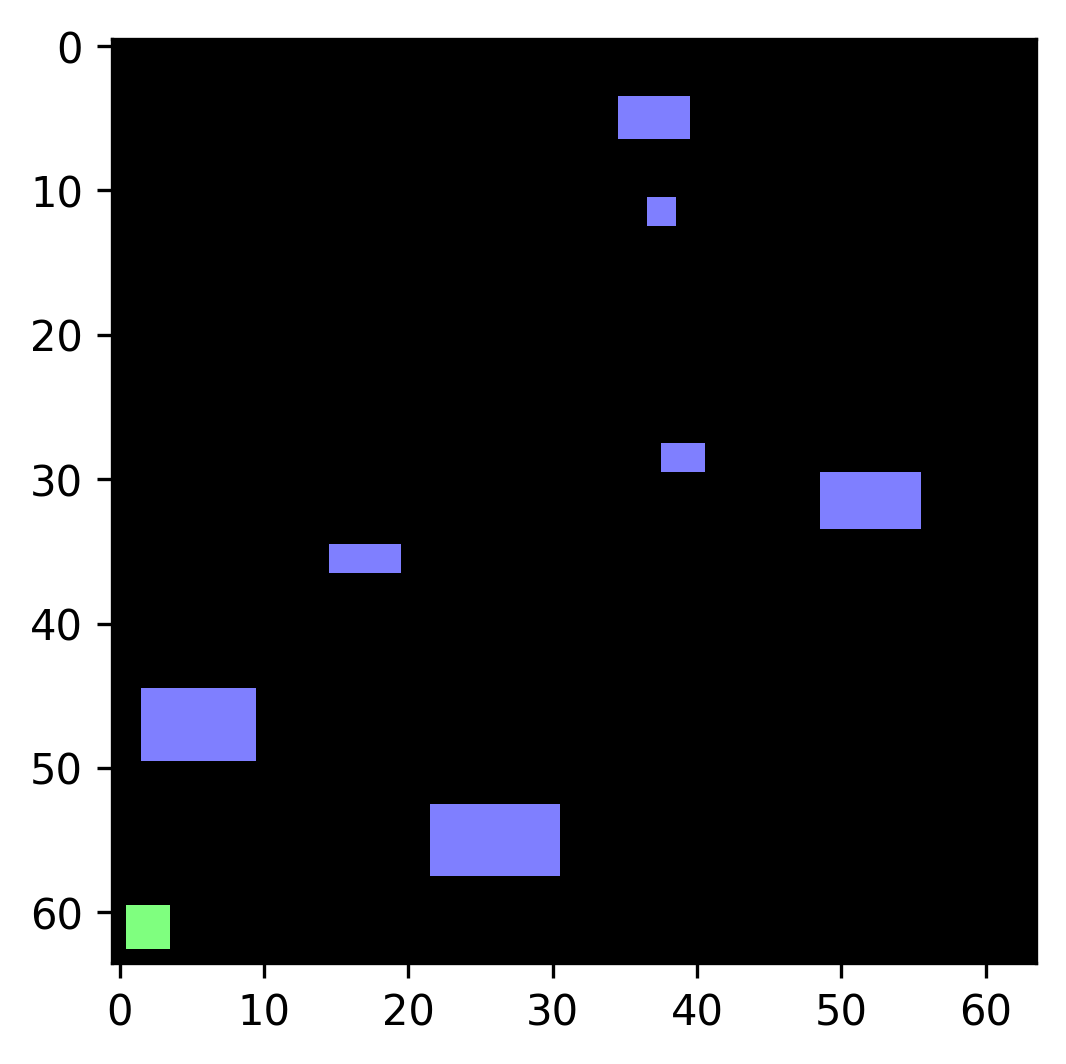

(3, 64, 64)


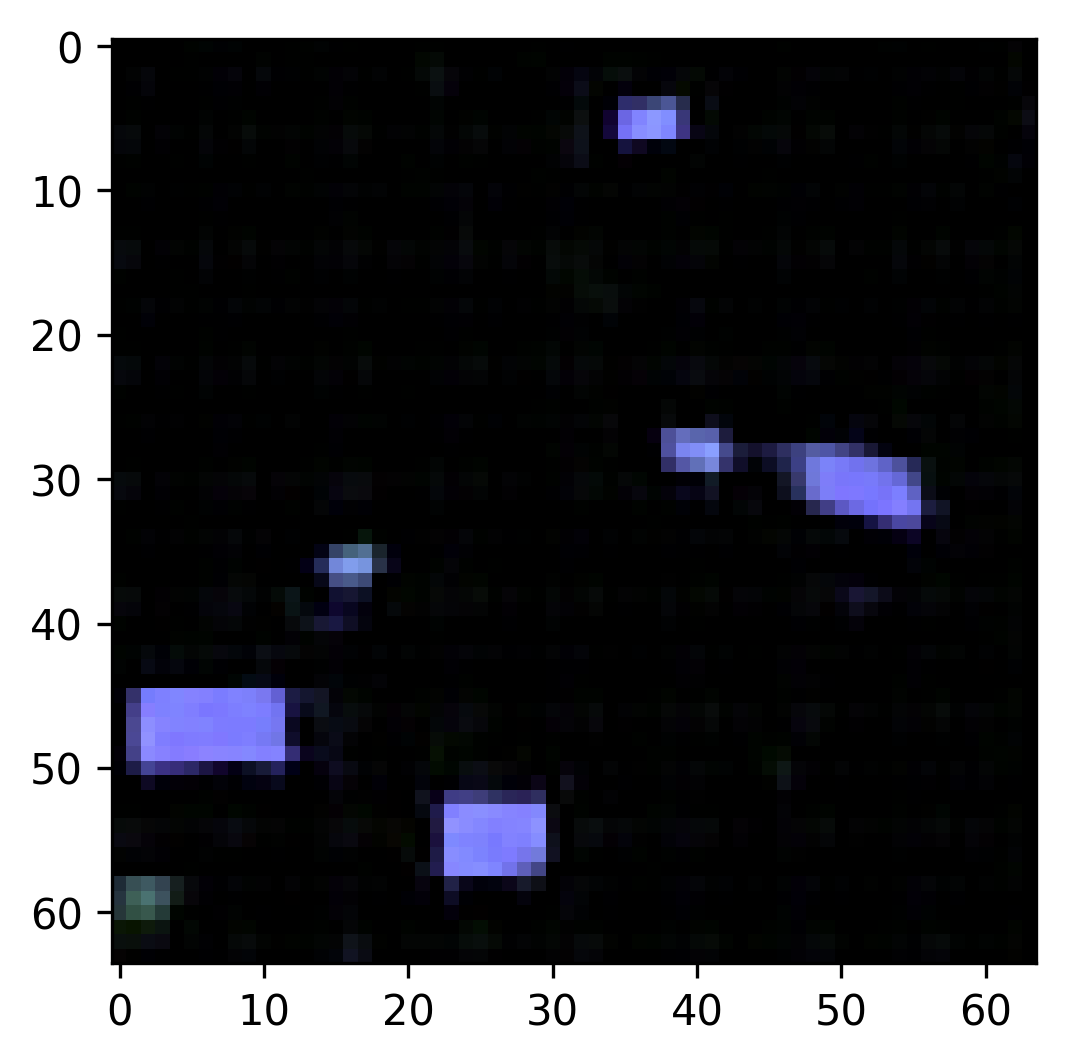

10
repr, std, cov, conv, closs 0.6460572481155396 0.475830078125 4.027644172310829e-05 0.0045003159902989864 0.2511149048805237
27.02046318477828 0.0066195926286672915 1.0
repr, std, cov, conv, closs 0.6329166889190674 0.4755859375 4.417938180267811e-05 0.004082452040165663 0.2519875168800354
26.778490491922625 0.006540671444823523 1.0
repr, std, cov, conv, closs 0.6429972648620605 0.476318359375 3.7916237488389015e-05 0.0047616236843168736 0.25133949518203735
27.21017480346108 0.006508065969204606 1.0
repr, std, cov, conv, closs 0.6387928128242493 0.476318359375 3.700726665556431e-05 0.004312661476433277 0.248296320438385
27.21017480346108 0.0066195926286672915 1.0
repr, std, cov, conv, closs 0.6503062844276428 0.47705078125 3.2945768907666206e-05 0.004885545931756496 0.24429702758789062
27.982434844379092 0.006834735983287479 1.0
repr, std, cov, conv, closs 0.6495689153671265 0.47705078125 3.239349462091923e-05 0.005219019949436188 0.24558836221694946
28.207079400286432 0.00695881254

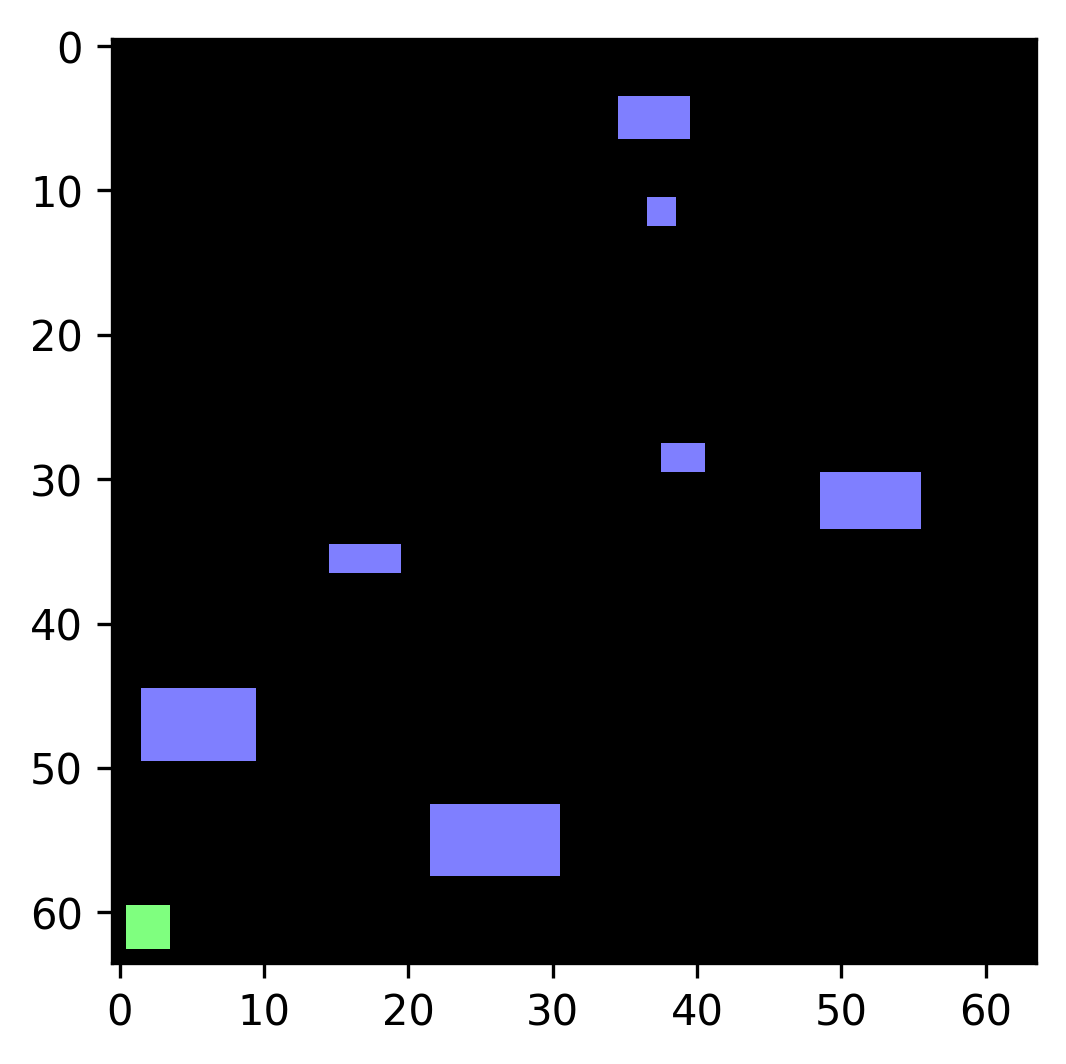

(3, 64, 64)


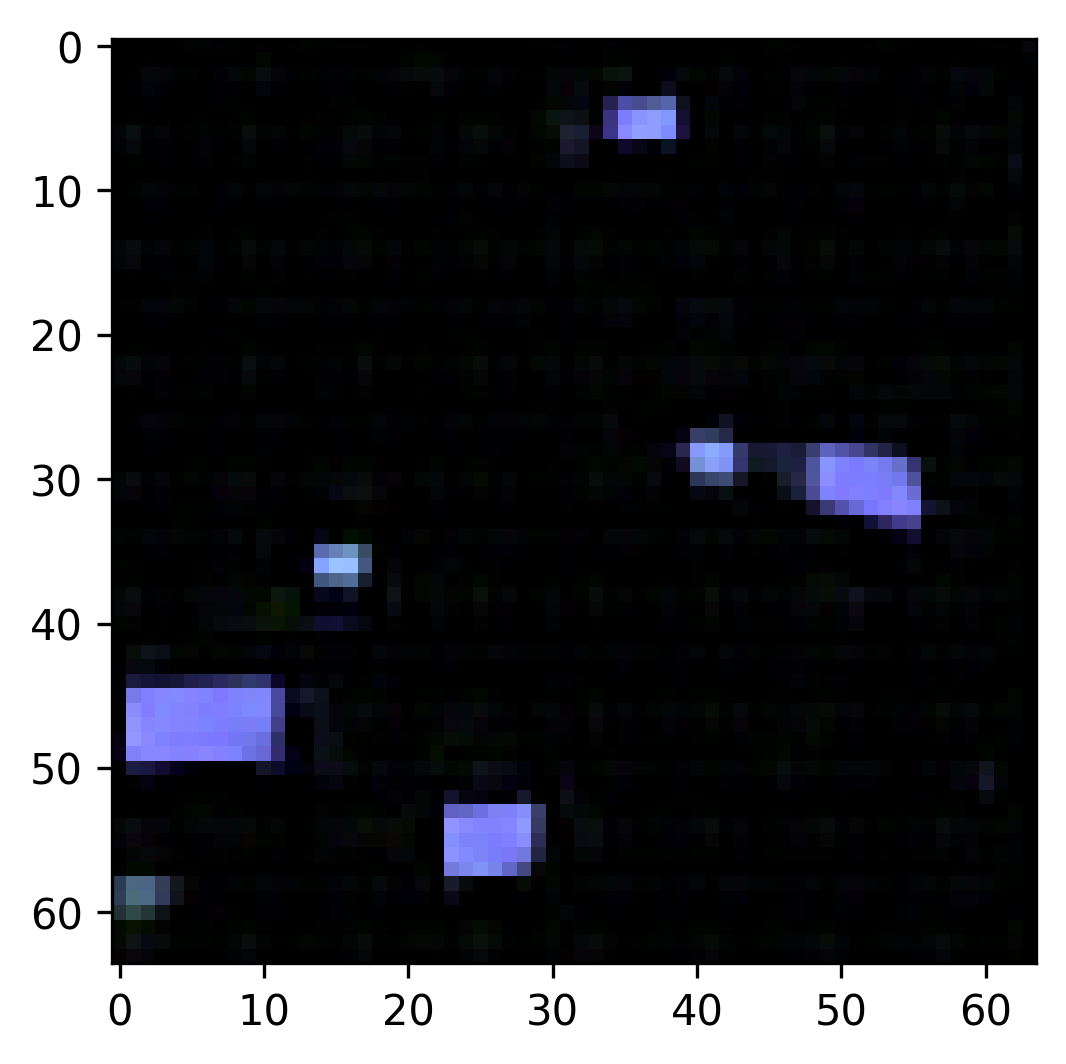

11
repr, std, cov, conv, closs 0.646674394607544 0.47705078125 3.241654485464096e-05 0.0044093383476138115 0.2496824860572815
27.182991811649433 0.00703574336688402 1.0
repr, std, cov, conv, closs 0.6661404371261597 0.47705078125 3.231293521821499e-05 0.005105816759169102 0.24974876642227173
27.676466926740932 0.007163468978979427 1.0
repr, std, cov, conv, closs 0.6338309049606323 0.477294921875 3.2335054129362106e-05 0.004514769650995731 0.24979883432388306
28.094532590323386 0.007396288856773863 1.0
repr, std, cov, conv, closs 0.6489265561103821 0.47705078125 3.302586264908314e-05 0.004648152738809586 0.25040632486343384
28.575979672112457 0.007530559746458725 1.0
repr, std, cov, conv, closs 0.630213737487793 0.476318359375 3.793439827859402e-05 0.004393204115331173 0.2507002353668213
27.842941429249912 0.007403685145630636 1.0
repr, std, cov, conv, closs 0.6257045865058899 0.475341796875 4.615797661244869e-05 0.004316636826843023 0.2508680820465088
27.346498051464227 0.0072716764470

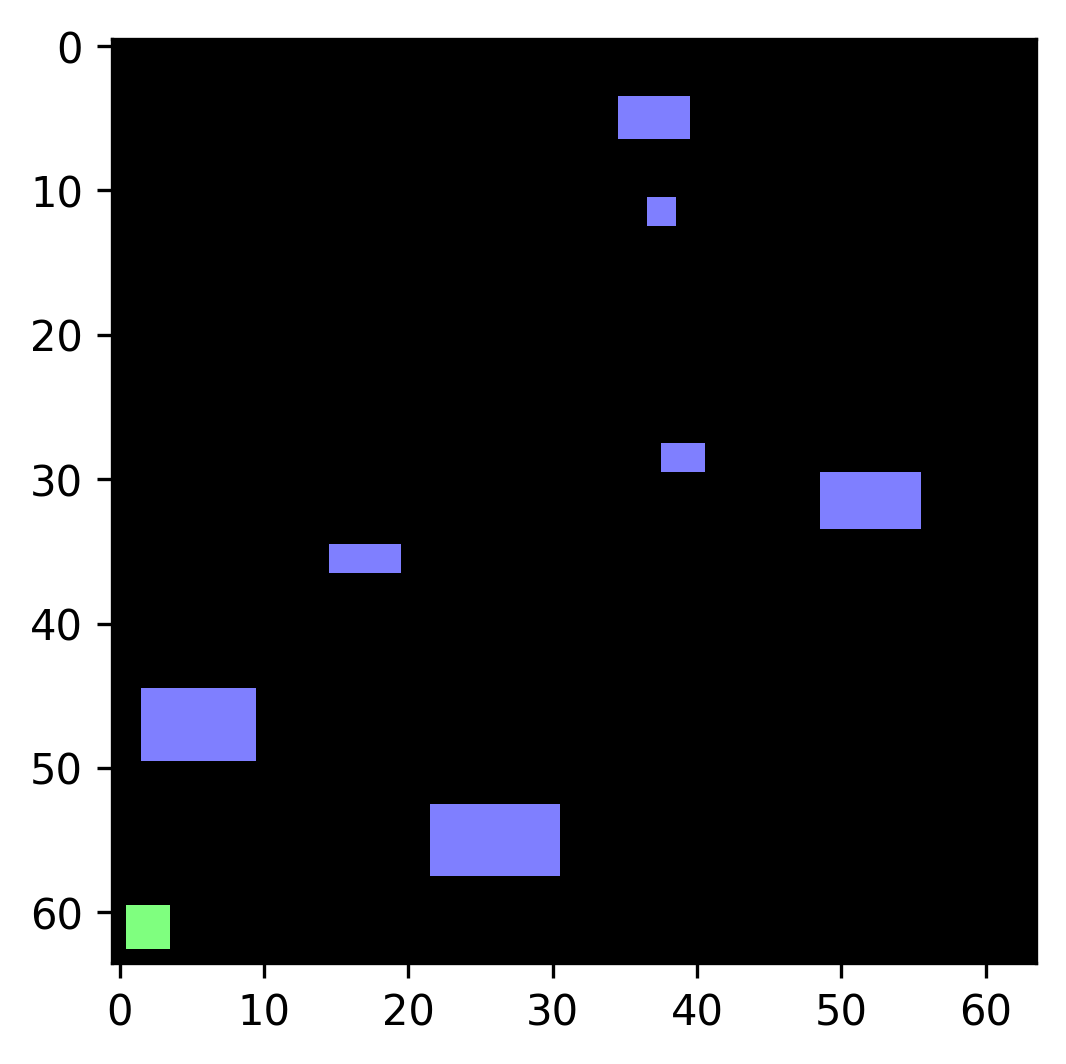

(3, 64, 64)


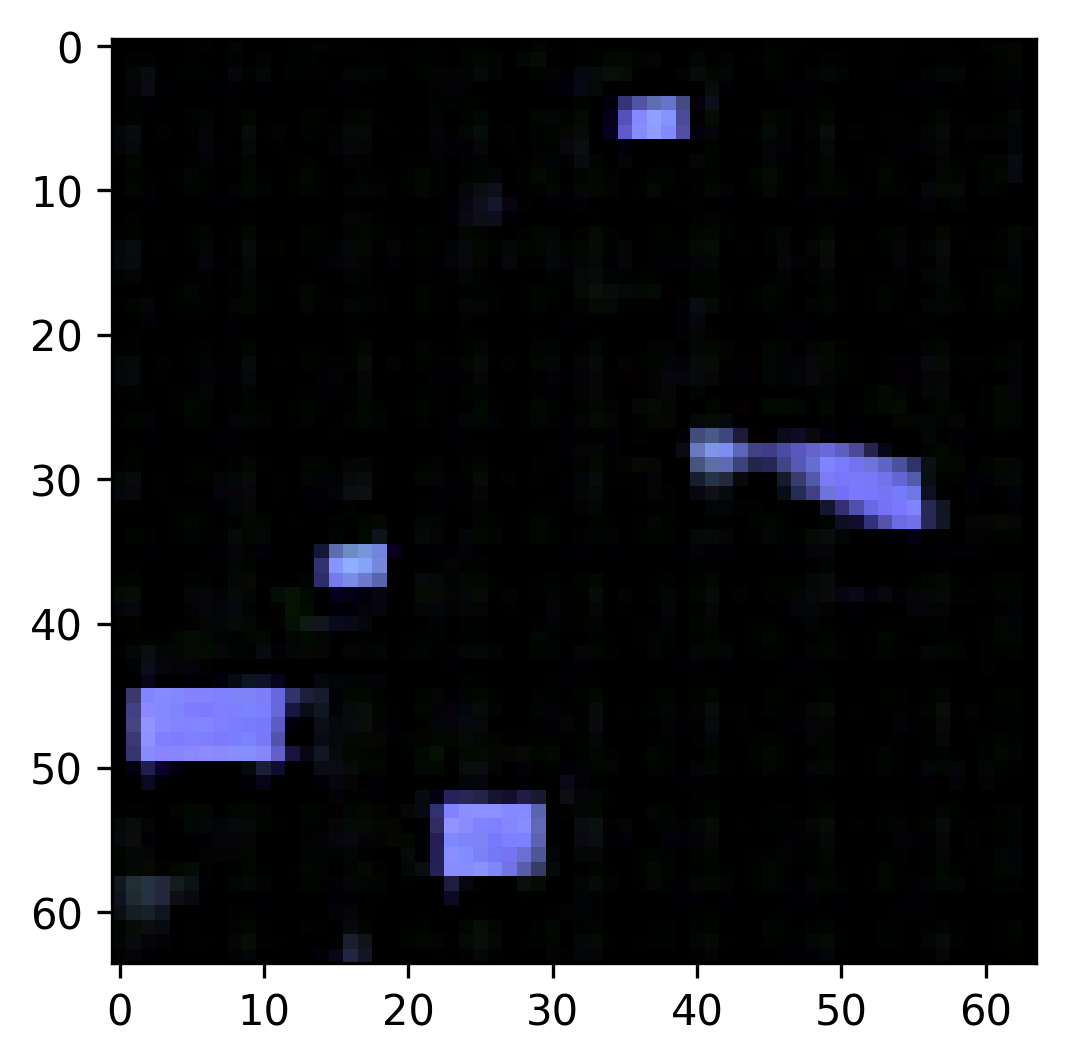

12
repr, std, cov, conv, closs 0.6457223892211914 0.4755859375 4.258868284523487e-05 0.004602917470037937 0.24976444244384766
28.9786542319906 0.0068827229040812525 1.0
repr, std, cov, conv, closs 0.6239056587219238 0.4755859375 4.30236104875803e-05 0.004283074289560318 0.25498294830322266
28.575979672112457 0.00676000303213283 1.0
repr, std, cov, conv, closs 0.6225610971450806 0.475830078125 4.1476916521787643e-05 0.00406630290672183 0.2517702579498291
28.150749750036617 0.006573440274201509 1.0
repr, std, cov, conv, closs 0.6686151027679443 0.47607421875 3.899657167494297e-05 0.004642710089683533 0.25099778175354004
28.150749750036617 0.00658001371447571 1.0
repr, std, cov, conv, closs 0.6309796571731567 0.476318359375 3.712461329996586e-05 0.004180717281997204 0.2522315979003906
28.433527415284427 0.006666069020430727 1.0
repr, std, cov, conv, closs 0.6833947896957397 0.47705078125 3.149057738482952e-05 0.004527104552835226 0.2496931552886963
28.7478647617886 0.006787083631326324 1.

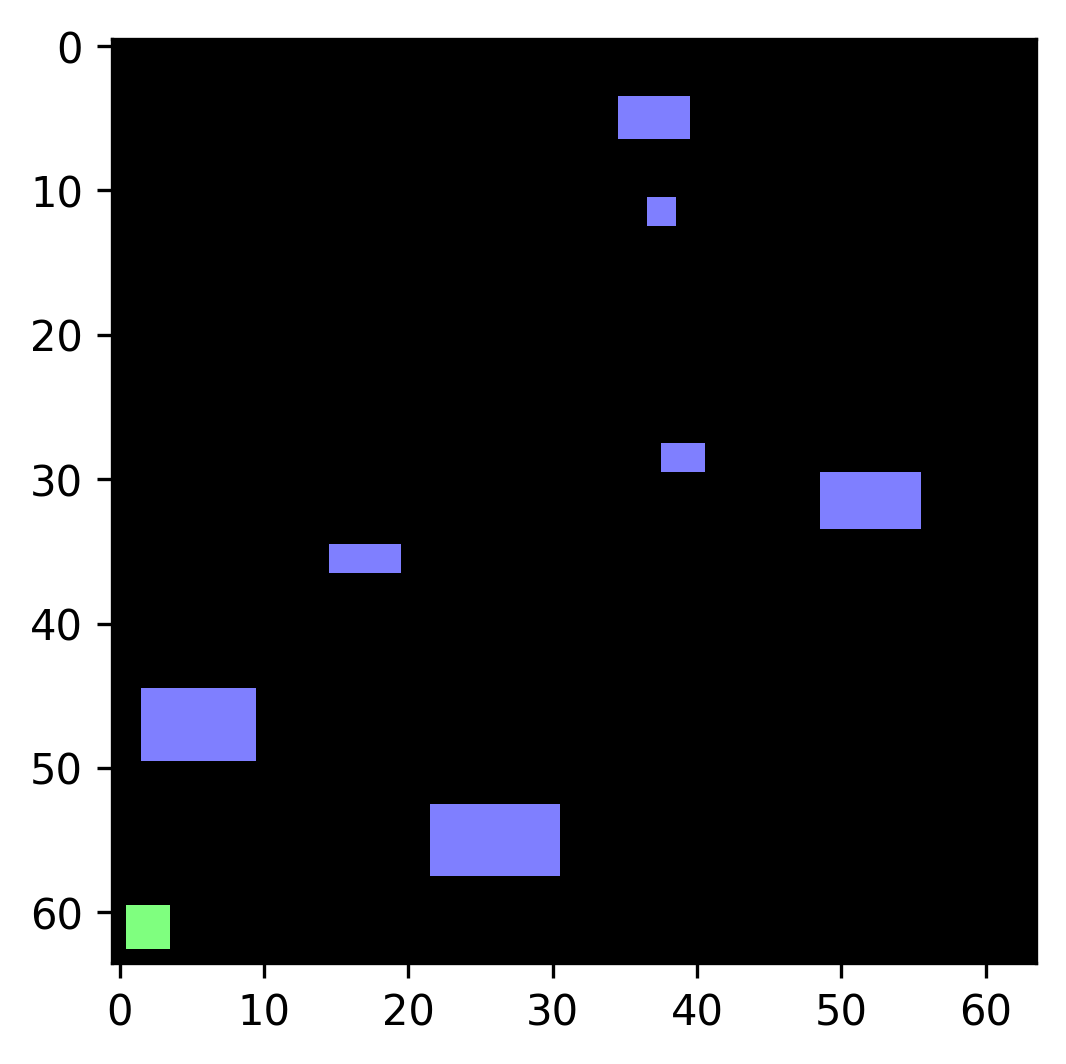

(3, 64, 64)


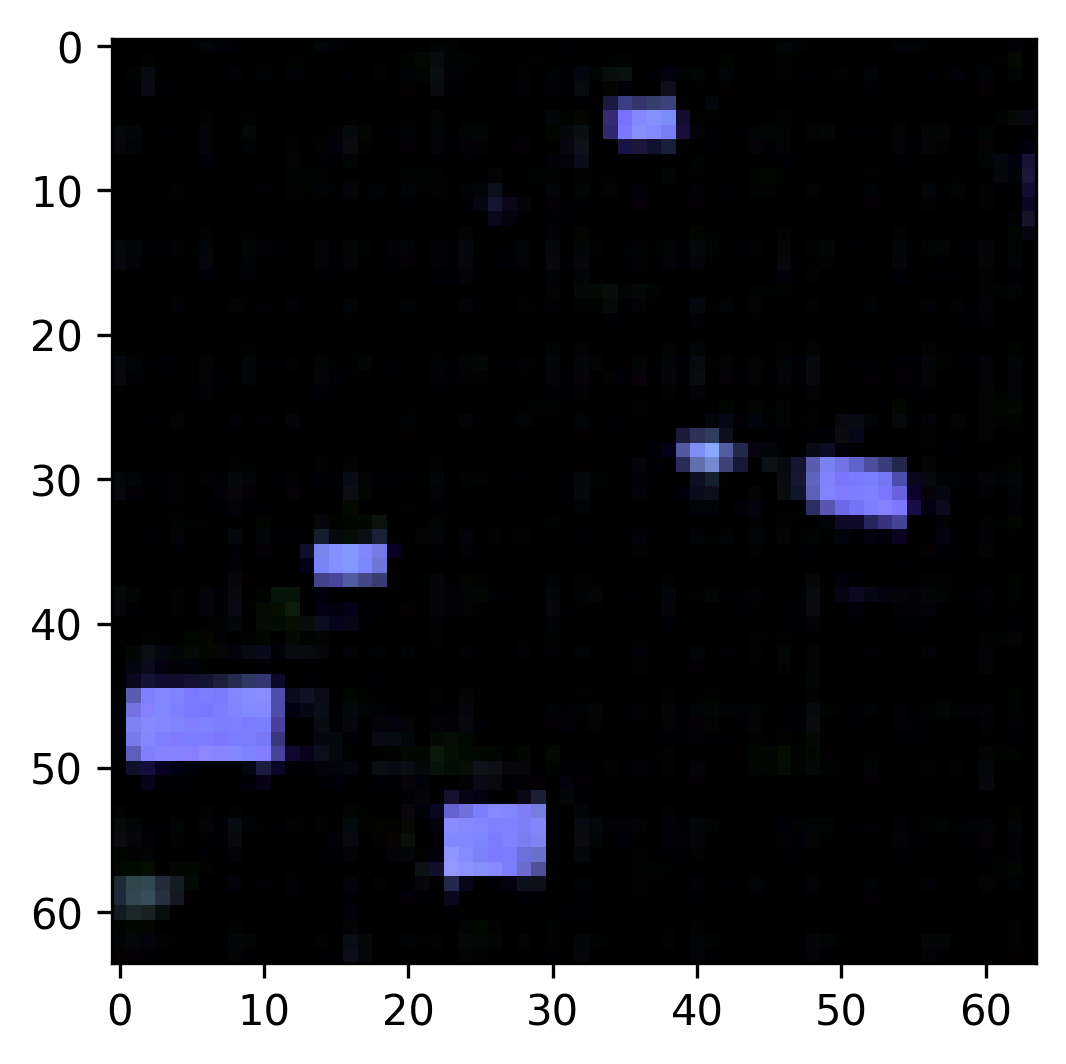

13
repr, std, cov, conv, closs 0.6291320323944092 0.477294921875 3.039790317416191e-05 0.004967364948242903 0.2540140151977539
27.373844549515688 0.007293513298727238 1.0
repr, std, cov, conv, closs 0.6332671642303467 0.47705078125 3.243749961256981e-05 0.005204429849982262 0.2522871494293213
27.42861961245926 0.007411088830776266 1.0
repr, std, cov, conv, closs 0.6241054534912109 0.47607421875 3.886781632900238e-05 0.004786833189427853 0.24990487098693848
26.858906325648352 0.007249904975194557 1.0
repr, std, cov, conv, closs 0.636548638343811 0.476318359375 3.7918100133538246e-05 0.0046718530356884 0.2536795139312744
26.591788612430896 0.007127758835898346 1.0
repr, std, cov, conv, closs 0.6173821687698364 0.475830078125 4.26536425948143e-05 0.004682066850364208 0.2442941665649414
26.380008425661163 0.0069033917278449285 1.0
repr, std, cov, conv, closs 0.6245649456977844 0.47607421875 3.996584564447403e-05 0.003789215814322233 0.2470400333404541
25.93555898876223 0.006793870714957649

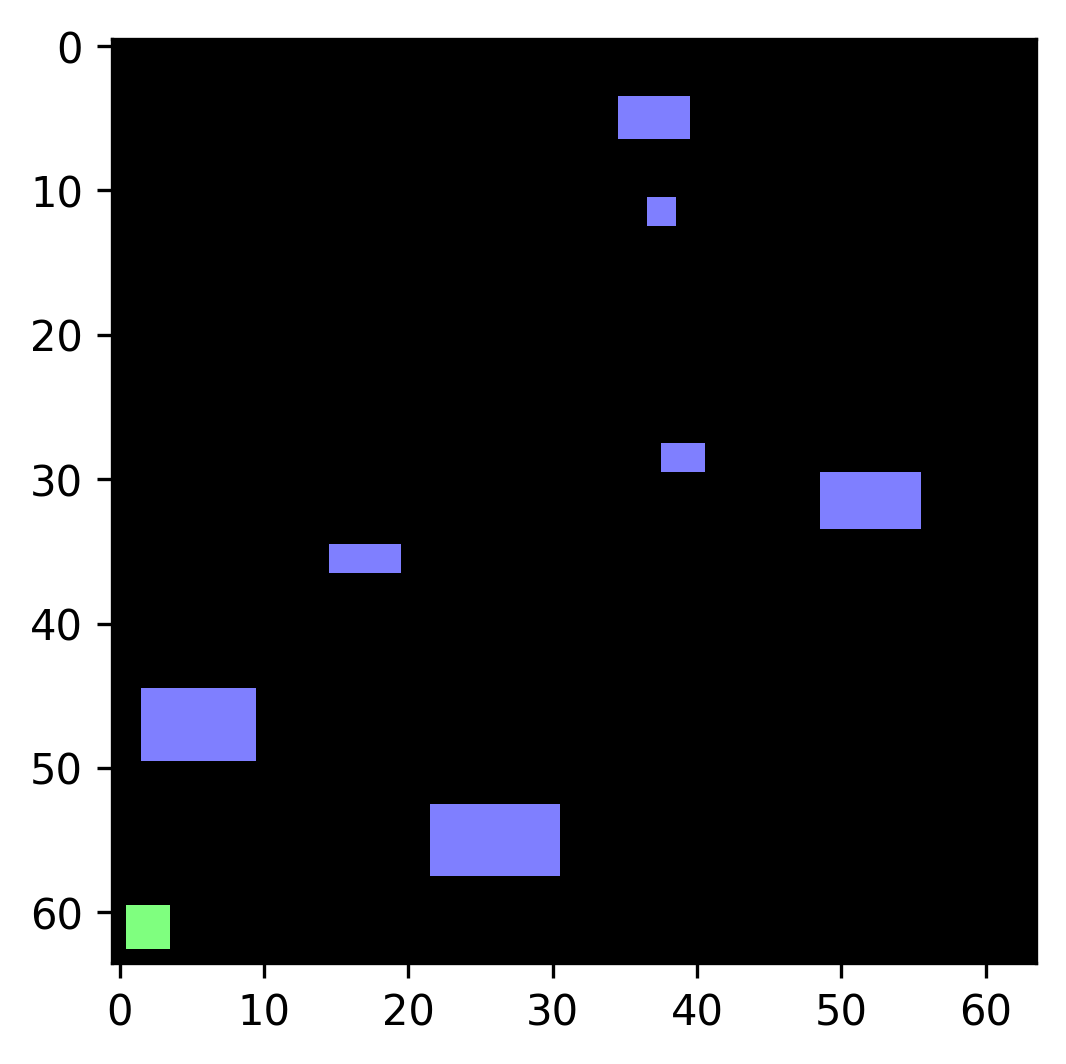

(3, 64, 64)


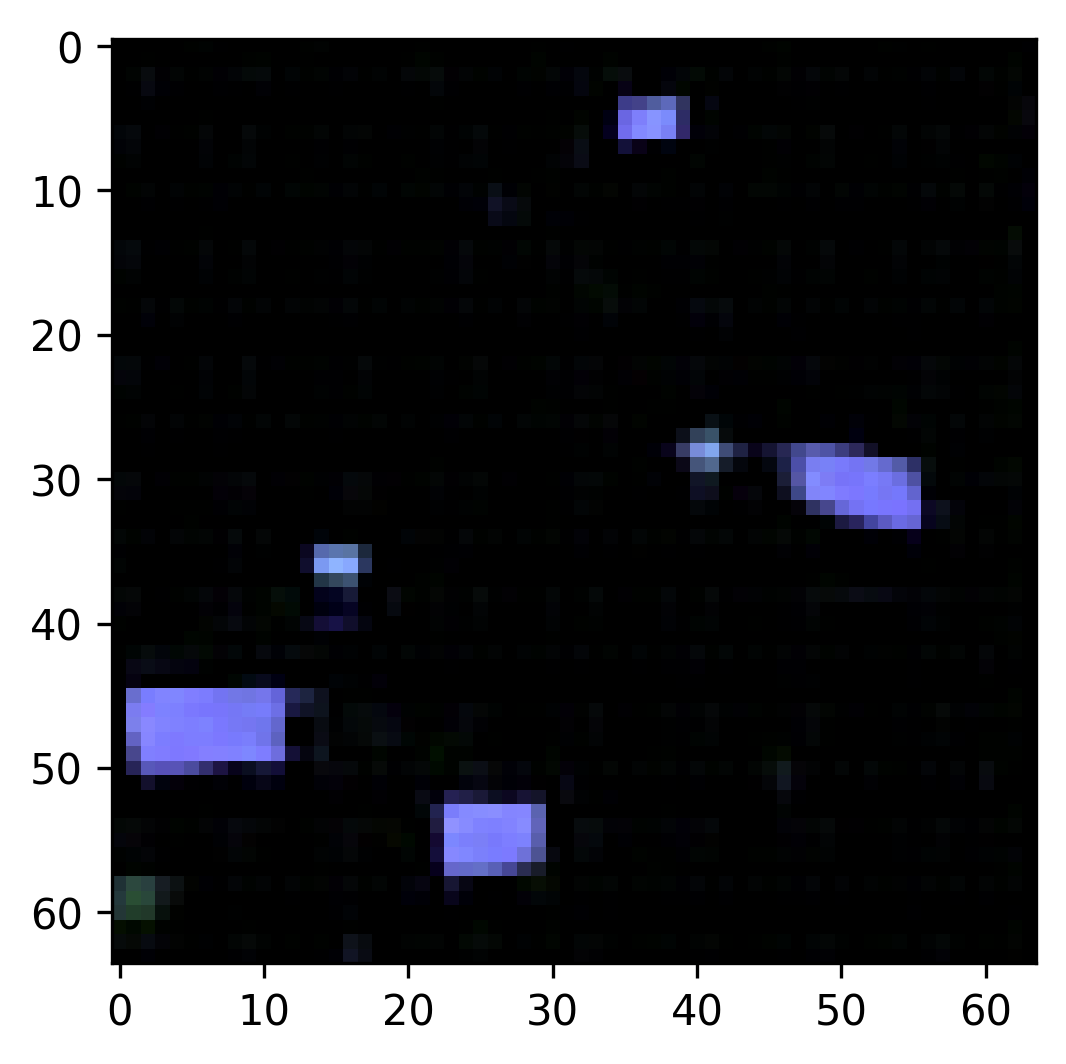

14
repr, std, cov, conv, closs 0.6474835276603699 0.4765625 3.5913893952965736e-05 0.004873449914157391 0.24900460243225098
27.047483647963055 0.0069379777894698685 1.0
repr, std, cov, conv, closs 0.6582132577896118 0.47705078125 3.355438821017742e-05 0.005462196655571461 0.24926000833511353
27.53849877236867 0.0070639285829617645 1.0
repr, std, cov, conv, closs 0.6291873455047607 0.4765625 3.6151381209492683e-05 0.003945958334952593 0.25097471475601196
27.92655381020488 0.007249904975194557 1.0
repr, std, cov, conv, closs 0.6330450773239136 0.47607421875 3.909273073077202e-05 0.0036660467740148306 0.24842286109924316
27.870784370679157 0.007278948123532052 1.0
repr, std, cov, conv, closs 0.644195556640625 0.4755859375 4.2754923924803734e-05 0.004507241304963827 0.24906688928604126
28.094532590323386 0.007228198687308373 1.0
repr, std, cov, conv, closs 0.6416292786598206 0.47607421875 3.9295293390750885e-05 0.004419339820742607 0.2473297119140625
27.842941429249912 0.007142021481328977

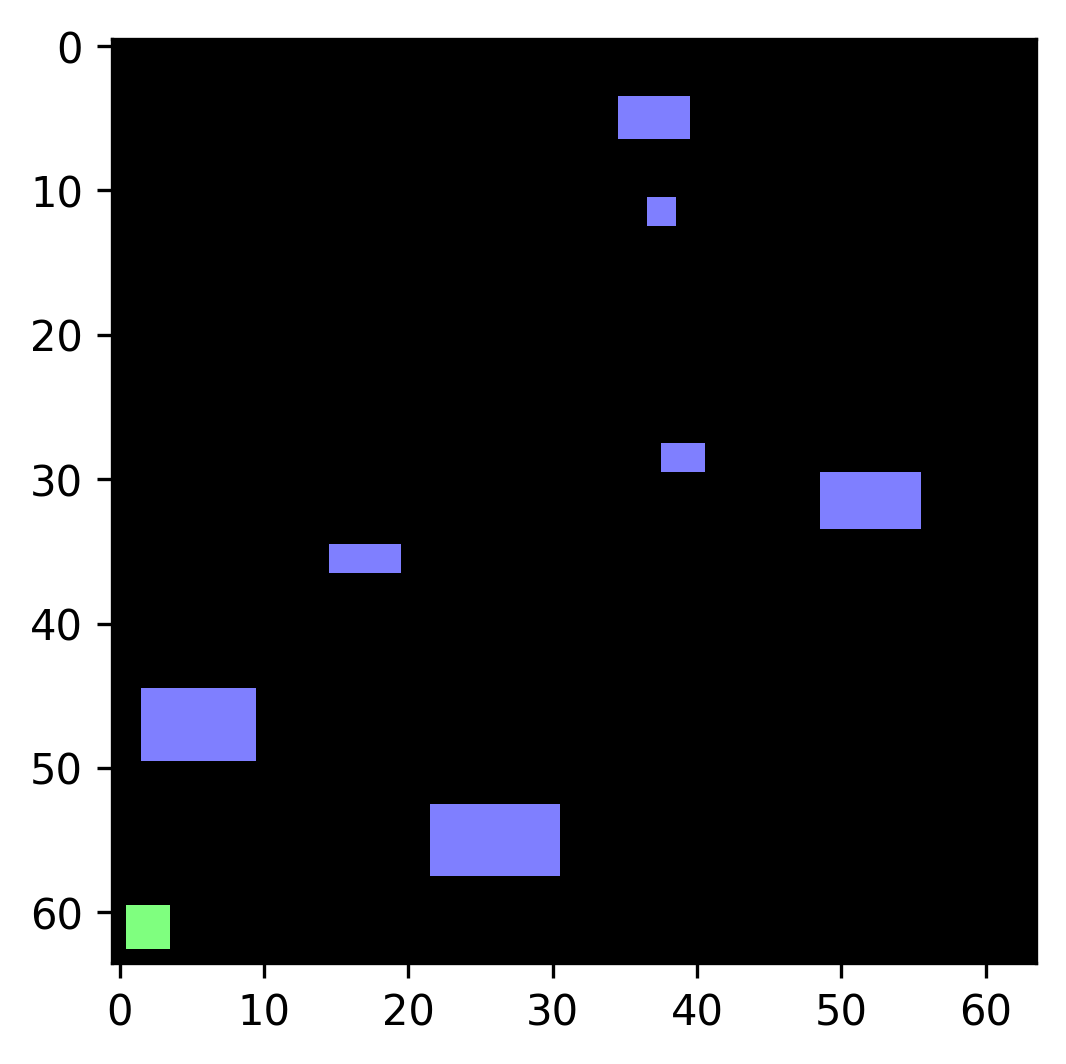

(3, 64, 64)


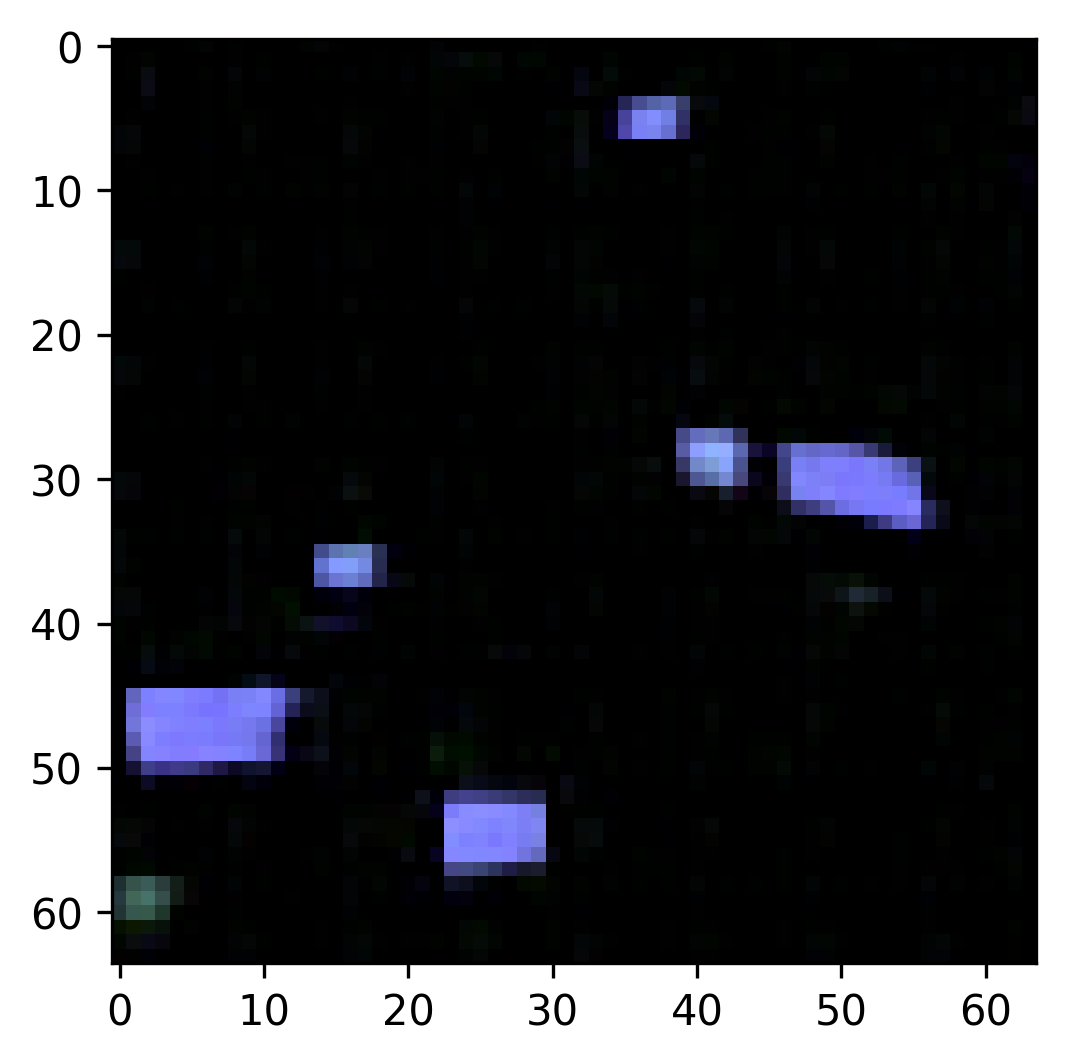

15
repr, std, cov, conv, closs 0.6303966045379639 0.4755859375 4.229205660521984e-05 0.004428008105605841 0.25
28.34839715029371 0.006855260702280024 1.0
repr, std, cov, conv, closs 0.6423348784446716 0.47509765625 4.6221306547522545e-05 0.004002925008535385 0.25054001808166504
28.235286479686714 0.006739763515555854 1.0
repr, std, cov, conv, closs 0.6247310042381287 0.475341796875 4.410115070641041e-05 0.004445637576282024 0.25010013580322266
27.759579384598393 0.006560313087712997 1.0
repr, std, cov, conv, closs 0.6300007104873657 0.4755859375 4.2190542444586754e-05 0.004152492620050907 0.24991703033447266
27.53849877236867 0.006495069335464343 1.0
repr, std, cov, conv, closs 0.6323917508125305 0.475830078125 4.1088322177529335e-05 0.004501319956034422 0.250011682510376
27.21017480346108 0.006398418306905135 1.0
repr, std, cov, conv, closs 0.6167776584625244 0.4765625 3.6011915653944016e-05 0.004024744499474764 0.2494049072265625
27.21017480346108 0.00651457403517381 1.0
repr, std, c

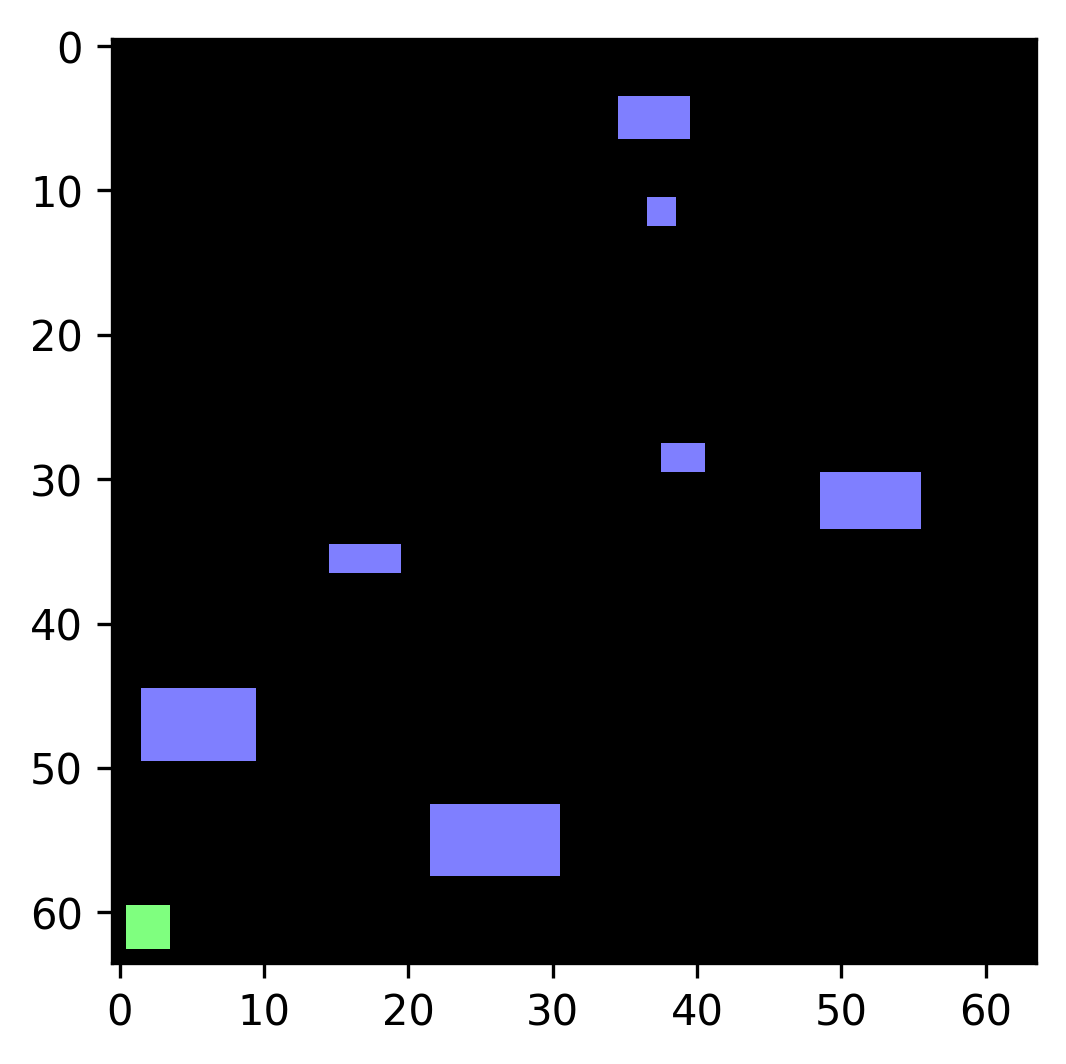

(3, 64, 64)


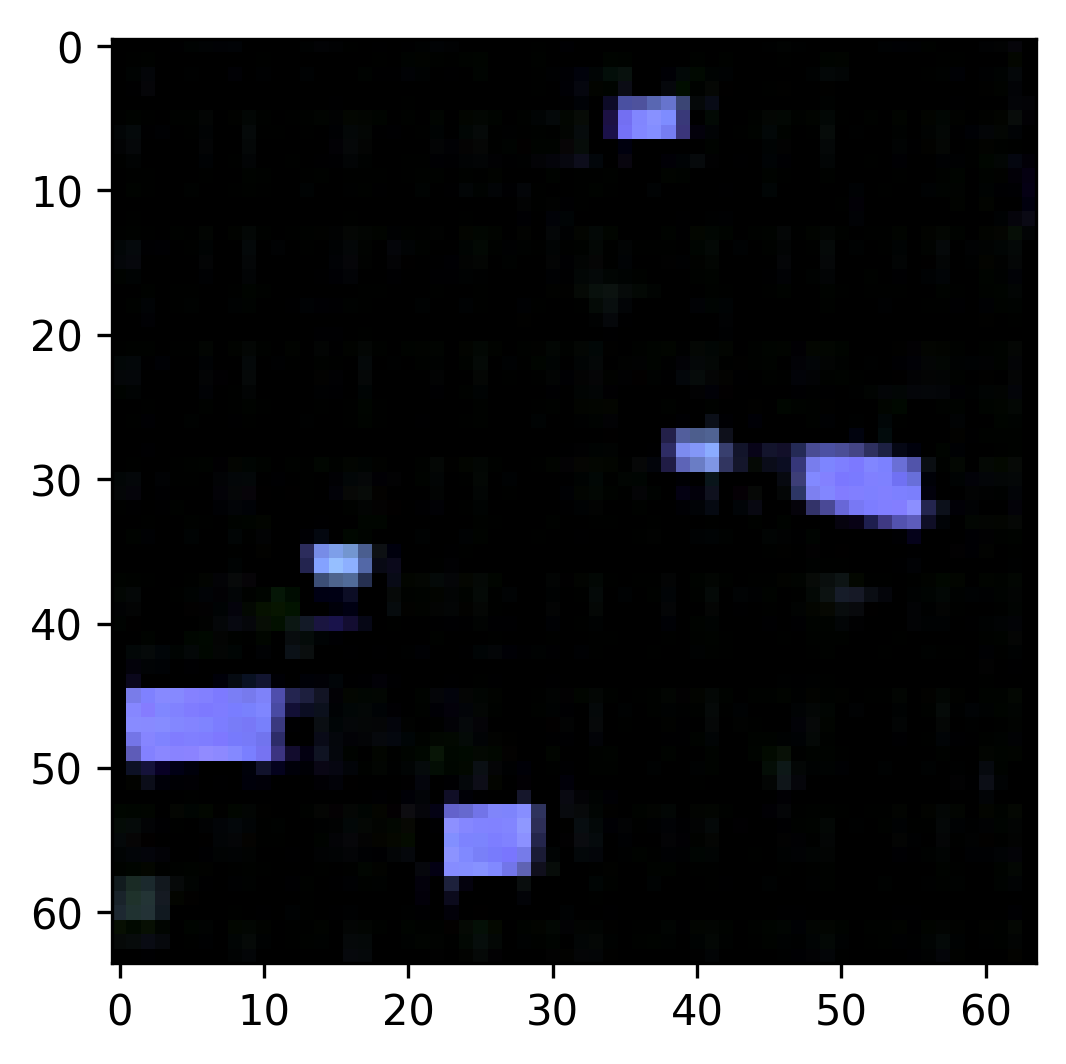

16
repr, std, cov, conv, closs 0.6672993898391724 0.47705078125 3.2837968319654465e-05 0.005073941312730312 0.2532389163970947
29.50472747776923 0.007056871711250514 1.0
repr, std, cov, conv, closs 0.6568583250045776 0.476806640625 3.4528784453868866e-05 0.0046682502143085 0.2481842041015625
29.741593084292454 0.007177803080406364 1.0
repr, std, cov, conv, closs 0.6244798898696899 0.476318359375 3.638956695795059e-05 0.0044257184490561485 0.252514123916626
29.475252225543688 0.007344721311125988 1.0
repr, std, cov, conv, closs 0.6465047001838684 0.476318359375 3.7124380469322205e-05 0.004282101523131132 0.24903512001037598
29.152961417203944 0.007322731142183283 1.0
repr, std, cov, conv, closs 0.6372634172439575 0.4765625 3.802706487476826e-05 0.0046416157856583595 0.2524566650390625
29.71188120308937 0.007463122345104794 1.0
repr, std, cov, conv, closs 0.6227301359176636 0.4755859375 4.2550964280962944e-05 0.004218323156237602 0.2482435703277588
29.182114378621144 0.007330053873325465

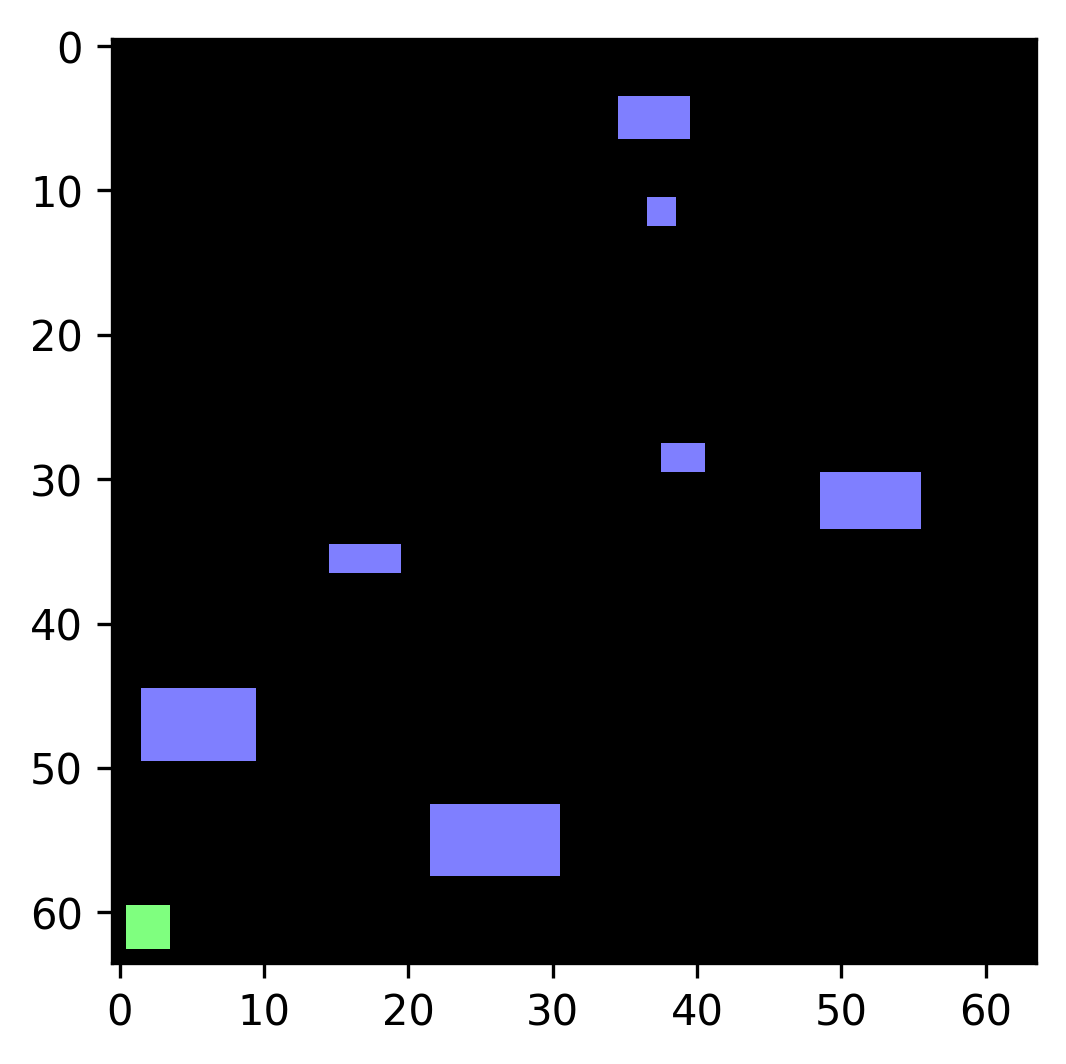

(3, 64, 64)


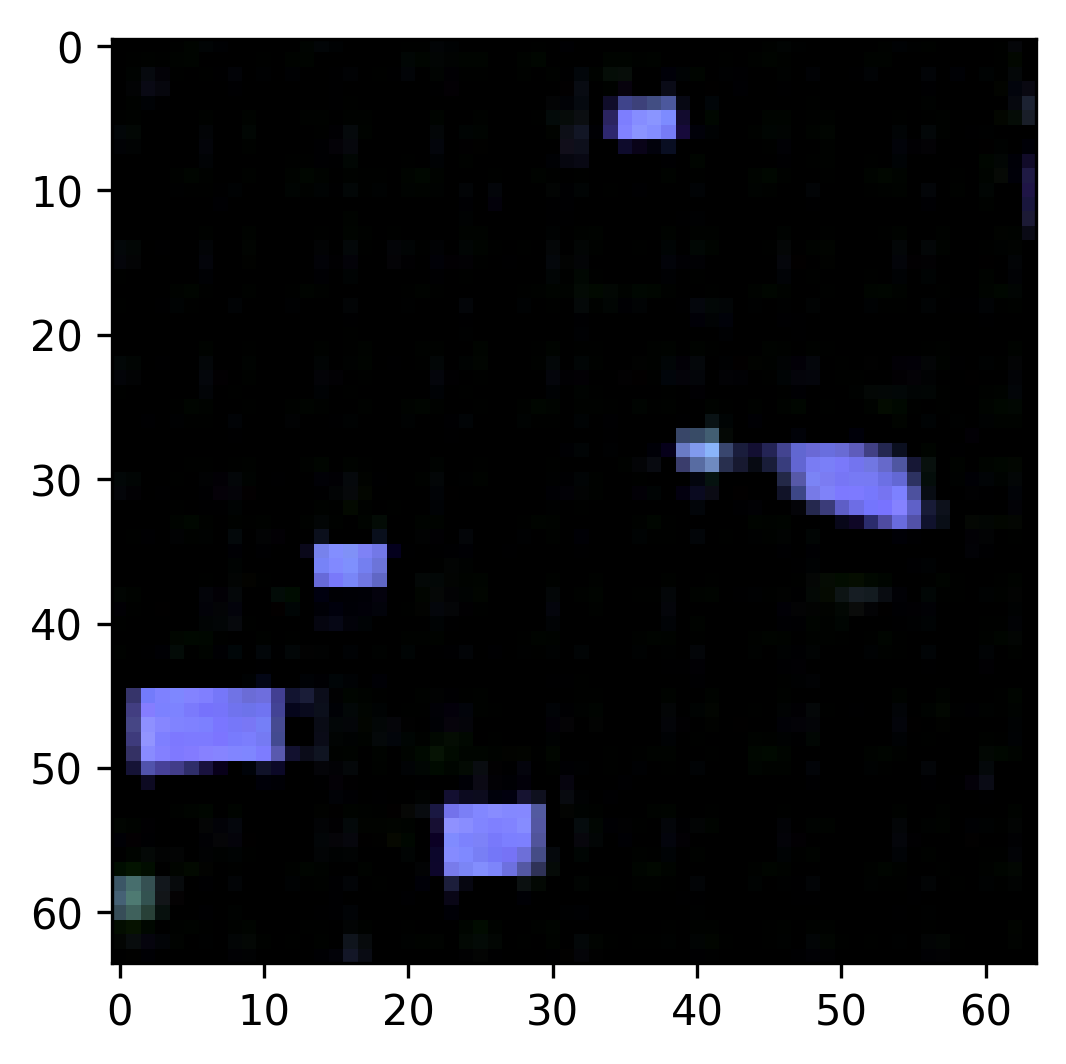

17
repr, std, cov, conv, closs 0.6329384446144104 0.475341796875 4.4539570808410645e-05 0.004586538299918175 0.25600677728652954
28.7478647617886 0.007014678280991527 1.0
repr, std, cov, conv, closs 0.6511164903640747 0.475830078125 4.094978794455528e-05 0.004641733132302761 0.25407081842422485
28.604555651784565 0.006910295119572773 1.0
repr, std, cov, conv, closs 0.6302158832550049 0.475341796875 4.4751446694135666e-05 0.004478419665247202 0.24458718299865723
27.898655155049834 0.0066994660929171074 1.0
repr, std, cov, conv, closs 0.6408088207244873 0.47607421875 3.9157457649707794e-05 0.0041403984650969505 0.25409847497940063
28.038427696502687 0.0066727350894511565 1.0
repr, std, cov, conv, closs 0.6410887241363525 0.475830078125 3.9657577872276306e-05 0.0038483438547700644 0.2534938454627991
28.66179336764378 0.006793870714957649 1.0
repr, std, cov, conv, closs 0.6436963081359863 0.47607421875 3.847293555736542e-05 0.0039075156673789024 0.25057244300842285
28.94970452746314 0.0068

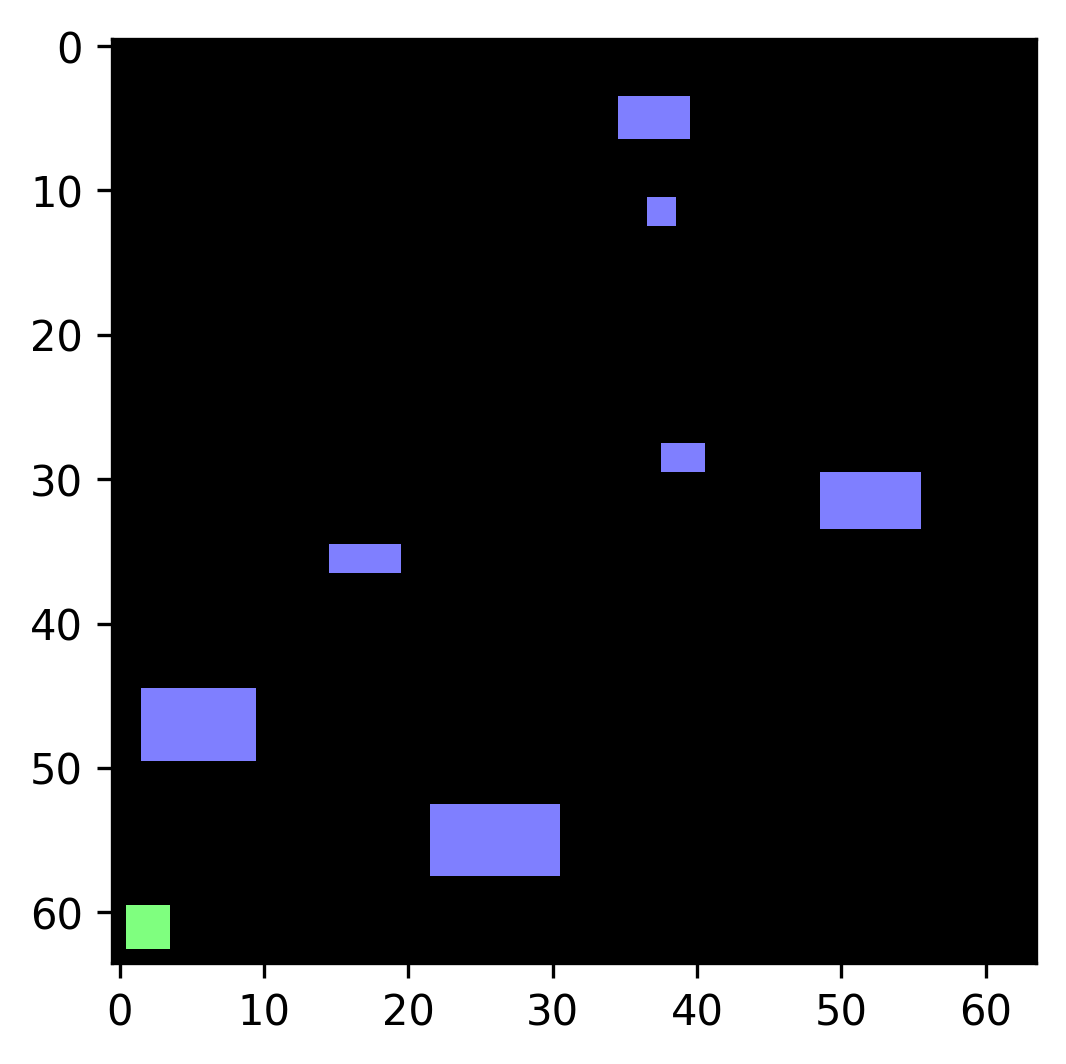

(3, 64, 64)


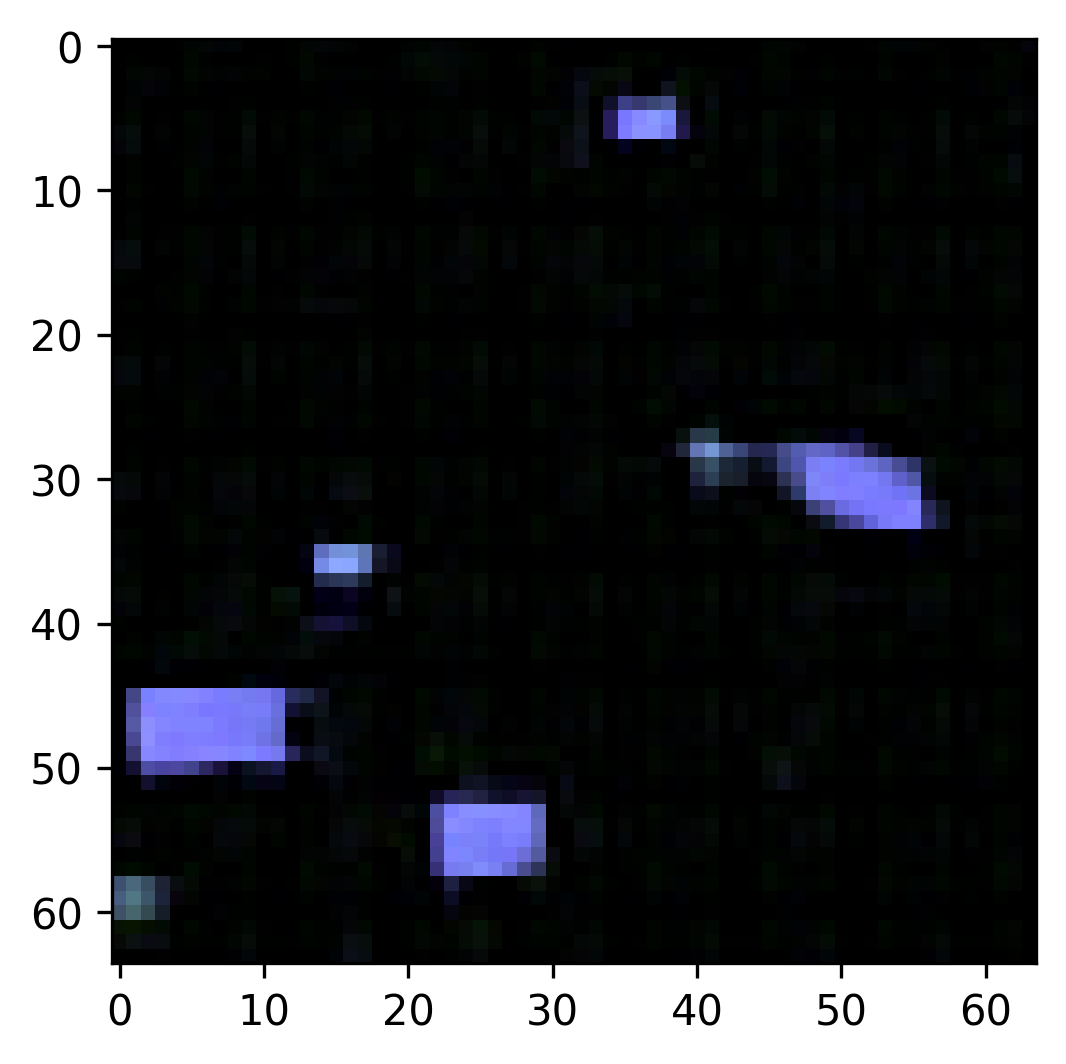

18
repr, std, cov, conv, closs 0.6742225289344788 0.4775390625 3.0544353649020195e-05 0.005613282322883606 0.24931550025939941
31.047708985693728 0.007085141567560325 1.0
repr, std, cov, conv, closs 0.6687303781509399 0.477783203125 2.8480542823672295e-05 0.004686513915657997 0.247802734375
31.548215497902778 0.007213763945653123 1.0
repr, std, cov, conv, closs 0.6485852599143982 0.47705078125 3.3569056540727615e-05 0.004253919702023268 0.25258469581604004
31.642954820591182 0.007448218459966402 1.0
repr, std, cov, conv, closs 0.6625460386276245 0.4765625 3.5227974876761436e-05 0.004621624946594238 0.24976593255996704
31.896986236113108 0.007568287926131736 1.0
repr, std, cov, conv, closs 0.648766279220581 0.47607421875 3.970717079937458e-05 0.004607252776622772 0.2491665482521057
30.89293507189968 0.0073815184383786685 1.0
repr, std, cov, conv, closs 0.6387375593185425 0.475341796875 4.493049345910549e-05 0.0042567867785692215 0.24852395057678223
30.433227285008368 0.00724990497519455

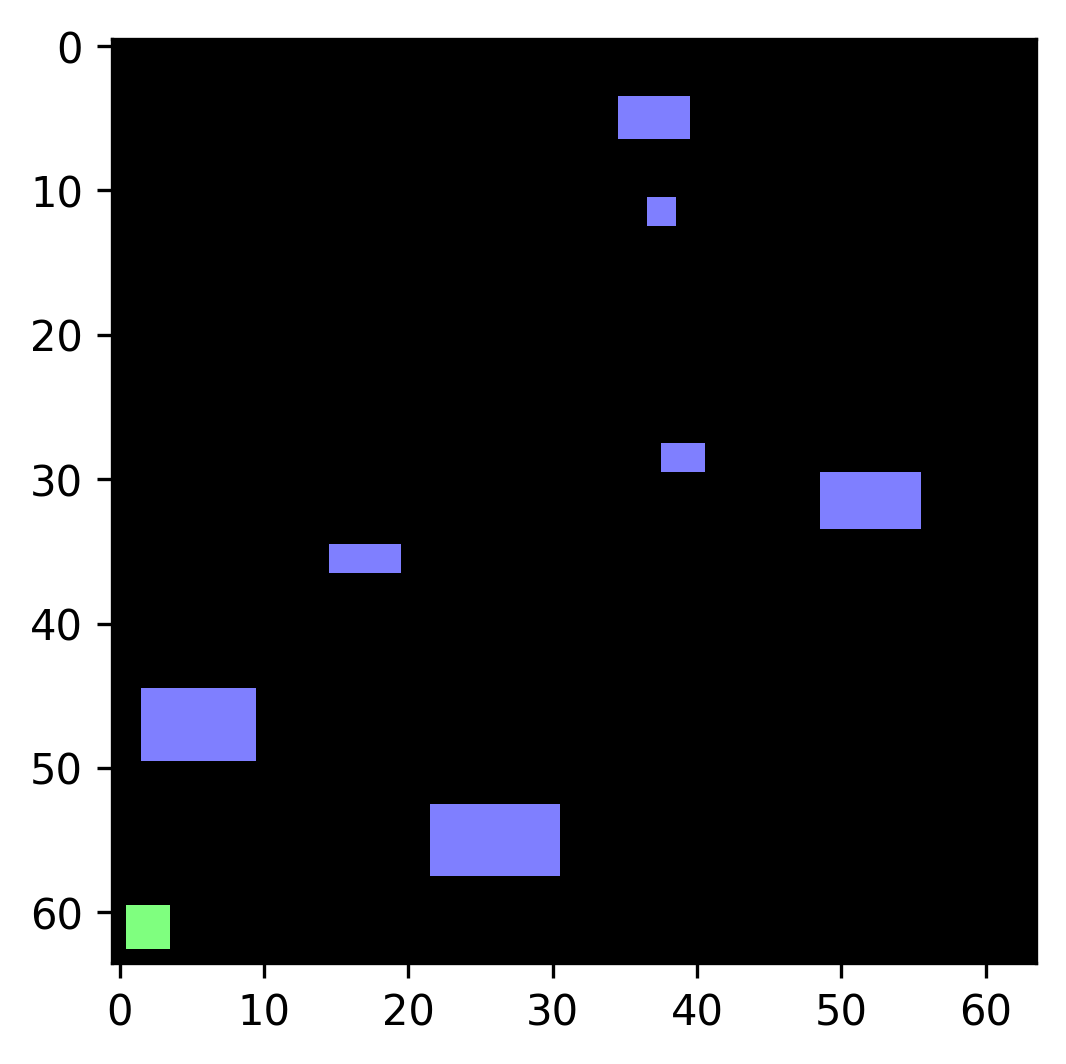

(3, 64, 64)


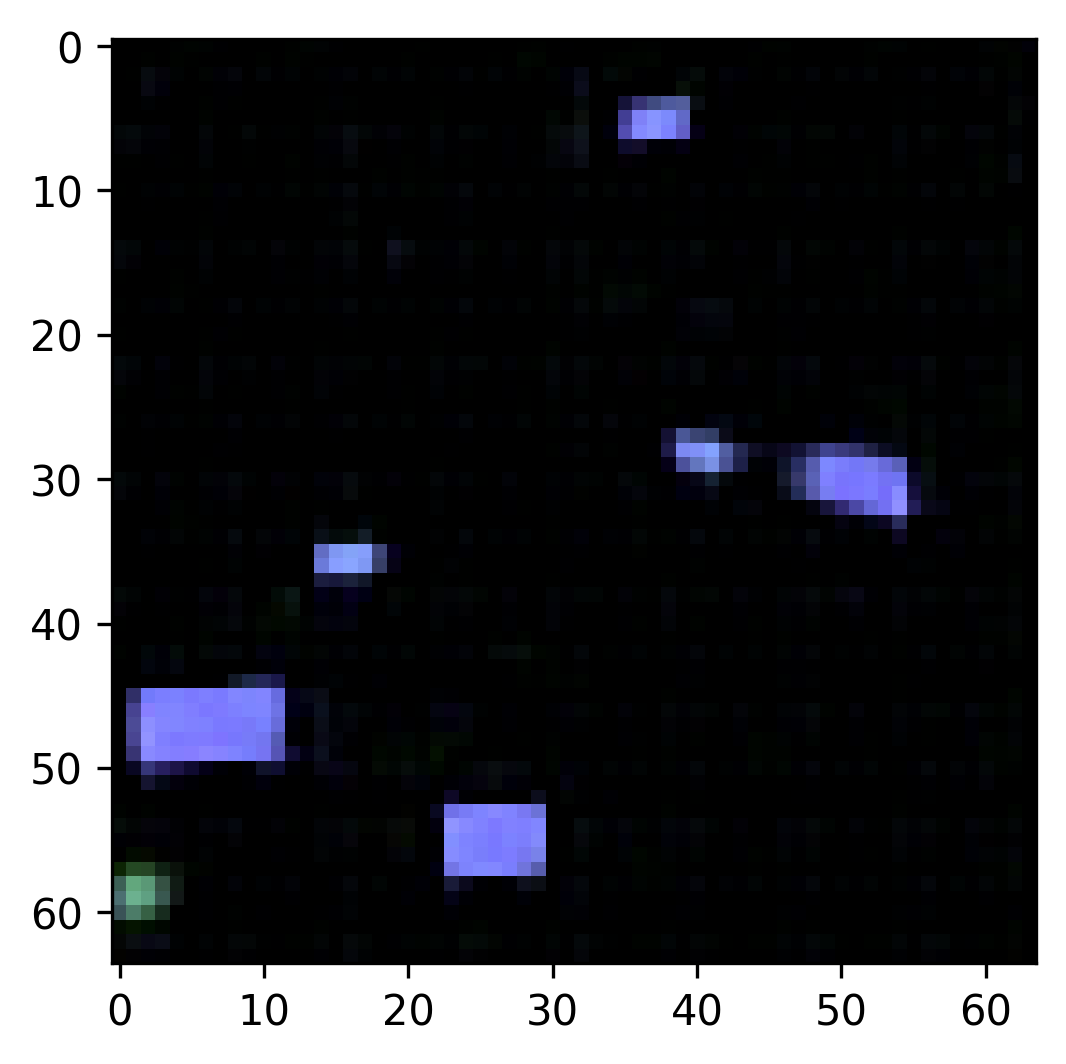

19
repr, std, cov, conv, closs 0.6531764268875122 0.475830078125 4.1344668716192245e-05 0.004687316250056028 0.24391388893127441
28.433527415284427 0.0068621159629823035 1.0
repr, std, cov, conv, closs 0.6569803357124329 0.475830078125 4.103640094399452e-05 0.004431318026036024 0.2539827823638916
28.7478647617886 0.006814272715508536 1.0
repr, std, cov, conv, closs 0.6404978036880493 0.4755859375 4.43353783339262e-05 0.0049072494730353355 0.2620565891265869
29.21129649299976 0.006733030485070784 1.0
repr, std, cov, conv, closs 0.6375802755355835 0.4755859375 4.19344287365675e-05 0.004636280704289675 0.2498610019683838
28.834194628416107 0.006632838433517254 1.0
repr, std, cov, conv, closs 0.6444076895713806 0.47607421875 3.930274397134781e-05 0.0046114083379507065 0.24771648645401
28.891891851867562 0.006706165559010024 1.0
repr, std, cov, conv, closs 0.649145781993866 0.476318359375 3.7689926102757454e-05 0.004364004358649254 0.2503719925880432
29.416390029095474 0.006807465250258278 

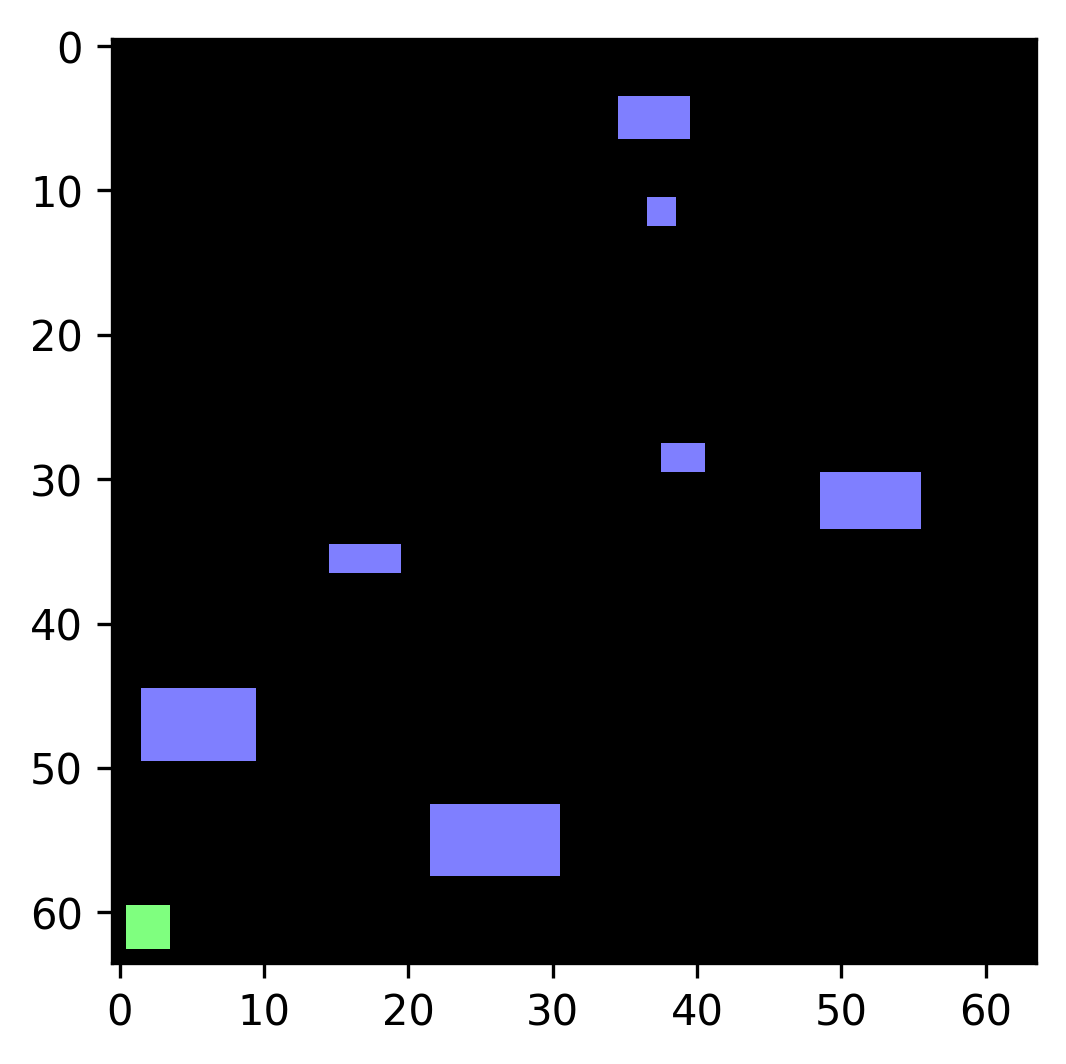

(3, 64, 64)


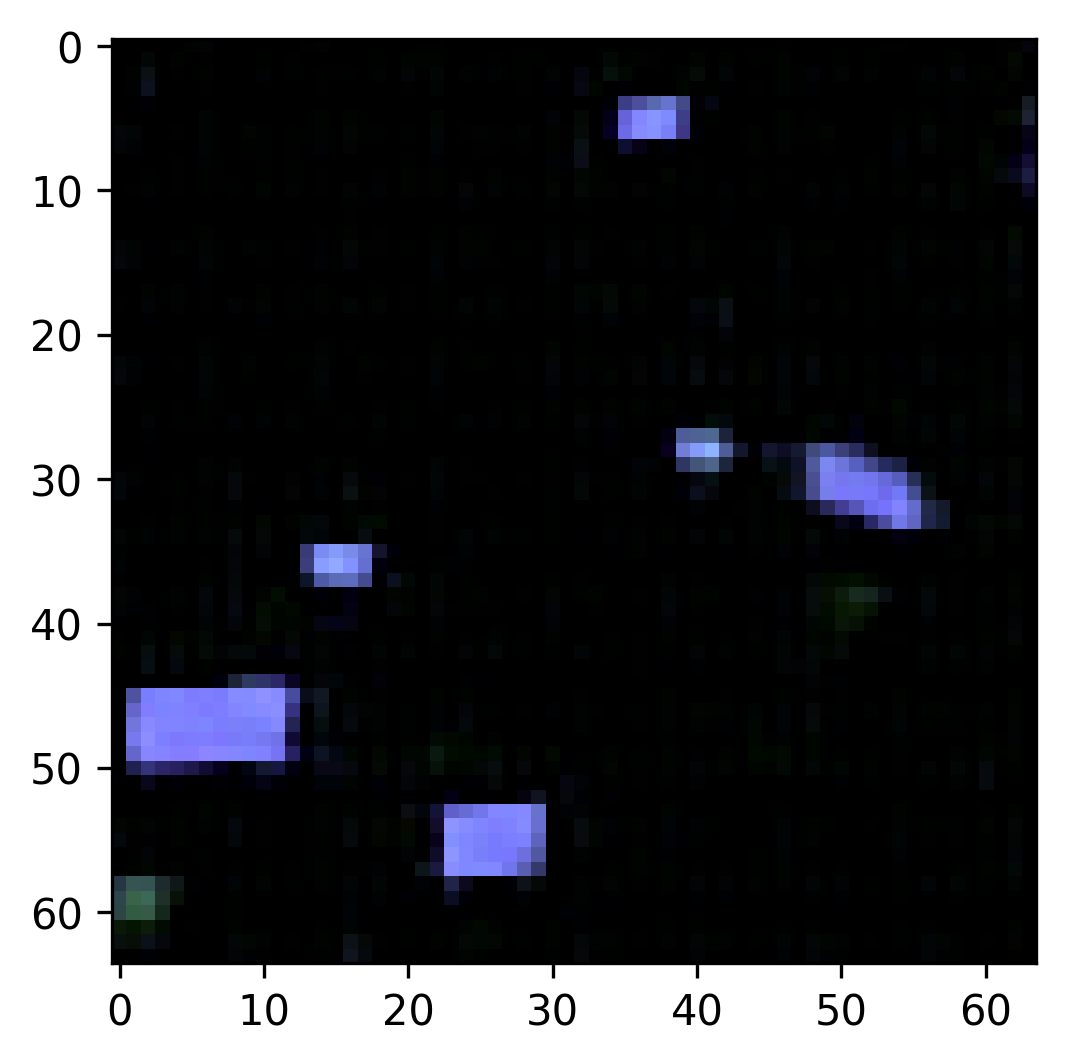

20
repr, std, cov, conv, closs 0.6448667049407959 0.47607421875 3.8996338844299316e-05 0.004828951321542263 0.251708984375
29.299018045579523 0.006787083631326324 1.0
repr, std, cov, conv, closs 0.6594107151031494 0.476806640625 3.356742672622204e-05 0.005146353505551815 0.2519705295562744
29.83090711806617 0.006910295119572773 1.0
repr, std, cov, conv, closs 0.6100850105285645 0.476806640625 3.4726690500974655e-05 0.0039435564540326595 0.24902158975601196
29.86073802518423 0.007070992511544726 1.0
repr, std, cov, conv, closs 0.6058123707771301 0.4765625 3.5913195461034775e-05 0.0038366145454347134 0.2497847080230713
29.771334677376743 0.007177803080406364 1.0
repr, std, cov, conv, closs 0.6380977034568787 0.476806640625 3.3551594242453575e-05 0.004686762113124132 0.2534690499305725
30.646900040005143 0.007403685145630636 1.0
repr, std, cov, conv, closs 0.6213613748550415 0.476318359375 3.7453602999448776e-05 0.004064470063894987 0.2503645420074463
30.769671644183635 0.0074780560529173

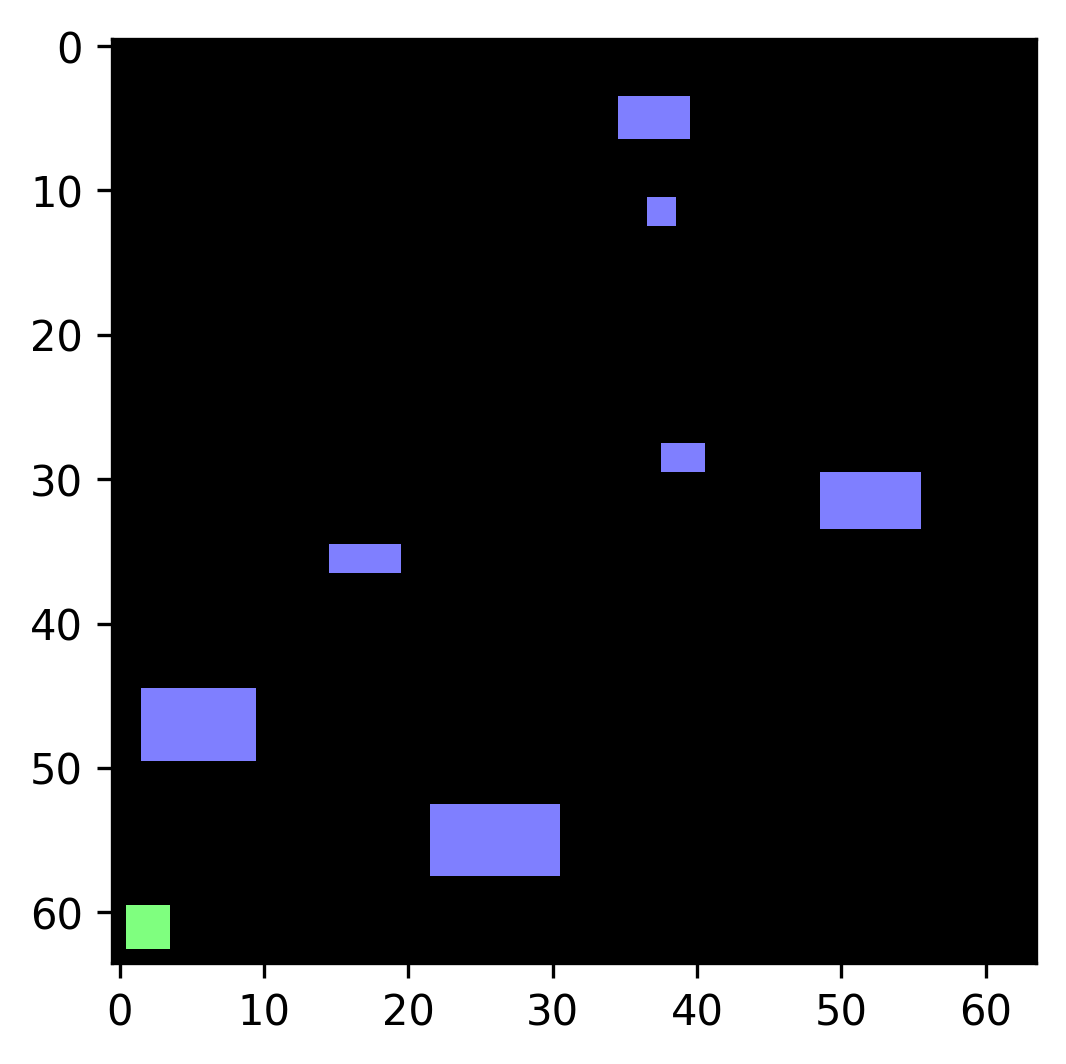

(3, 64, 64)


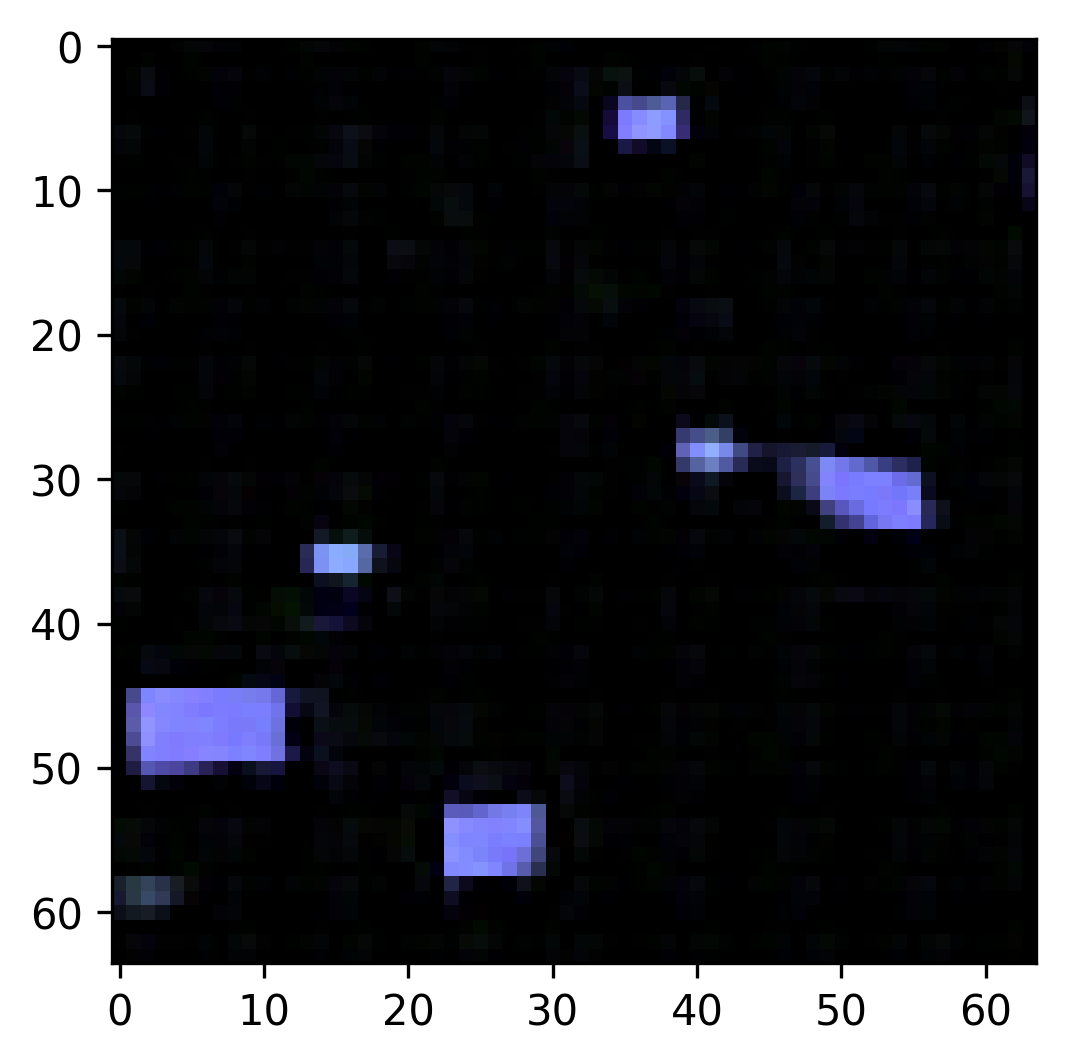

21
repr, std, cov, conv, closs 0.682214617729187 0.476806640625 3.4847529605031013e-05 0.004981963895261288 0.24280166625976562
32.933670063361376 0.007242662312881676 1.0
repr, std, cov, conv, closs 0.6703972220420837 0.47607421875 4.007178358733654e-05 0.004589974880218506 0.24439150094985962
33.33105498808153 0.007300806812025965 1.0
repr, std, cov, conv, closs 0.6488550901412964 0.47509765625 4.6454137191176414e-05 0.004145694896578789 0.26094913482666016
32.28186230518928 0.007070992511544726 1.0
repr, std, cov, conv, closs 0.6368605494499207 0.47509765625 4.588766023516655e-05 0.004332402721047401 0.24781131744384766
31.70627237318718 0.006944915767259338 1.0
repr, std, cov, conv, closs 0.6545224785804749 0.475830078125 4.136841744184494e-05 0.004366315435618162 0.2420663833618164
31.07875669467942 0.006793870714957649 1.0
repr, std, cov, conv, closs 0.6415613293647766 0.475341796875 4.340102896094322e-05 0.0040009962394833565 0.24931550025939941
30.80044131582782 0.0066927733195

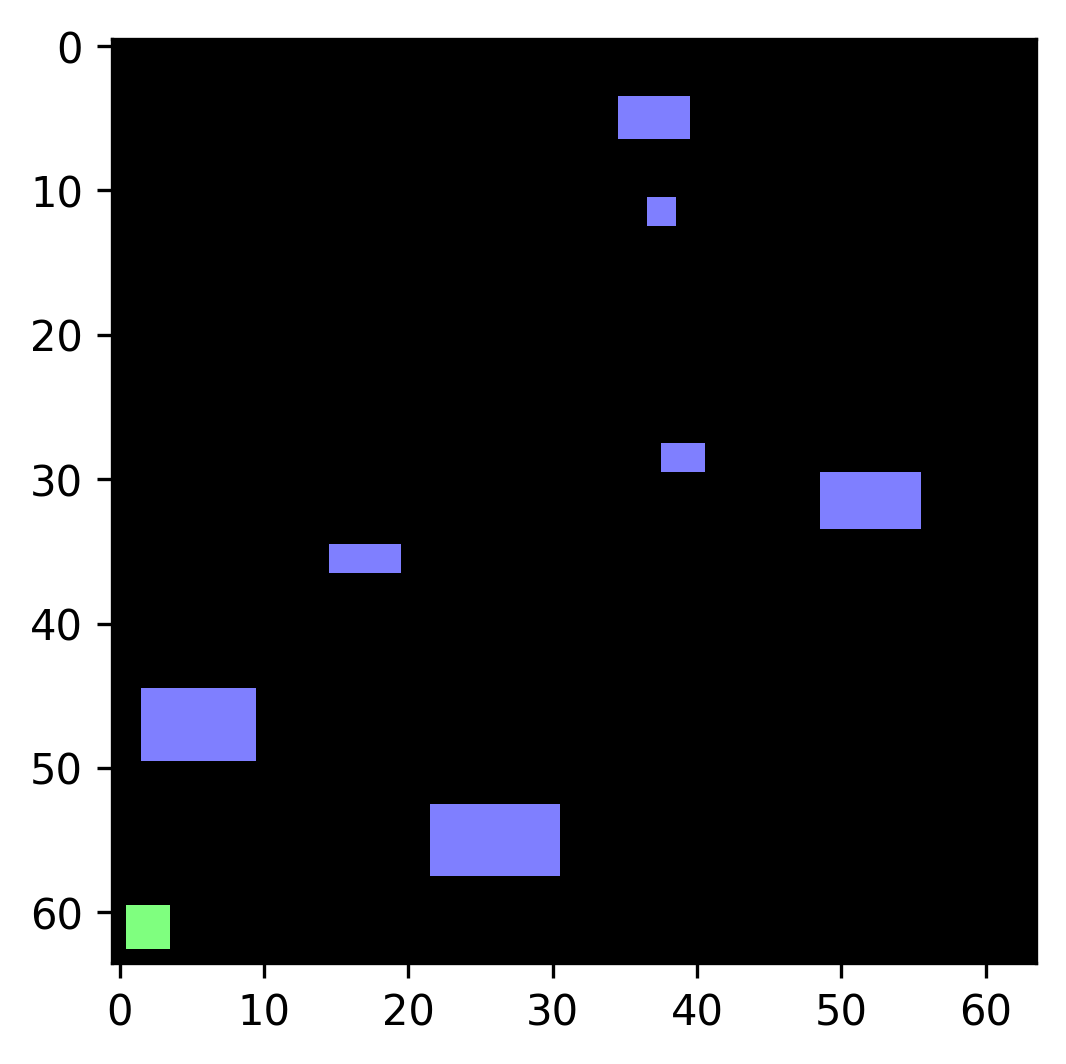

(3, 64, 64)


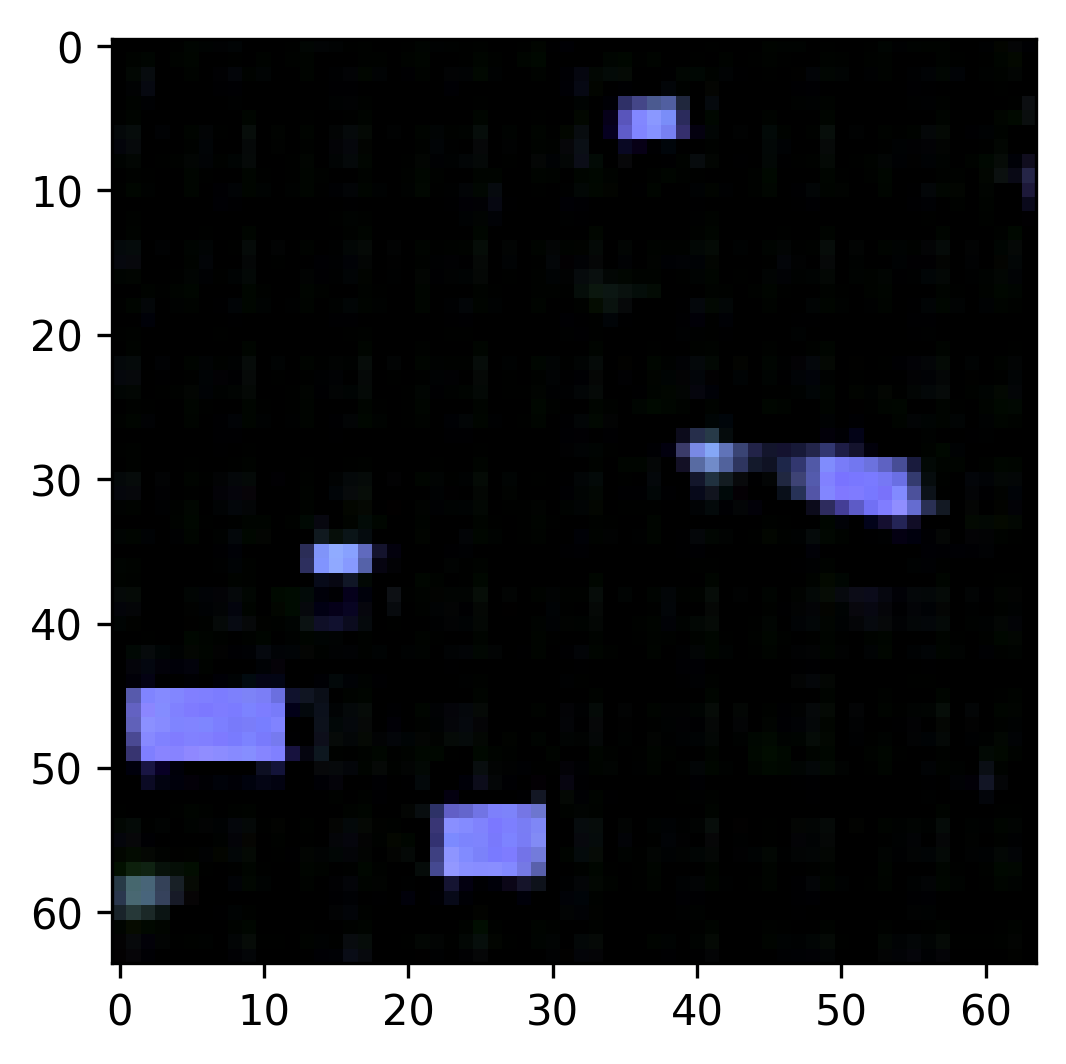

22
repr, std, cov, conv, closs 0.6308321952819824 0.476806640625 3.459164872765541e-05 0.004254503175616264 0.2442171573638916
30.76967164418364 0.006910295119572773 1.0
repr, std, cov, conv, closs 0.656109094619751 0.4775390625 3.067869693040848e-05 0.0040438128635287285 0.2499849796295166
30.892935071899682 0.00703574336688402 1.0
repr, std, cov, conv, closs 0.6541041135787964 0.477783203125 2.8725480660796165e-05 0.004218062851577997 0.2461862564086914
31.865121114998118 0.007264412035049919 1.0
repr, std, cov, conv, closs 0.6436682343482971 0.476806640625 3.448384813964367e-05 0.0042847939766943455 0.2547914981842041
32.024765690594805 0.007396288856773863 1.0
repr, std, cov, conv, closs 0.6320095062255859 0.47607421875 4.044361412525177e-05 0.004057507961988449 0.2527487277984619
31.07875669467942 0.007344721311125988 1.0
repr, std, cov, conv, closs 0.639028787612915 0.475830078125 4.096166230738163e-05 0.0037684456910938025 0.24726200103759766
30.524618296978467 0.007213763945653

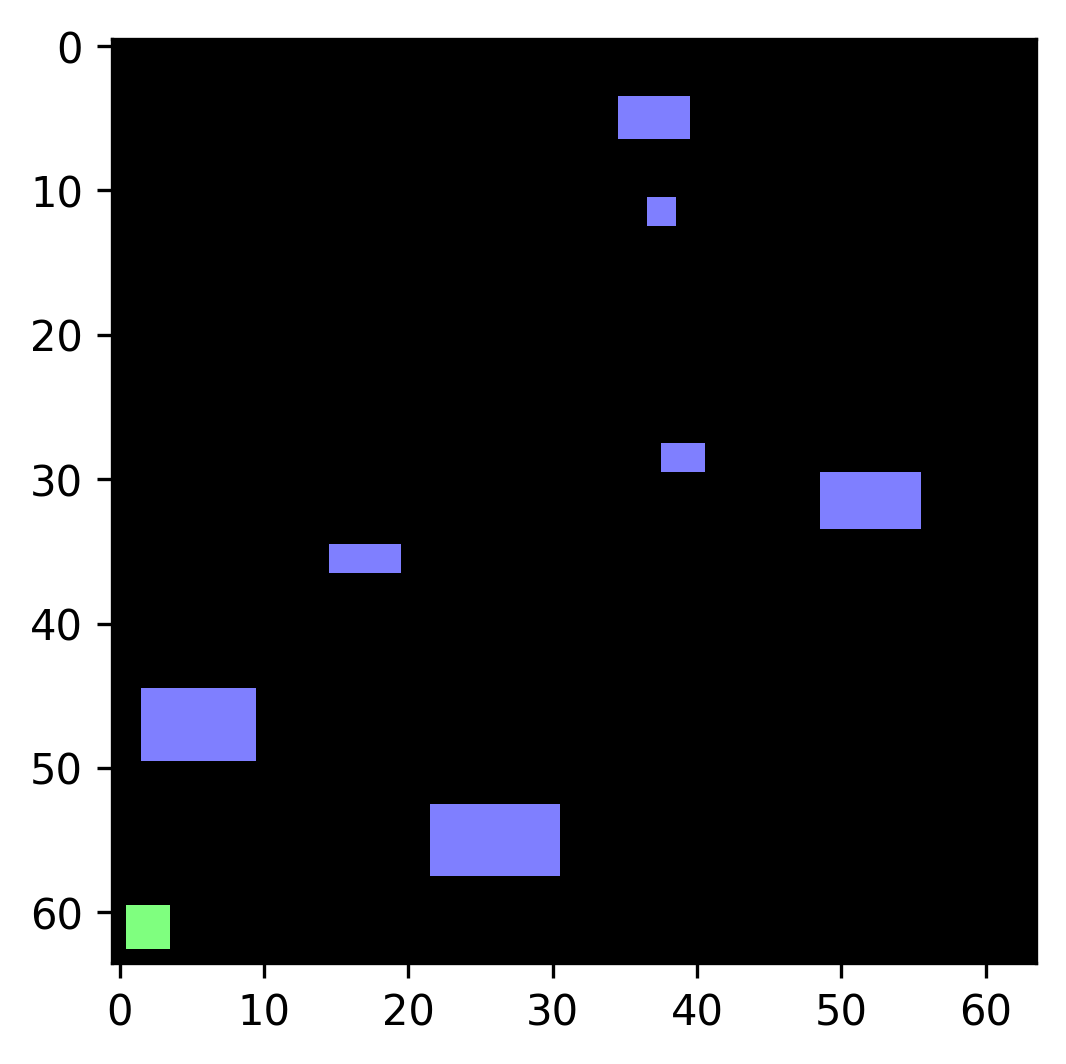

(3, 64, 64)


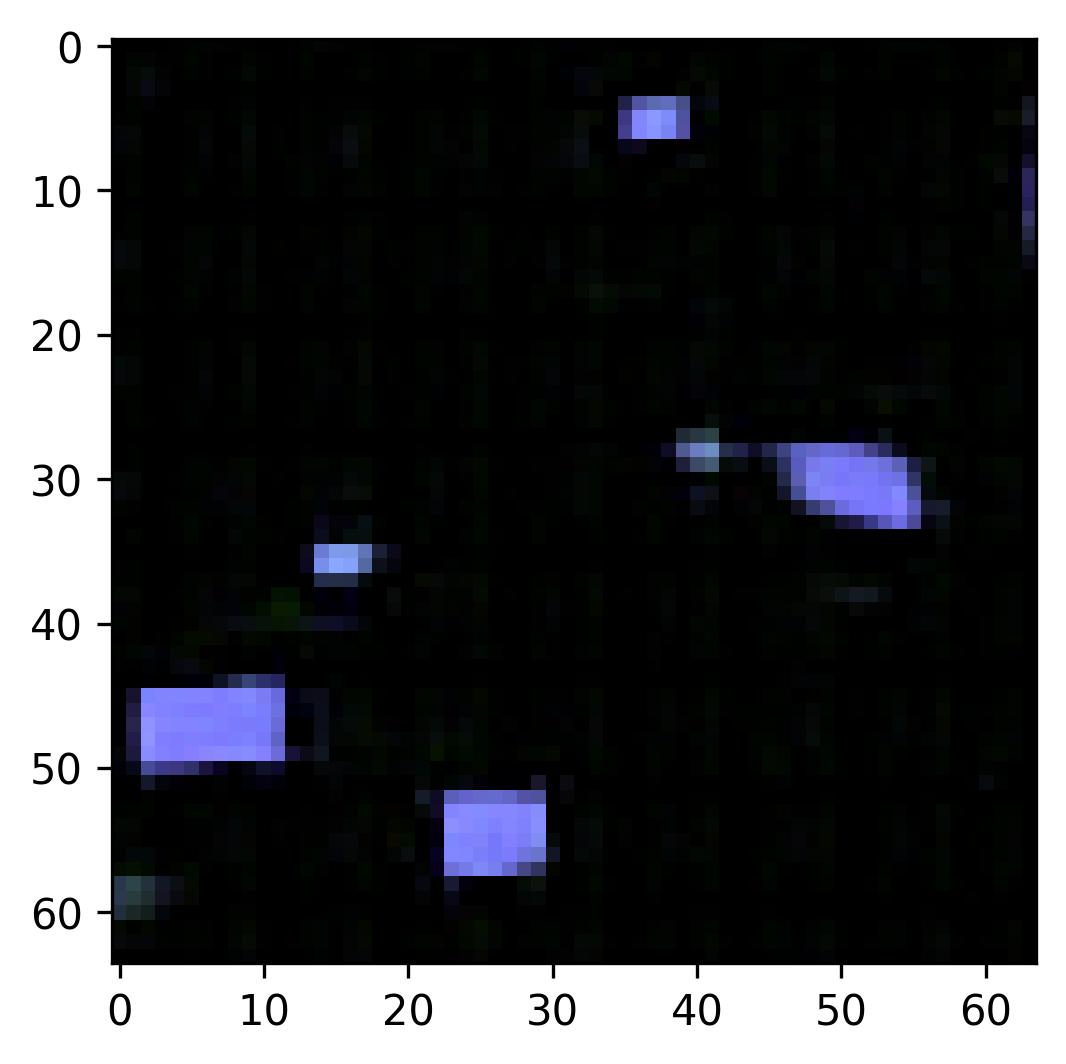

23
repr, std, cov, conv, closs 0.6581671237945557 0.475830078125 4.2199622839689255e-05 0.005024727433919907 0.2491607666015625
31.960812105571566 0.006875847057024229 1.0
repr, std, cov, conv, closs 0.6844222545623779 0.475830078125 4.16820403188467e-05 0.004448459949344397 0.25042057037353516
32.24961269249678 0.0068621159629823035 1.0
repr, std, cov, conv, closs 0.6597057580947876 0.47607421875 3.829505294561386e-05 0.004881053697317839 0.2556898593902588
32.54102290582113 0.006972737127609584 1.0
repr, std, cov, conv, closs 0.660437822341919 0.476318359375 3.773230127990246e-05 0.004689787048846483 0.252147912979126
32.7694945677183 0.00707806350405627 1.0
repr, std, cov, conv, closs 0.6642318964004517 0.4765625 3.5912031307816505e-05 0.004377366974949837 0.2482004165649414
33.56507349290704 0.007293513298727238 1.0
repr, std, cov, conv, closs 0.6744382977485657 0.4765625 3.528059460222721e-05 0.0045652627013623714 0.2538766860961914
34.174407764121014 0.007425918419526648 1.0
repr

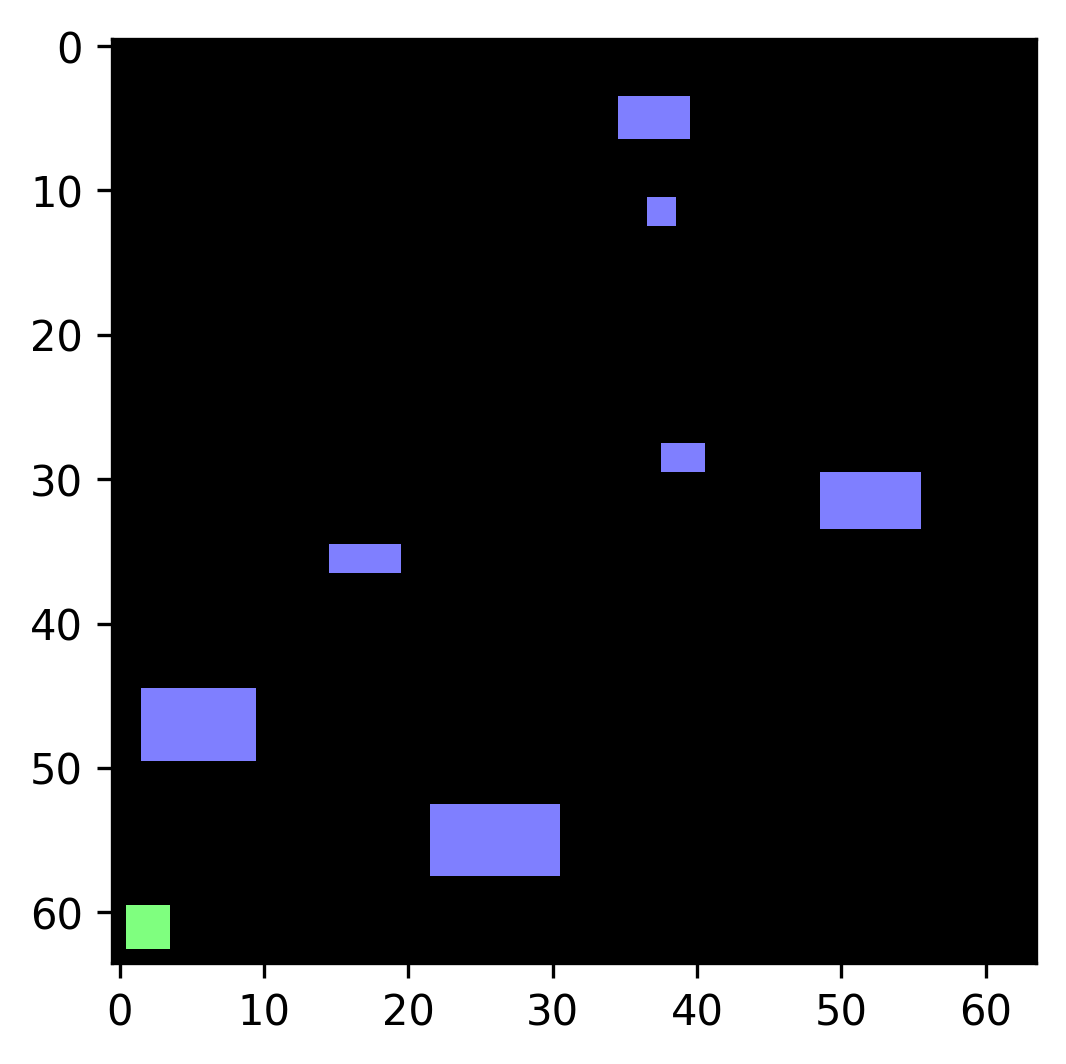

(3, 64, 64)


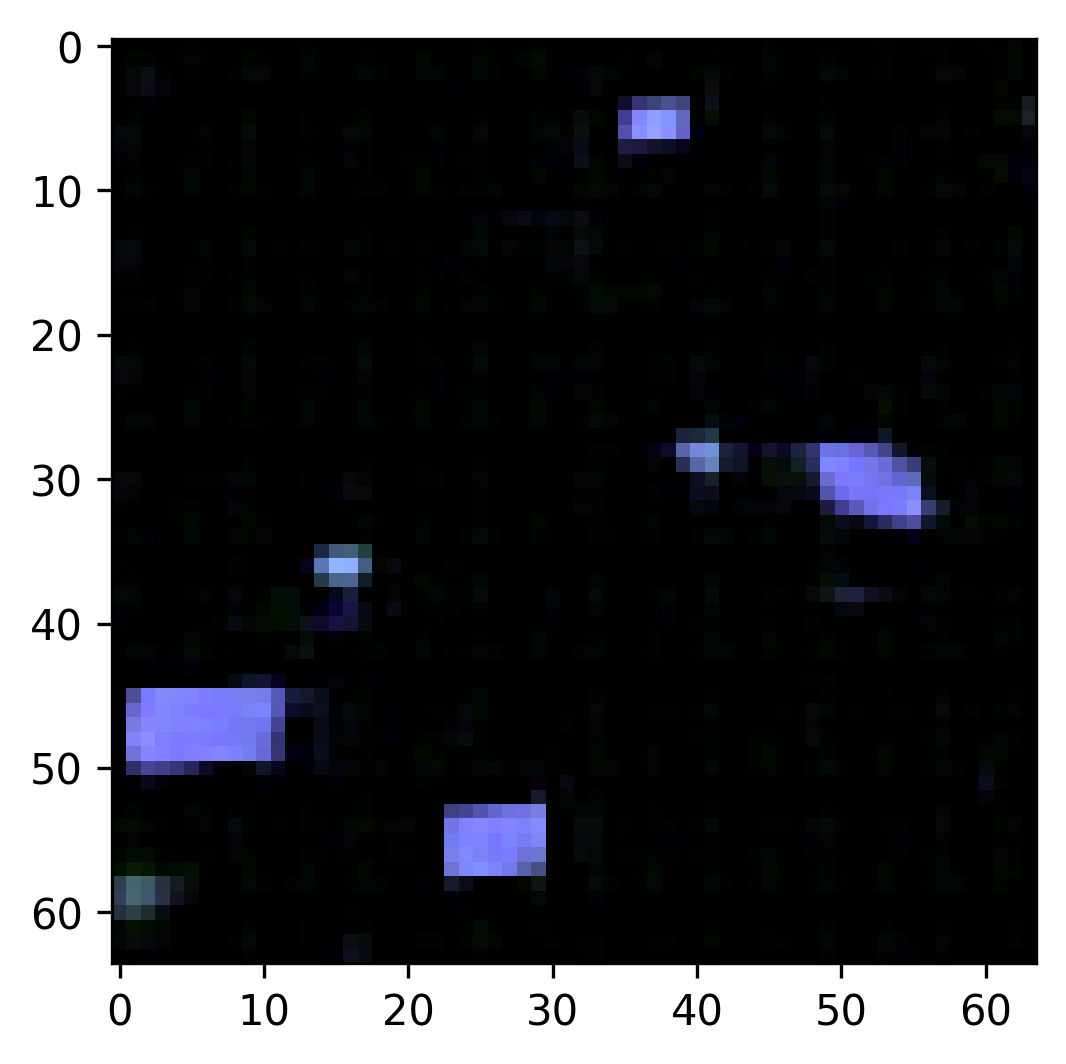

24
repr, std, cov, conv, closs 0.6708152294158936 0.47607421875 4.016305319964886e-05 0.004480339586734772 0.2501869201660156
34.31131057835588 0.0070287146522317896 1.0
repr, std, cov, conv, closs 0.6569077968597412 0.475341796875 4.459568299353123e-05 0.00385445449501276 0.25019222497940063
34.174407764121014 0.0069033917278449285 1.0
repr, std, cov, conv, closs 0.6938005089759827 0.476318359375 3.856094554066658e-05 0.004702531732618809 0.2500009536743164
34.48321058763812 0.006807465250258278 1.0
repr, std, cov, conv, closs 0.7072725296020508 0.476806640625 3.42121347784996e-05 0.004921925254166126 0.24977707862854004
35.10921255355001 0.0069310467427271425 1.0
repr, std, cov, conv, closs 0.6593594551086426 0.4755859375 4.2607076466083527e-05 0.004432409070432186 0.25017642974853516
34.379967510823164 0.006726304180889895 1.0
repr, std, cov, conv, closs 0.6713860034942627 0.4755859375 4.395912401378155e-05 0.004383796826004982 0.2506875991821289
34.00404714770053 0.0066262122212959

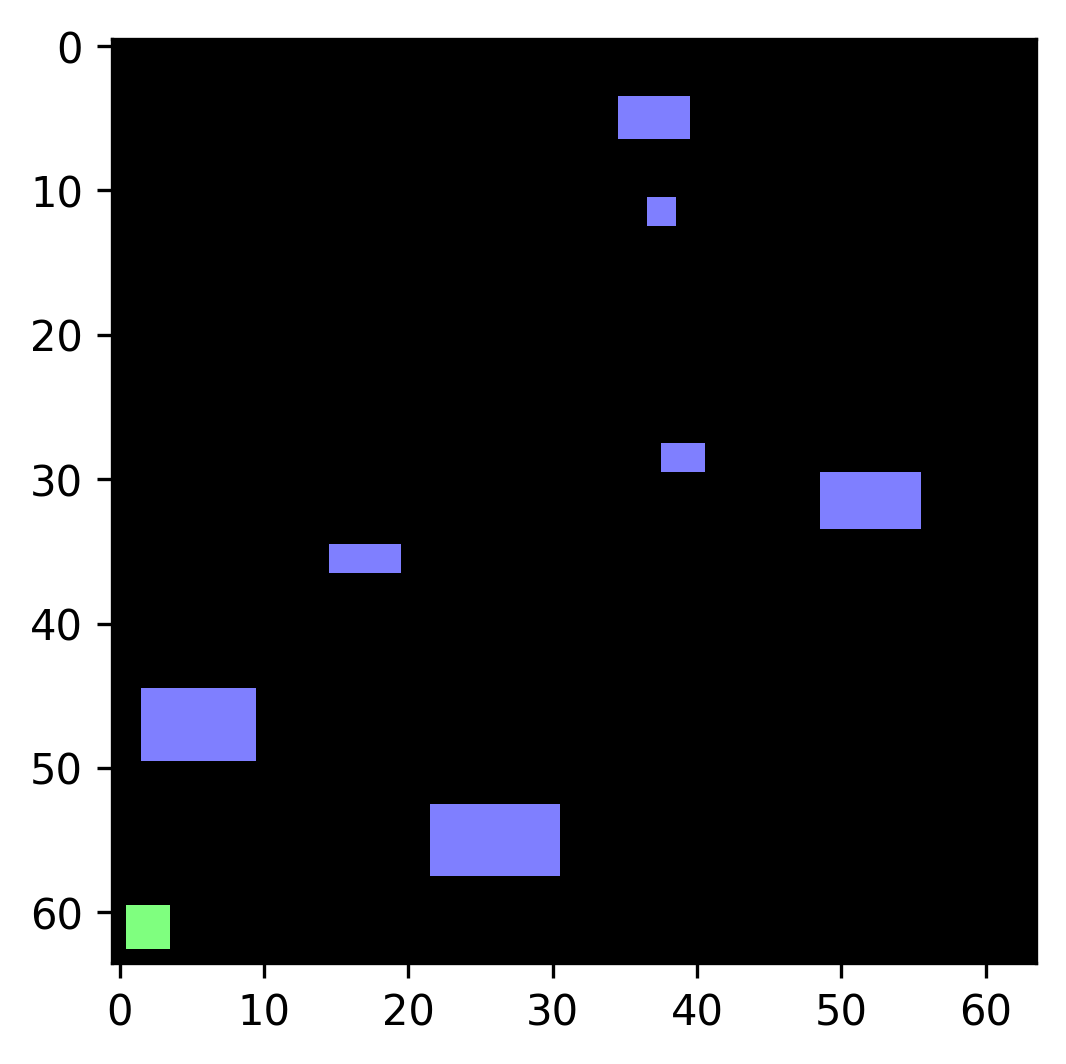

(3, 64, 64)


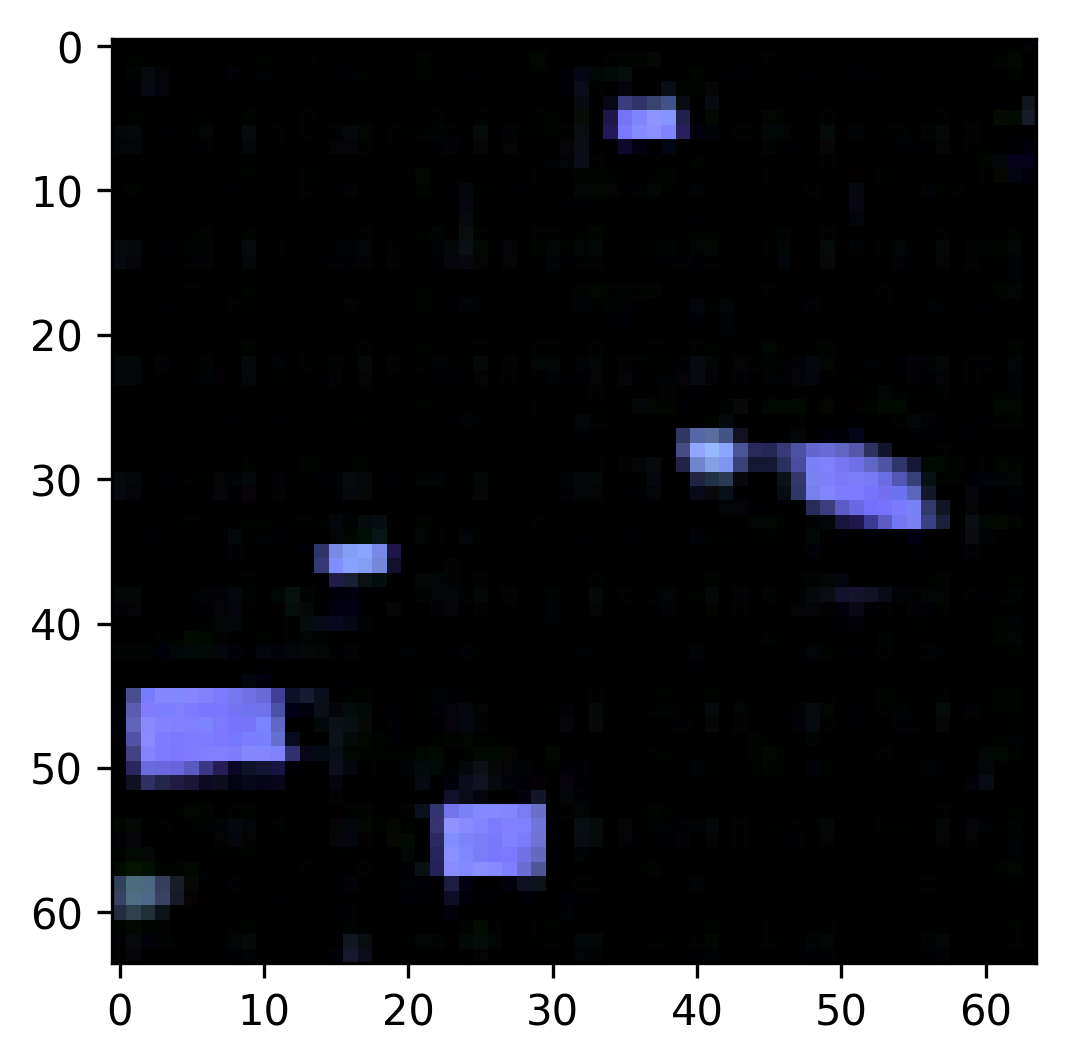

25
repr, std, cov, conv, closs 0.6466717720031738 0.4765625 3.738538362085819e-05 0.004200929310172796 0.25005632638931274
35.6751927851246 0.007206557388264859 1.0
repr, std, cov, conv, closs 0.6626331806182861 0.476806640625 3.531016409397125e-05 0.0043702078983187675 0.25
35.497350702951806 0.007293513298727238 1.0
repr, std, cov, conv, closs 0.6501994132995605 0.476318359375 3.923429176211357e-05 0.0050058504566550255 0.24986481666564941
35.497350702951806 0.007485534108970263 1.0
repr, std, cov, conv, closs 0.6551647186279297 0.47607421875 3.977073356509209e-05 0.004421934485435486 0.24969124794006348
34.86442818180957 0.007418499919607042 1.0
repr, std, cov, conv, closs 0.6149519681930542 0.4765625 3.742240369319916e-05 0.004198148380964994 0.25103211402893066
33.83453578490362 0.007228198687308373 1.0
repr, std, cov, conv, closs 0.6689956784248352 0.475830078125 4.04994934797287e-05 0.004607300739735365 0.25028252601623535
33.59863856639994 0.007127758835898346 1.0
repr, std, co

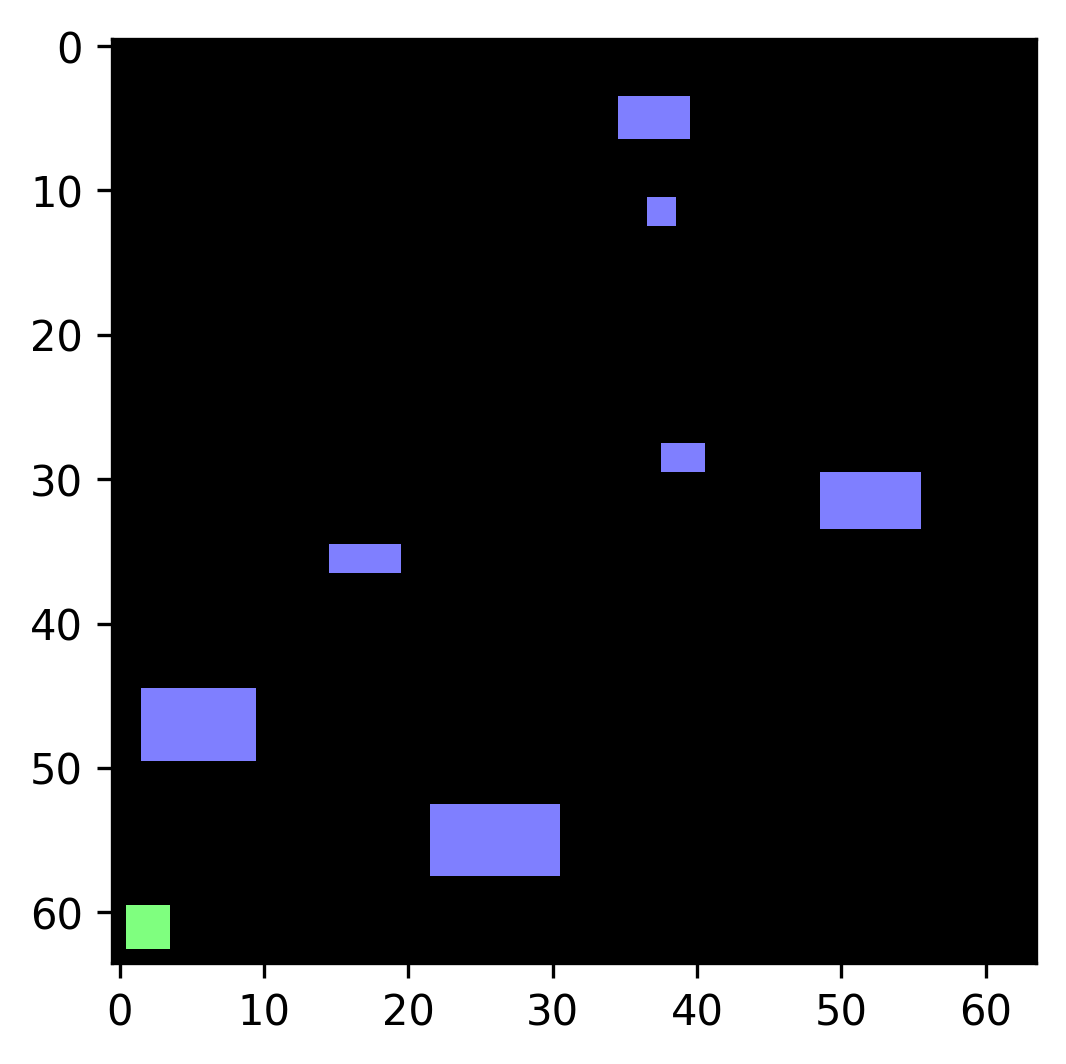

(3, 64, 64)


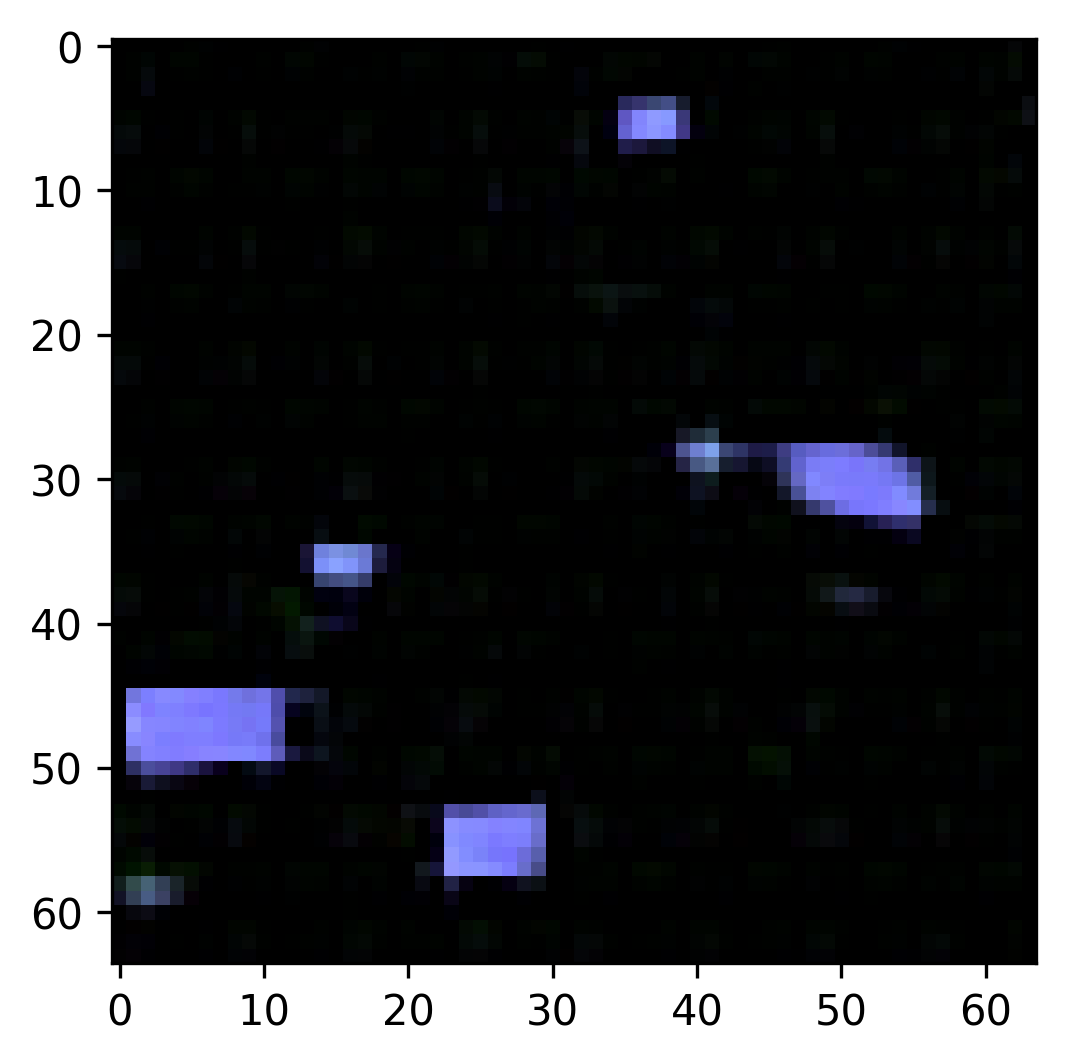

26
repr, std, cov, conv, closs 0.6392683386802673 0.476318359375 3.9341626688838005e-05 0.004350253846496344 0.24799638986587524
33.766968081772 0.007042779110250904 1.0
repr, std, cov, conv, closs 0.6562751531600952 0.475830078125 4.074978642165661e-05 0.004897088743746281 0.24797016382217407
33.56507349290704 0.007014678280991527 1.0
repr, std, cov, conv, closs 0.6610747575759888 0.4765625 3.7581659853458405e-05 0.004965839441865683 0.2589263916015625
34.03805119484823 0.00699367626417653 1.0
repr, std, cov, conv, closs 0.6833606958389282 0.476318359375 3.822054713964462e-05 0.0050824605859816074 0.24690967798233032
34.655971817686726 0.007113524673027619 1.0
repr, std, cov, conv, closs 0.6476739048957825 0.476318359375 3.715371713042259e-05 0.004600202664732933 0.2573280334472656
34.140267496624396 0.0070993189358370115 1.0
repr, std, cov, conv, closs 0.6605548858642578 0.475830078125 3.995443694293499e-05 0.004621214233338833 0.2538681626319885
33.73323484692508 0.00701467828099152

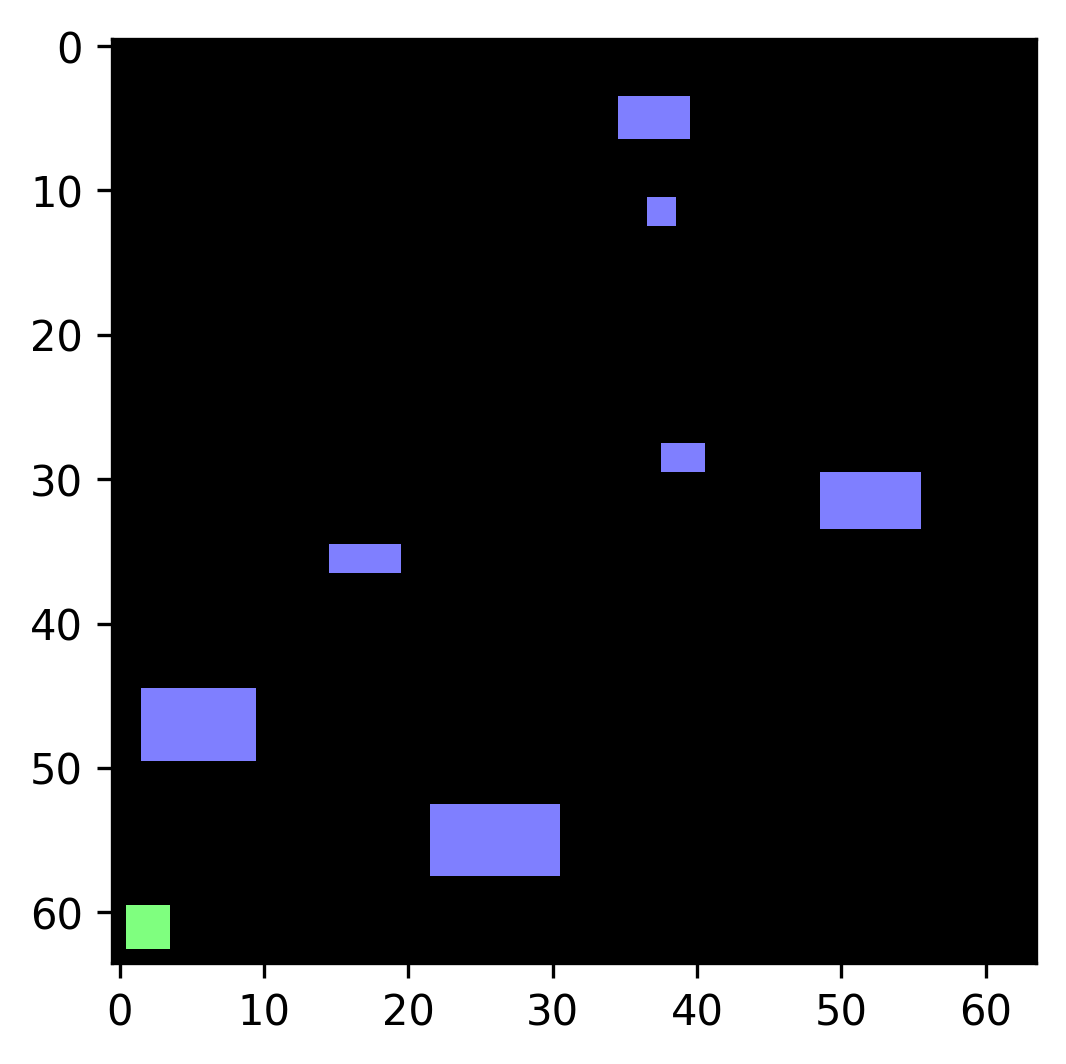

(3, 64, 64)


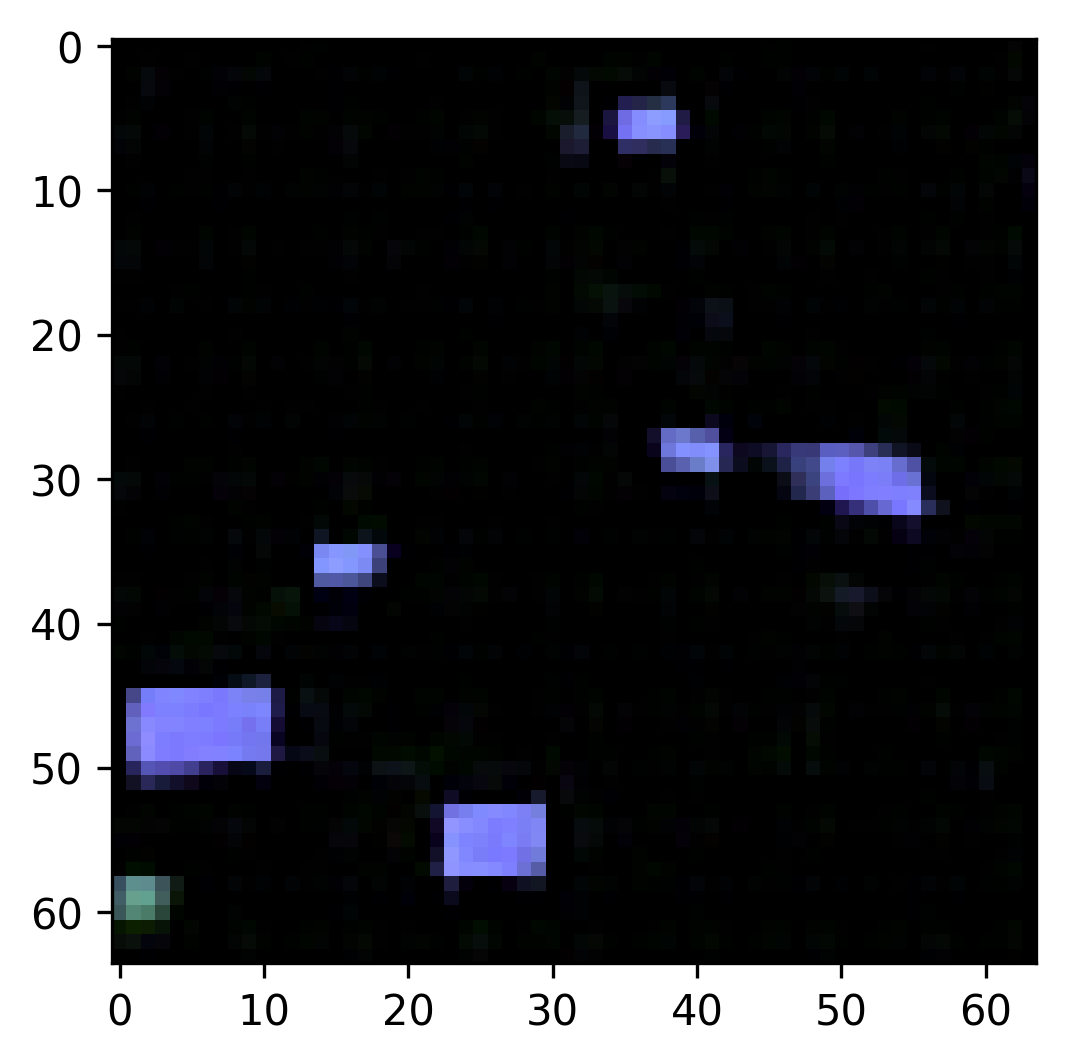

27
repr, std, cov, conv, closs 0.6465597152709961 0.475830078125 4.079518839716911e-05 0.004403979517519474 0.25063538551330566
32.37880476997361 0.00663947127195077 1.0
repr, std, cov, conv, closs 0.6345111131668091 0.4755859375 4.361709579825401e-05 0.004258392844349146 0.24911880493164062
32.508514391429706 0.006626212221295958 1.0
repr, std, cov, conv, closs 0.6291837692260742 0.476318359375 3.977096639573574e-05 0.0044209035113453865 0.24942547082901
33.26449273811258 0.006787083631326324 1.0
repr, std, cov, conv, closs 0.630976140499115 0.47607421875 4.0764687582850456e-05 0.004033014178276062 0.24908447265625
33.0656024774028 0.006834735983287479 1.0
repr, std, cov, conv, closs 0.6292032599449158 0.47607421875 3.954046405851841e-05 0.004545922391116619 0.2515783905982971
32.933670063361376 0.0069588125437096224 1.0
repr, std, cov, conv, closs 0.6433452367782593 0.4765625 3.6833109334111214e-05 0.004215193912386894 0.2510108947753906
32.54102290582113 0.0069657713562533315 1.0
re

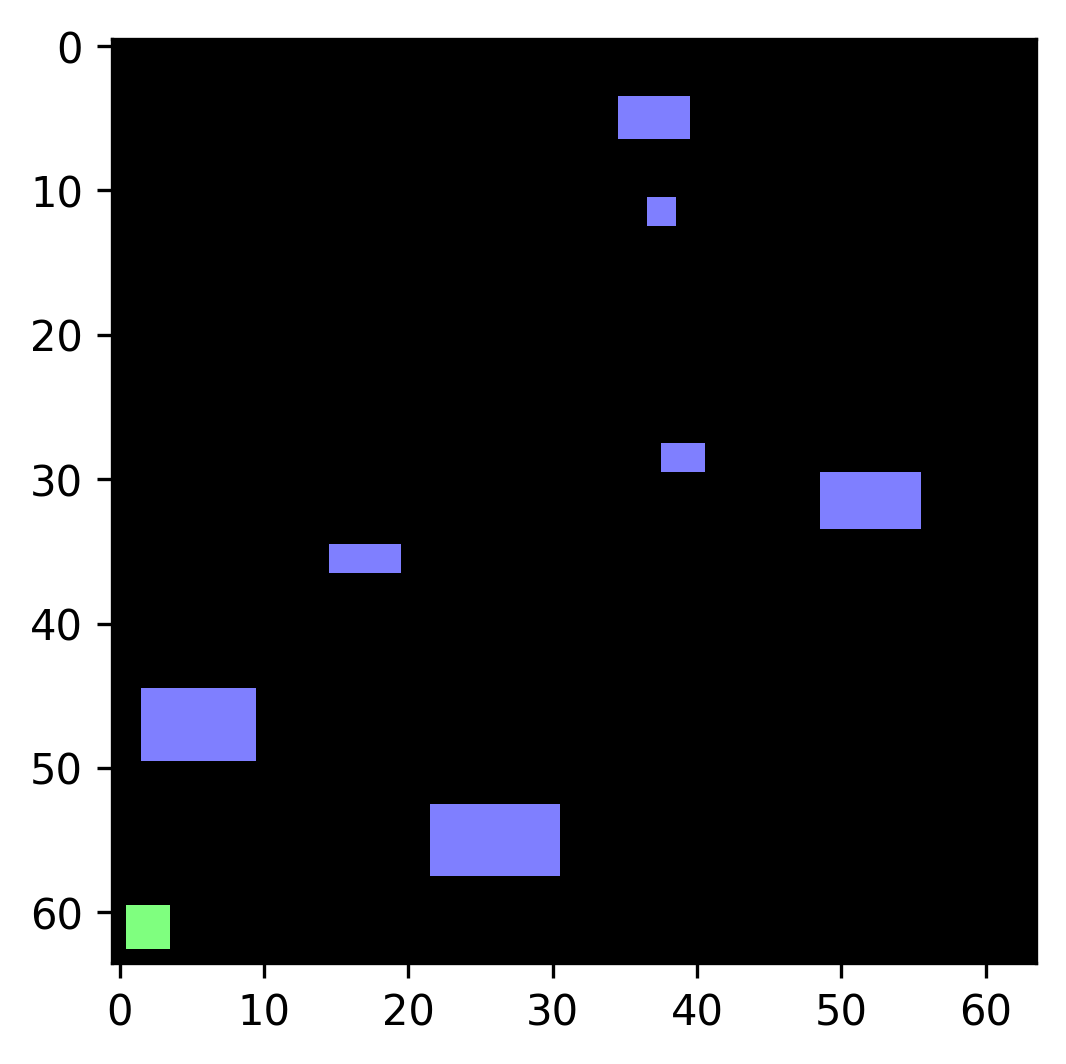

(3, 64, 64)


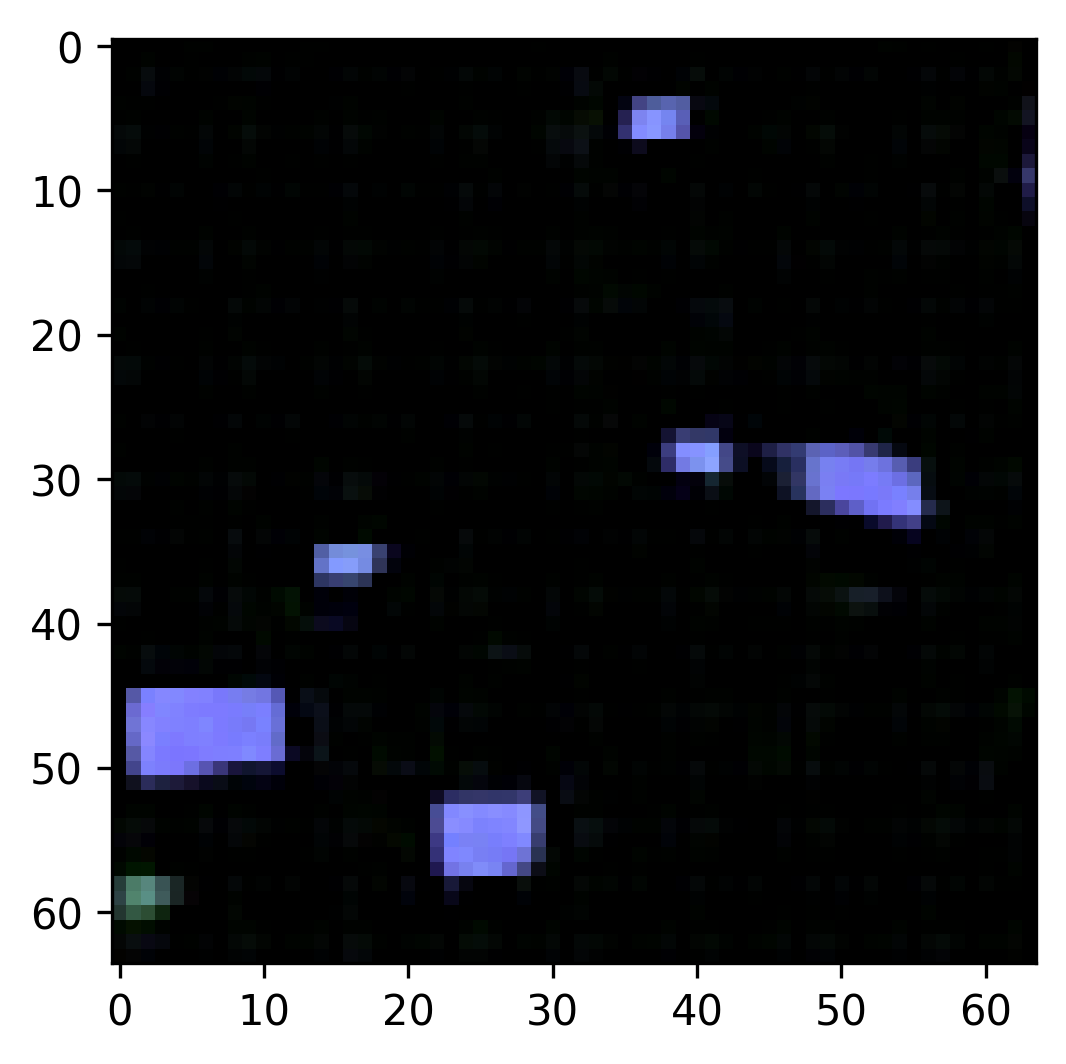

28
repr, std, cov, conv, closs 0.6491663455963135 0.477294921875 3.110244870185852e-05 0.004483268596231937 0.2495269775390625
32.1530570300824 0.007228198687308373 1.0
repr, std, cov, conv, closs 0.6590026617050171 0.477294921875 3.1736912205815315e-05 0.00450421217828989 0.25021082162857056
32.63874363014832 0.007359418098469549 1.0
repr, std, cov, conv, closs 0.6511964797973633 0.47607421875 3.877771086990833e-05 0.004723863210529089 0.2499849796295166
32.86790139267464 0.007418499919607042 1.0
repr, std, cov, conv, closs 0.6413524150848389 0.47607421875 4.0628015995025635e-05 0.004295335151255131 0.25055789947509766
32.63874363014832 0.0072862270716555835 1.0
repr, std, cov, conv, closs 0.626625657081604 0.4755859375 4.3945154175162315e-05 0.003646367695182562 0.2503321170806885
31.611343477114076 0.007056871711250514 1.0
repr, std, cov, conv, closs 0.6282714605331421 0.474853515625 4.900735802948475e-05 0.003563155187293887 0.24973392486572266
31.07875669467942 0.00693104674272714

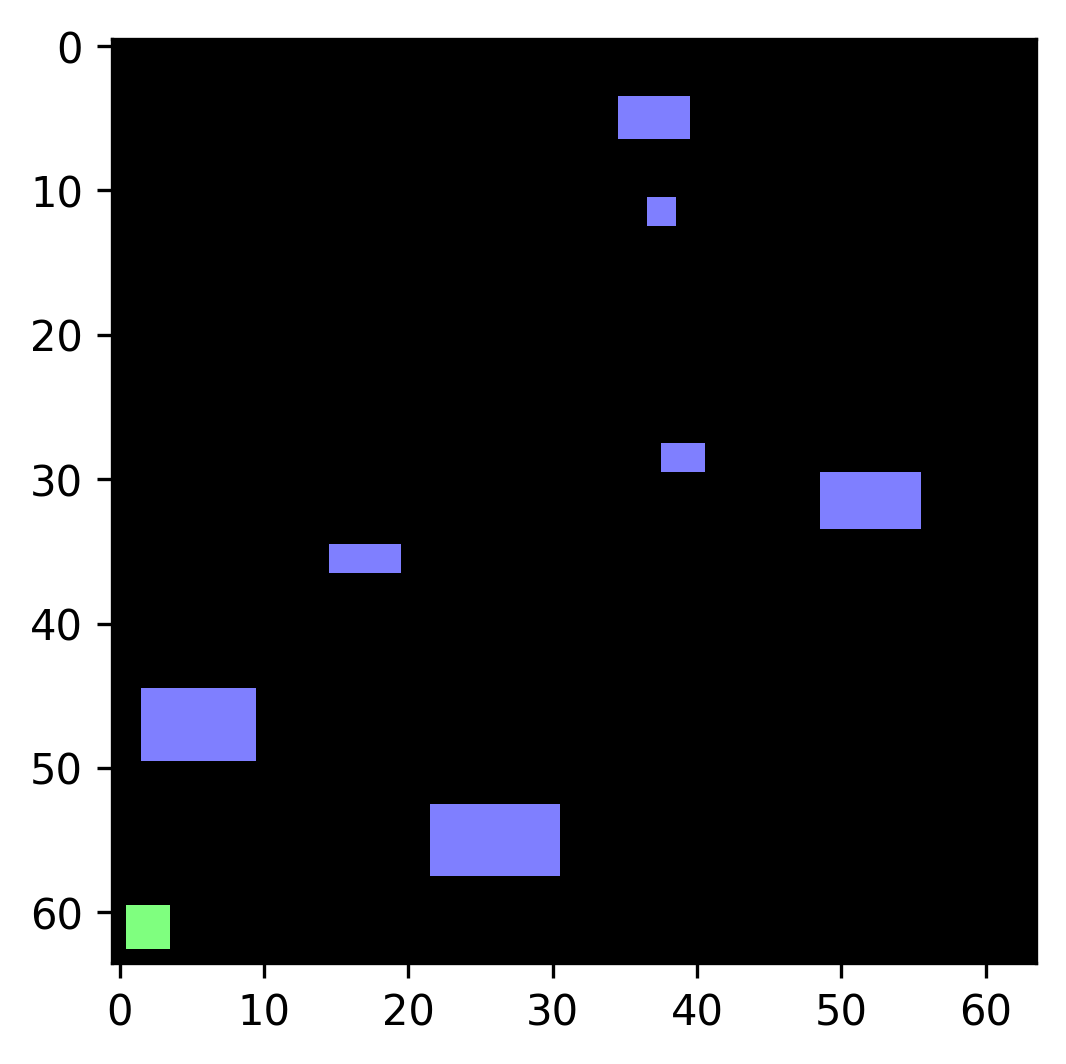

(3, 64, 64)


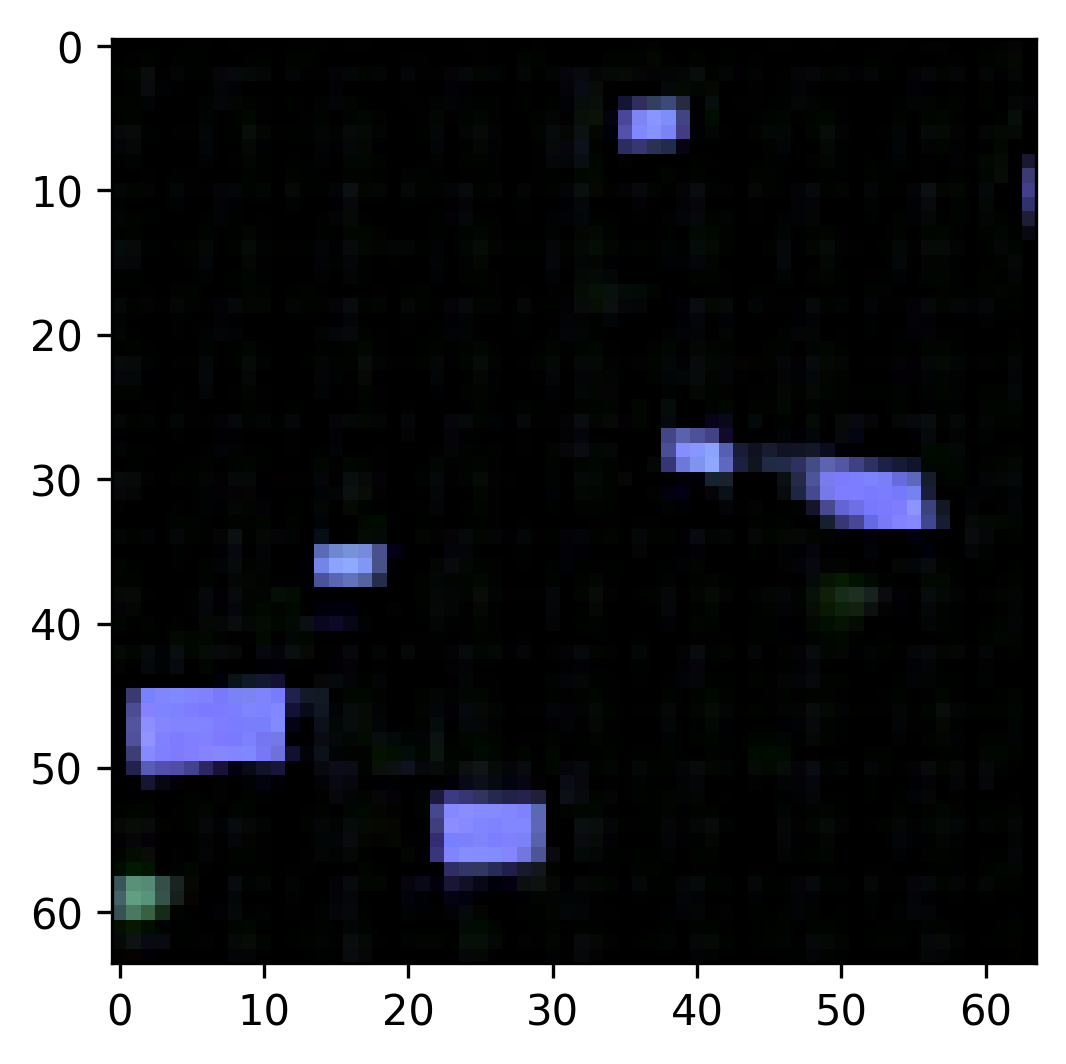

29
repr, std, cov, conv, closs 0.6484042406082153 0.4755859375 4.352233372628689e-05 0.004395300056785345 0.252197265625
32.1530570300824 0.006652756853965942 1.0
repr, std, cov, conv, closs 0.6432026028633118 0.4755859375 4.492094740271568e-05 0.0037526097148656845 0.250732421875
31.801486340830124 0.006547212116268346 1.0
repr, std, cov, conv, closs 0.6629042625427246 0.47607421875 3.9360253140330315e-05 0.005012392997741699 0.2479257583618164
32.346458311661955 0.006632838433517254 1.0
repr, std, cov, conv, closs 0.64328932762146 0.476318359375 3.6939745768904686e-05 0.004910098388791084 0.2511751651763916
32.8350663263483 0.00675324978235048 1.0
repr, std, cov, conv, closs 0.6364550590515137 0.476806640625 3.428524360060692e-05 0.005136797204613686 0.2515878677368164
33.198063413222734 0.0069588125437096224 1.0
repr, std, cov, conv, closs 0.6193294525146484 0.476318359375 3.8501573726534843e-05 0.003933703061193228 0.25058579444885254
32.933670063361376 0.0070287146522317896 1.0
re

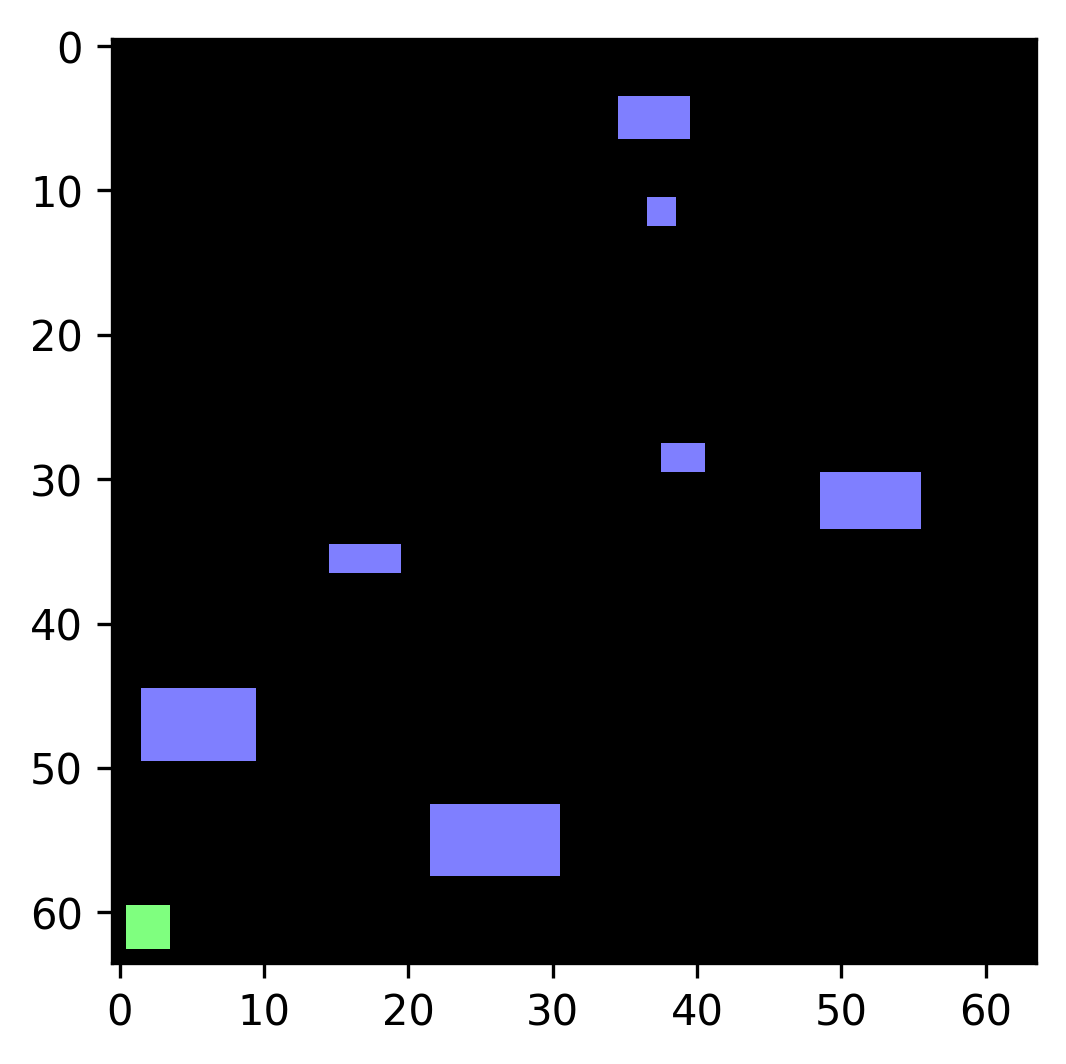

(3, 64, 64)


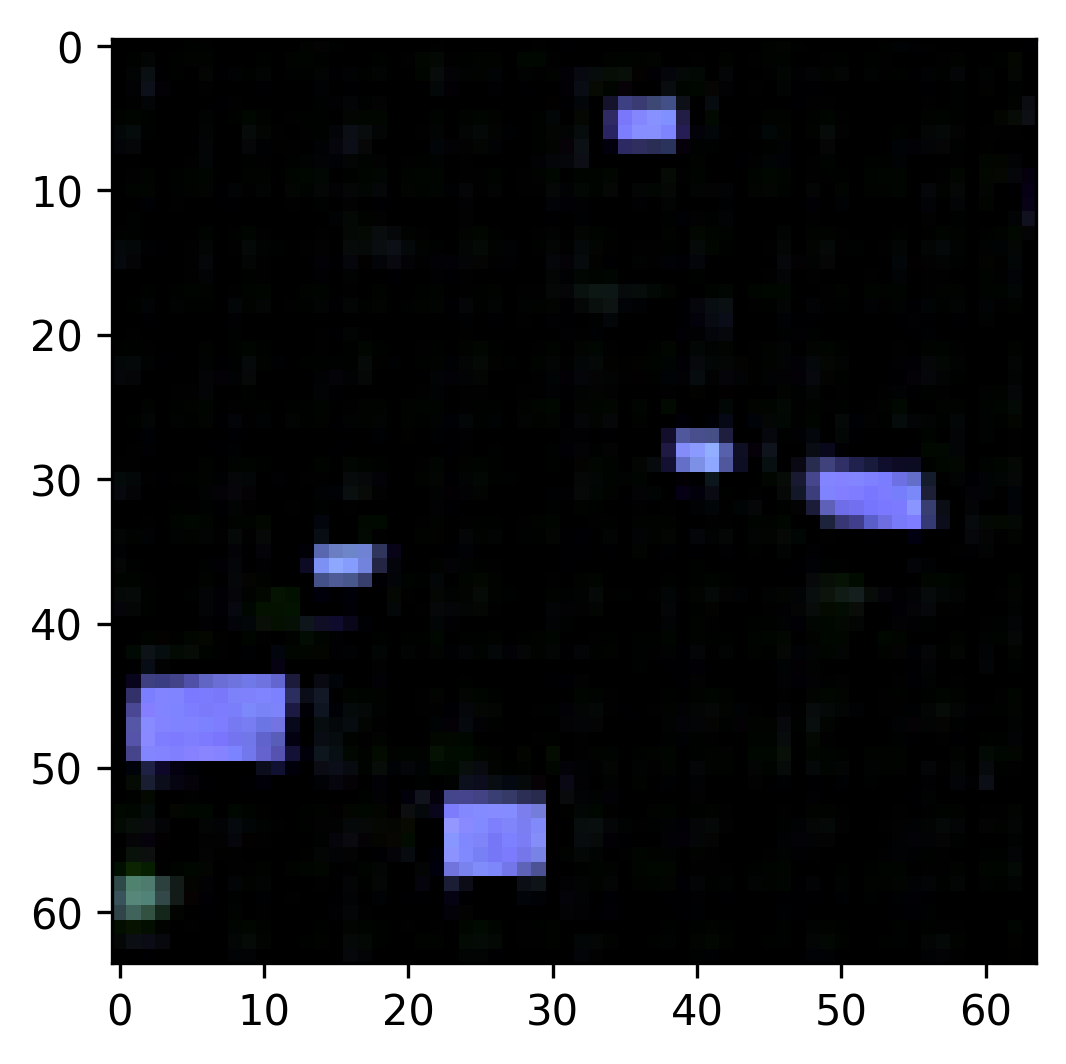

In [ ]:
# @title wwwwwwwwwwww
from matplotlib import pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(4, 4))
    print(npimg.shape)
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

import torchvision.transforms.v2 as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


for i in range(30):
    print(i)
    # agent.train_ae(train_loader, optim)
    # agent.train_jepa(train_loader, optim)
    agent.train_jepa(train_loader, c_loader, optim)

    state = buffer[7][80][0]
    state = transform(state).unsqueeze(0).to(device)[0]
    sx_ = agent.jepa.enc(state.unsqueeze(0))
    out= agent.deconv(sx_).squeeze(0)
    print(out.shape)
    imshow(state.detach().cpu())
    imshow(out.detach().cpu())

# 10 epochs 15m23s


In [ ]:
state = buffer[7][80][0]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
state = transform(state).unsqueeze(0).to(device)[0]
sx_ = agent.jepa.enc(state.unsqueeze(0))
out= agent.deconv(sx_).squeeze(0)
print(out.shape)
imshow(state.detach().cpu())
imshow(out.detach().cpu())

In [ ]:
# @title simulate 4
from google.colab.patches import cv2_imshow
import cv2
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# buffer=[]

def simulate(agent, buffer=[]):
    # out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    out = cv2.VideoWriter('video{}.avi'.format(time.time()), cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    state = env.reset()
    episode=[]
    act=[]
    while True:
    # while not done:
        state = transform(state).unsqueeze(0).to(device)
        # action = agent(state).cpu() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        if len(act)<=0: act = agent(state).cpu()[:1].tolist()
        action = act.pop(0)
        state, reward, done, info = env.step(action) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
        # print(i, 'act: ',action.item(), 'reward: ',reward)
        out.write(state)
        if done:
            episode.append((state, action, -1))
            print("ded")
            break
        episode.append((state, action, 0))
    print('time')
    env.close()
    out.release()
    cv2.destroyAllWindows()
    buffer.append(episode)
    return buffer

buffer = simulate(agent, buffer)
# _=simulate(agent)



In [ ]:
# @title wwwwwwwwwwww
for i in range(10):
    # # buffer=[]
    # print("#### simulate ####")
    # buffer = simulate(agent, buffer)

    print(i,"#### train ####")
    # train_data = BufferDataset(buffer, seq_len) # one line of poem is roughly 50 characters
    # train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4
    agent.train_jepa(train_loader, optim)

# repr, std, cov 0.009419754147529602 0.478271484375 0.005037273280322552


In [ ]:
!ffmpeg -hide_banner -loglevel error -i video.avi video.mp4 -y
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4', "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""<video width=400 controls autoplay><source src="{data_url}" type="video/mp4"></video>""")

###save

In [ ]:
# @title test search, argm
# # def search(self, sx, T=None, bptt=None):
T=20
bptt=None
if T==None: T = 256
if bptt==None: bptt = min(T,32)
d_model=agent.d_model
# sx=torch.randn((1, d_model), device=device)
# batch=sx.size(dim=0)
batch=32
# scale = torch.sqrt(torch.tensor((d_model,), device=device))

# x_ = torch.rand((batch, T, 3),device=device)
# x_ = torch.rand((batch, T, 3),device=device)*4 -2
# x_ = torch.rand((batch, T, 3),device=device)*3 -1.5
# x_ = torch.rand((batch, T, 3),device=device)*2 -1
# *self.dim_z**(-0.5) # 1/d^(1/2)
# x_ = torch.zeros((batch, T, 3),device=device) # dont, deterministic, stuck
x=nn.Parameter(x_.clone())
# optim = torch.optim.SGD([x], lr=1e3, momentum=0.9)
optim = torch.optim.SGD([x], lr=1e2)
optim = torch.optim.SGD([x], lr=1e5)
# optim = torch.optim.SGD([x], lr=3e2)
# optim = torch.optim.AdamW([x], lr=3e2)
# optim = torch.optim.AdamW([x], lr=1e5)

# xx = torch.split(x, bptt, dim=1)
# for _ in range(10): # num epochs
#     sx_ = sx.detach()
#     # print(sx_[0][:10])
#     for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
#         la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
#         print(lact)
#         loss, sx_ = agent.rnn_pred(sx_, la)
#         loss.backward()
#         optim.step()
#         optim.zero_grad()
#         sx_ = sx_.detach()
#         print("search",loss.item())


# argm
# sx = torch.rand((batch, d_model),device=device)*2 -1
# sy = torch.rand((batch, d_model),device=device)*2 -1
# a = torch.rand((batch, agent.dim_a),device=device)*2 -1
# z_ = torch.rand((batch, agent.dim_z),device=device)*2 -1
# # z_ = torch.rand((batch, agent.dim_z),device=device)
# # z_ = z_/scale

z=nn.Parameter(z_.clone()) # argm 0.38188403844833374 3.86767578125
# torch.nn.init.zeros_(z)
torch.nn.init.xavier_uniform_(z)
# print(z)
# optim = torch.optim.SGD([z], lr=1e2, momentum=0.9)
# optim = torch.optim.SGD([z], lr=1e4)
optim = torch.optim.SGD([z], lr=3e3)
# optim = torch.optim.SGD([z], lr=3e1)
# optim = torch.optim.AdamW([z], lr=3e-1)
lossfn = torch.nn.MSELoss()
num_steps = 100
agent.jepa.eval()
import time
start=time.time()
for i in range(num_steps):
    sxaz = torch.cat([sx, a, z], dim=-1)
    # loss, sx = agent.rnn_pred(sx, la)s
    sy_ = agent.jepa.pred(sxaz)
    # print("y_, y",y_.shape, y.shape)
    loss = lossfn(sy_, sy)
    loss.backward()
    optim.step()
    optim.zero_grad()
    print("argm",loss.item(), z[0].item())
# print(time.time()-start)
print(z.squeeze())

want z around [-1,1], large lr, few steps, punish large z


In [ ]:
# @title wandb
# https://docs.wandb.ai/quickstart
!pip install wandb
import wandb
wandb.login() # 487a2109e55dce4e13fc70681781de9f50f27be7
run = wandb.init(
    project="procgen",
    config={
        "model": "res18",
    })


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.1 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bobdole. Use `wandb login --relogin` to force relogin


In [ ]:
print(sum(p.numel() for p in agent.parameters() if p.requires_grad))
# 23921665 # agent # 6872065
# 12219840 # jepa # 3695040
# 24M params
# 24M * 3 * 4bytes
# 288MB

# 4 byte *3*64*64
# 4 *3*64*64 = 49152 # 1 img 50kb
# 64 img -> 3.2mb
# seq len 50 -> 160mb

# 64*64*3=12288
# 256*256=65536


6872065


In [ ]:
# @title gym
# https://gymnasium.farama.org/
# https://github.com/Farama-Foundation/Gymnasium
import gymnasium as gym
# env = gym.make("LunarLander-v2", render_mode="human")
env = gym.make("Pendulum-v1") # https://gymnasium.farama.org/environments/classic_control/pendulum/
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

env.close()

import torch
from vector_quantize_pytorch import FSQ

quantizer = FSQ(levels = [2]).to(device) # https://github.com/lucidrains/vector-quantize-pytorch/blob/master/vector_quantize_pytorch/finite_scalar_quantization.py



In [ ]:
# @title train test function
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

def strain(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast():
            x1, x2 = trs(x)
            loss = model.loss(x1,x2)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        optimizer.zero_grad()
        # model.conv_ema.update_parameters(model.conv)
        # model.exp_ema.update_parameters(model.exp)

        scaler.update()
        if scheduler is not None: scheduler.step()
        train_loss = loss.item()/len(y)
        loss_list.append(loss.item())
        try: wandb.log({"train loss": train_loss})
        except: pass
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

def train(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        x1, x2 = trs(x)
        loss = model.loss(x1,x2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None: scheduler.step()

        loss_list.append(loss.item())
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list


# def ctrain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
def ctrain(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            x = model(x)
        pred = model.classify(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % (size//10) == 0:
        # if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            x = model(x)
            pred = model.classify(x)
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss


In [ ]:
# @title rnn train, gen

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred,_ = model(X)
        loss = loss_fn(pred.reshape(-1,pred.shape[-1]), y.reshape(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss = loss.item()/ len(X)

        try: wandb.log({"train loss": train_loss})
        except: pass
        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def train(dataloader, model, loss_fn, optimizer, bptt=32):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # hid = model.init_hidden(bptt)
        hid = model.init_hidden(X.shape[0])
        X, y = X.to(device), y.to(device)
        # print("X.shape:",X.shape) # [batch_size, seq_len]
        Xs, ys = torch.split(X, bptt, dim=1), torch.split(y, bptt, dim=1)
        for (X, y) in zip(Xs, ys): # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            optimizer.zero_grad()
            # print("X.shape:",X.shape) # [batch_size, bptt]
            pred, hid = model(X, hid)
            loss = loss_fn(pred.reshape(-1,pred.shape[-1]), y.flatten())
            # loss = loss_fn(pred.flatten(0,1), y.flatten())
            # loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            hid = hid.detach()

        train_loss = loss.item()/ len(X)
        try: wandb.log({"train loss": train_loss})
        except: pass
        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


import torch
from torch.nn import functional as F
def generate(model, context, max_steps = 64, temperature=1):
    # x = torch.tensor([train_dataset.stoi.get(c) for c in context], device=device).unsqueeze(0)
    x=ix = torch.tensor([train_dataset.stoi.get(c) for c in context], device=device).unsqueeze(0)
    model.eval()
    hidden=None
    with torch.no_grad():
        for n in range(max_steps):
            # output, hidden = model(x, hidden)
            output, hidden = model(ix, hidden)
            hidden=hidden[:, -1, :].unsqueeze(1)
            output = output[:, -1, :] # get logit for last character
            output = output/temperature
            output = F.softmax(output, dim = -1) # vocab_size to char
            ix = torch.multinomial(output, num_samples = 1) # rand sample by output distribution
            x = torch.cat((x, ix),1)
        completion = ''.join([train_dataset.itos[int(i)] for i in x.flatten()])
        return completion

# out=generate(model, "A wi")
# print(out)


In [ ]:
# @title simulate
from google.colab.patches import cv2_imshow
import cv2
# history = []
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
buffer = []
state = env.reset()
done = False
while not done:
    state = transform(state).unsqueeze(0)
    action = agent(state) # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
    state, reward, done, info = env.step(action) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
    # print(action.item(), reward)
    out.write(state)
    if done:
        buffer.append((state, action, reward-100))
        break
    buffer.append((state, action, reward))
env.close()
out.release()
cv2.destroyAllWindows()


In [ ]:
# @title mha
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.lin = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))

    def forward(self, query, key, value, mask=None): # [batch_size, seq_len, d_model]
        batch_size = query.shape[0]
        Q = self.q(query).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2) # [batch_size, n_heads, seq_len, head_dim]
        K = self.k(key).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.v(value).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        # attn = torch.matmul(Q, K.transpose(2, 3)) / self.scale
        attn = Q @ K.transpose(2, 3) / self.scale # [batch_size, n_heads, seq_len, seq_len]
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(attn, dim=-1)
        # x = torch.matmul(self.drop(attention), V)
        x = self.drop(attention) @ V # [batch_size, n_heads, seq_len, head_dim]
        x = x.transpose(1, 2).reshape(batch_size, -1, self.d_model) # [batch_size, seq_len, d_model]
        x = self.lin(x)
        return x, attention


class MHAme(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.lin = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))

    def forward(self, query, key, value, mask=None): # [batch_size, seq_len, d_model]
        batch_size = query.shape[0]
        Q = self.q(query).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2) # [batch_size, n_heads, seq_len, head_dim]
        K = self.k(key).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.v(value).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        # attn = torch.matmul(Q, K.transpose(2, 3)) / self.scale
        attn = Q @ K.transpose(2, 3) / self.scale # [batch_size, n_heads, seq_len, seq_len]
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(attn, dim=-1)
        # x = torch.matmul(self.drop(attention), V)
        x = self.drop(attention) @ V # [batch_size, n_heads, seq_len, head_dim]
        x = x.transpose(1, 2).reshape(batch_size, -1, self.d_model) # [batch_size, seq_len, d_model]
        x = self.lin(x)
        return x, attention

# @title test mha
# import torch
# batch_size=3
# L=5
# d_model=8
# n_heads=2

# trg = torch.rand(batch_size,L, d_model)
# src = torch.rand(batch_size,L, d_model)

# mha = MultiHeadAttention(d_model, n_heads)
# x, attn = mha(trg,src,src)

# head_dim = d_model // n_heads

# # trg1=trg.view(batch_size, -1, n_heads, head_dim).transpose(1, 2)
# trg=trg.view(batch_size, n_heads, -1, head_dim)
# src=src.view(batch_size, n_heads, -1, head_dim)
# # print(trg1)
# # print("##########")
# # print(trg2)
# attn = trg @ src.transpose(2, 3)
# x=attn@trg
# print(x.shape)
# print(attn.shape)

# # trg1=trg1.view(batch_size,L, d_model)
# trg1=trg1.reshape(batch_size,L, d_model)
# trg2=trg2.view(batch_size,L, d_model)
# print(trg1)
# print("##########")
# print(trg2)



In [ ]:
# @title simulate save
from google.colab.patches import cv2_imshow
import cv2

out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))

# print(env.action_space)

state = env.reset()
done = False
while not done:
    # action = env.action_space.sample() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
    action = agent(state)
    state, reward, done, info = env.step(action)
    # print(state.shape) # 0-255 (64, 64, 3)
    print(action, reward, done)
    out.write(state)

    # break
    if done:
        break
env.close()
out.release()
cv2.destroyAllWindows()


In [ ]:
# @title autoencoder

class autoencoder(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.enc = get_res(d_model)
        # self.enc.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.enc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
        #     nn.Conv2d(3, d_model, 1, 1, 1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), # 256
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     # nn.Conv2d(d_model, 3, 3, 1, 1), nn.ReLU(), # 32
        # )
        # self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
        #     nn.Conv2d(3, d_model, 3, 2, 1), nn.ReLU(), # 256
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     # nn.Conv2d(d_model, 3, 3, 1, 1), nn.ReLU(), # 32
        # )
        self.deconv = Deconv(d_model)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x): return self.enc(x).squeeze()
    # def decode(self, x): return self.deconv(x.unsqueeze(-1).unsqueeze(-1))
    def decode(self, x): return self.deconv(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = autoencoder(256).to(device)
print(sum(p.numel() for p in model.enc.parameters() if p.requires_grad)) # res 2775104, convpool 2951424, stride 2957315
print(sum(p.numel() for p in model.deconv.parameters() if p.requires_grad)) # 2957315

input = torch.rand((4,3,64,64), device=device)
out = model.encode(input)
print(out.shape)
i2= model.decode(out)
print(i2.shape)



2775104
2362625
torch.Size([4, 256])
torch.Size([4, 1, 32, 32])


In [ ]:
# @title train autoencoder
# print(train_data.data)
# sar=train_data.data
# state, action, reward = zip(*sar)

# loader = DataLoader(state, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4
# optim = torch.optim.AdamW(agent.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-4 #3e-4
optim = torch.optim.AdamW(model.parameters(), 3e-3, (0.9, 0.95)) # lr = 1e-3

def train(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    for batch, state in enumerate(dataloader):
        state = state.to(device)
        # sx_ = agent.jepa.enc(state)
        # state_ = agent.conv(sx_)
        state_ = model(state)
        loss = F.mse_loss(state_, state)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None: scheduler.step()

        try: wandb.log({"loss": loss.item()})
        except: pass
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


for i in range(8):
    print(i)
    train(train_loader,model,optim)
    state = buffer[7][80][0]
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    state = transform(state).unsqueeze(0).to(device)[0]
    sx_ = model.encode(state.unsqueeze(0))
    out= model.decode(sx_)
    imshow(state.detach().cpu())
    imshow(out.detach().cpu())


In [ ]:
# @title text E norm (d/3)^(1/2)
# a=torch.rand(16, 1, 256)
# b=torch.tensor([])
# c=torch.cat((a,b),dim=1)

# a=torch.rand(16, 1, 1)
# b=torch.rand(16, 1, 256)
# # c=torch.bmm(a,b)
# c=a@b
# print(c.shape)

d=16
# a=torch.rand(d)/(d/3)**(1/2)
# a=torch.rand(d)*2-1
# # a=torch.rand(d,d)
# print(a)
# print(a.norm().item())

# w=torch.rand(d,d)*2-1
# w=(torch.rand(d,d)*2-1)*(3**0.5)/d
# print(w)
w = F.normalize(w)
k,v = torch.rand(1,d), torch.rand(1,d)
k,v = k*2-1, v*2-1
# k,v = F.normalize(k), F.normalize(v)
# print(k)
# print(k.T@v)
# print(k@v.T)
print((k.T@v).norm().item())
# print(w.norm().item())
# print(w[0].norm().item())
# print(w[:,0].norm().item())
# print((w@k.T).norm().item())

# (d/3)^(1/2) # E norm of dim d vec [0-1] or [-1-1]
# print(4/(3**0.5))
# k@v.T d/4 [0-1], 0 [-1-1],
# w norm: d^2 a^2 = print(16/(3**0.5))

# int int ab db da = int [1/2 a b^2] da = int 1/2 a da =
# 1/4



5.039520263671875


In [ ]:
# @title 514
n=100
a=torch.linspace(n,0,n)
i=0
o=0
# oo=[]
while True:
    m = torch.randint(0, n, (1,))
    a[m] = i
    o_=i-a.min()
    oo.append(o_.item())
    print(sum(oo)/len(oo))
    i+=1
# 514?
# p=1.064422028?


In [ ]:
n=100
tt=0
a=1+1/(n*(n-1))
print(a)
for i in range(n-1):
    a=(1+ 1/(n-i))*a
    print(a)
    tt+=a


In [ ]:
# @title augmentations
# https://github.com/facebookresearch/vicreg/blob/main/augmentations.py
import torch
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

class TrainTransform(object):
    def __init__(self):
        self.transform = transforms.Compose([
                transforms.RandomResizedCrop(32, interpolation=InterpolationMode.BICUBIC),#224
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)), # clamp else ColorJitter will return nan https://discuss.pytorch.org/t/input-is-nan-after-transformation/125455/6
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),], p=1.0),
                # transforms.RandomSolarize(threshold=130, p=0.0)
                # transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        self.transform_prime = transforms.Compose([
                transforms.RandomResizedCrop(32, interpolation=InterpolationMode.BICUBIC),#224
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)), # clamp else ColorJitter will return nan https://discuss.pytorch.org/t/input-is-nan-after-transformation/125455/6
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),], p=0.1),
                # transforms.RandomSolarize(threshold=130/255, p=0.2) # og threshold=130, /255 bec after normalising
                transforms.RandomSolarize(threshold=.9, p=0.2),
                # transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
                # transforms.RandomPerspective(distortion_scale=0.3, p=0.5), # me
                # transforms.RandomErasing(p=0.5, scale=(0.1, 0.11), ratio=(1,1), value=0, inplace=True), # default p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False
        # dims = len(sample.shape)
        # if dims==3: x1 = self.transform(sample) # same transforms per minibatch
        # elif dims==4: x1 = transforms.Lambda(lambda x: torch.stack([self.transform(x_) for x_ in x]))(sample) # diff transforms per img in minibatch
    def __call__(self, sample):
        x1 = self.transform(sample)
        x2 = self.transform_prime(sample)
        return x1, x2

trs=TrainTransform()


In [ ]:
# @title vicreg next
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema


def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

# https://github.com/facebookresearch/vicreg/blob/main/resnet.py
class VICReg(nn.Module):
    def __init__(self, dim_embd=256, ema=False):
        super().__init__()
        self.conv = get_res(dim_embd=dim_embd)

        # f=[dim_embd,1024,1024,1024]
        # f=[dim_embd,512,512,512]
        f=[dim_embd,256,256,256]
        self.exp = nn.Sequential(
            nn.Linear(f[0], f[1]), nn.BatchNorm1d(f[1]), nn.ReLU(),
            nn.Linear(f[1], f[2]), nn.BatchNorm1d(f[2]), nn.ReLU(),
            nn.Linear(f[-2], f[-1], bias=False)
            )
        self.ema = ema
        if ema:
            self.conv_ema = AveragedModel(self.conv, multi_avg_fn=get_ema_multi_avg_fn(0.999))
            self.exp_ema = AveragedModel(self.exp, multi_avg_fn=get_ema_multi_avg_fn(0.999))

    # https://arxiv.org/pdf/2105.04906.pdf
    def vicreg(self, x, y): # https://github.com/facebookresearch/vicreg/blob/main/main_vicreg.py
        # invariance loss
        repr_loss = F.mse_loss(x, y) # s(Z, Z')

        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        # variance loss
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        batch_size=x.size(dim=0)
        num_features=32
        sim_coeff=10.0 # 25.0 # λ
        std_coeff=10.0 # 25.0 # µ
        cov_coeff=1.0 # 1.0 # ν

        if x.dim() == 1: x = x.unsqueeze(0)
        if y.dim() == 1: y = y.unsqueeze(0)

        # # covariance loss
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_y = (y.T @ y) / (batch_size - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)\
         + off_diagonal(cov_y).pow_(2).sum().div(num_features) #c(Z)
        loss = (sim_coeff * repr_loss + std_coeff * std_loss + cov_coeff * cov_loss)
        print("in vicreg ",(sim_coeff * repr_loss).item() , (std_coeff * std_loss).item() , (cov_coeff * cov_loss).item())
        return loss

    def loss(self, sx, sy):
        sx = self.forward(sx)
        sy = self.forward(sy)
        with torch.no_grad(): # target encoder is ema
            sy = self.conv_ema(sy)
            vy = self.exp_ema(sy)
        vx = self.exp(sx)
        vy = self.exp(sy)
        loss = self.vicreg(vx,vy)
        return loss

    def forward(self, x):
        return self.conv(x)


model = VICReg().to(device) # create an instance and move it to device (cache?)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.0MB/s]


In [ ]:
# @title simulate 512
from google.colab.patches import cv2_imshow
import cv2
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def simulate(agent, buffer=[]):
    out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    state = env.reset()
    episode=[]
    while True:
    # while not done:
        # state = transform(state).unsqueeze(0).to(device)
        # action = agent(state).cpu() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        # state, reward, done, info = env.step(action[0]) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
        action = env.action_space.sample() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        state, reward, done, info = env.step(action)
        # print(i, 'act: ',action.item(), 'reward: ',reward)
        out.write(state)
        if done:
            episode.append((state, action, -1))
            # print("ded")
            break
        episode.append((state, action, 0))
    # print('time')
    env.close()
    out.release()
    cv2.destroyAllWindows()
    buffer.append(episode)
    return buffer

# buffer = simulate(agent, buffer)
# _=simulate(agent)

buffer=[]
for i in range(512):
    buffer = simulate(agent, buffer)



/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the envir

### trash

In [ ]:
# @title torch gru
# text_generation.ipynb https://colab.research.google.com/drive/1SguQZQYZBaalRuElJcxGdgF3YxhiwkAM
# RNNs.ipynb https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR

import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class gru(nn.Module):
    def __init__(self, emb_dim, rnn_units, num_layers):
        super().__init__()
        self.gru = nn.GRU(emb_dim, rnn_units, num_layers=num_layers, dropout=0.0, batch_first=True)
        self.dense = nn.Linear(rnn_units, vocab_size)
        self.rnn_units = rnn_units
        self.num_layers = num_layers

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.rnn_units, device=device) # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        if hidden is None: hidden = self.init_hidden(x.shape[0])
        # print('fwd',x.shape, hidden.shape) # fwd [batch_size, bptt, emb_dim], [num_layers, batch_size, rnn_units]
        output, hidden = self.gru(x, hidden)
        output = self.dense(output)
        return output, hidden


emb_dim = 256#256
rnn_units = 1024#1024
num_layers = 1
# model = gru(emb_dim, rnn_units, num_layers).to(device)
# model.summary()



In [ ]:
# @title ltm
import faiss
import numpy as np
import pickle
import torch

class Ltm():
    def __init__(self, ltmk=None, ltmv=None):
        self.index = None
        if ltmk is None:
            self.ltmk = torch.tensor([])
            self.ltmv = torch.tensor([])
        else:
            self.ltmk = ltmk # [len_ltm, d_model]
            self.ltmv = ltmv
        if len(self.ltmk)>=100:
            self.index = makefaissindex(ltmk)

    # def add(self, k, v):
    def add(self, k, v, mask=None):
        # self.ltmk.append(k)
        # self.ltmv.append(v)
        if k==None: return
        if k.ndim==1: k, v = k.unsqueeze(0), v.unsqueeze(0)
        if mask==None:
            self.ltmk = torch.cat([self.ltmk, k], dim=1)
            self.ltmv = torch.cat([self.ltmv, v], dim=1)
        else:
            self.ltmk[mask] = torch.cat([self.ltmk[mask], k], dim=1)
            self.ltmv[mask] = torch.cat([self.ltmv[mask], v], dim=1)
        if self.index:
            self.index.add(k)
            if torch.rand(1)<0.1:
                self.index.train(self.ltmk)

    def makefaissindex(self, vert_store):
        d = vert_store.shape[-1]
        nlist = 100
        index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
        index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
        if not index.is_trained: index.train(vert_store)
        index.add(vert_store)
        return index

    def vecsearch(self, query, k=5, treshold=36): # k nearest neighbors
        # index.nprobe = 5 # 1
        D, I = self.index.search(query, k) # dist, idx
        D, I = D[0], I[0]
        mask = I[D<treshold]
        return mask

    def __call__(self, query, k=5, treshold=36): # [batch_size, d_model]
        if self.index!=None and len(self.ltmk)>=100:
            mask = self.vecsearch(query, k, treshold)
            rag = self.ltmk[mask] # [len_rag, d_model]
        else:
            rag = self.ltmk
        if len(rag)==0: return 0
        # print("ltm call", query.shape, rag.shape)
        # attn = query @ rag.T # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attn = query.unsqueeze(1) @ rag.transpose(-1,-2) # [batch_size, 1, d_model] @ [batch_size, d_model, len_ltm] = [batch_size, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, len_ltm]
        x = attention @ self.ltmv
        return x # [batch_size, d_model]

    def remove_ids(self, removing): # torch.tensor indexes
        mask = torch.ones(len(self.ltmk), dtype=torch.bool)
        mask[removing] = False
        self.ltmk, self.ltmv = self.ltmk[mask], self.ltmv[mask]
        if self.index: self.index = makefaissindex(ltmk)

    def save(file='ltm.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.ltmk, self.ltmv), f)

    def load(file='ltm.pkl'):
        with open(file, 'rb') as f: self.ltmk, self.ltmv = pickle.load(f)

ltm = Ltm()


In [ ]:
# @title stm
import torch
import pickle

class Stm():
    def __init__(self, stmk=None, stmv=None, meta=None):
        self.stmk = stmk # [len_ltm, d_model]
        self.stmv = stmv
        self.meta = meta

    def __call__(self, query):
        # if len(rag)==0: return 0
        # print("stm call", query.shape, self.stmk.shape)
        # attn = query @ self.stmk.T # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attn = query.unsqueeze(1) @ self.stmk.transpose(-1,-2) # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, len_ltm]
        x = attention @ self.stmv
        self.meta = self.meta + attn.squeeze() # attention
        return x # [batch_size, d_model]

    def add(self, k, v):
        if k.ndim==1:
            k=k.unsqueeze(0)
            v=v.unsqueeze(0)
        self.stmk = torch.cat([self.stmk, k], dim=1)
        self.stmv = torch.cat([self.stmv, v], dim=1)
        # self.meta = torch.cat([self.meta, torch.ones(1,1)], dim=-1)
        self.meta = torch.cat([self.meta, torch.ones(self.meta.shape[0],1)], dim=-1)
        # self.meta = torch.cat([self.meta, torch.ones(1)])

    def decay(self, g=0.9, k=256):
        self.meta = g*self.meta # decay
        mask = self.meta>0.001 # forget not retrieved
        self.stmk, self.stmv = self.stmk[mask], self.stmv[mask]
        self.meta = self.meta[mask]

        topk = torch.topk(self.meta, k)#, dim=None, largest=True, sorted=True
        self.meta = topk.values # cap stm size
        self.stmk, self.stmv = self.stmk[topk.indices], self.stmv[topk.indices]

    def pop(self, t=5):
        # if important long term, if
        mask = self.meta>t # to pop to ltm
        popk, popv = self.stmk[mask], self.stmv[mask]
        self.stmk, self.stmv = self.stmk[~mask], self.stmv[~mask]
        self.meta = self.meta[~mask]
        return popk, popv, mask.any(dim=-1)

    def save(file='stm.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.stmk, self.stmv, self.meta), f)

    def load(file='stm.pkl'):
        with open(file, 'rb') as f: self.stmk, self.stmv, self.meta = pickle.load(f)



In [ ]:
# @title split params to train
# qkv for useful for critic predicting cost?

# train after each step: jepa(pred)(using SL)?

# train after each episode: critic, jepa()


# jepa is batch of same length episodes, take from history
# cost is single full episode buffer

# or combine string of episode buffers, batchify like rnn training


# batch_size = 64
# weights = torch.ones(len(buffer))#.expand(batch_size, -1)
# index = torch.multinomial(weights, num_samples=batch_size, replacement=False)
# buffer[index]


for name, p in agent.named_parameters():
    print(name, 'tcost' in name)
# https://pytorch.org/docs/stable/optim.html#per-parameter-options4
# optim.SGD([
#                 {'params': others},
#                 {'params': bias_params, 'weight_decay': 0}
#             ], weight_decay=1e-2, lr=1e-2)

tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
others = [p for name, p in agent.named_parameters() if 'tcost' not in name]

# # joptim = torch.optim.AdamW(agent.jepa.parameters(), lr=1e-3)
# joptim = torch.optim.AdamW([agent.jepa.parameters(),agent.q.parameters(), agent.k.parameters(), agent.v.parameters()], lr=1e-3)
# coptim = torch.optim.AdamW(agent.tcost.parameters(), lr=1e-3)
joptim = torch.optim.AdamW(tcost_params, lr=1e-3)
coptim = torch.optim.AdamW(others, lr=1e-3)
agent.train(buffer, joptim, coptim)


In [ ]:
# @title assorted
# print(type(buffer[0][0]))
# print(buffer[0][0])
# print(buffer[0][0].dtype)
import numpy as np

# b=np.random.randint(low=0, high=256, size=(1000, 64, 64, 3), dtype='uint8')
b=[np.random.randint(low=0, high=256, size=(64, 64, 3), dtype='uint8') for _ in range(1000)]
# print(b.shape)
# print(b[0])
def custom_collate(original_batch):
    return original_batch

train_data = BufferDataset(b, seq_len) # one line of poem is roughly 50 characters
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2) # num_workers = 4
# train_loader = DataLoader(train_data, shuffle = True, pin_memory = False, batch_size = batch_size, collate_fn=custom_collate) # num_workers = 4
# train_loader = DataLoader(test_dataset, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 0)

    # def plan(self, ): # mpc
    #     # xs, us = locuslab_mpc(x_init, goal_state, self.jepa)
    #     xs, us = locuslab_mpc(x_init, goal_state, self.jepa)

# def train_cost(self, dataloader, buffer, optim):

#         c = c + self.icost(world_state_) + reward
#         c_ = c_ + cost
#     closs = nn.MSELoss()(c,c_) # L1Loss MSELoss ; Sum reward
#     closs.backward()
#     optim.step()



In [ ]:
# @title custom transforms ToTensorme
import torchvision.transforms as transforms
# 100,3
# seq_len,
# for batch, Sar in enumerate(train_data):
for batch, Sar in enumerate(train_loader):
# for batch, (State, Action, Reward) in enumerate(train_loader):
# for batch, (Sar,_) in enumerate(train_loader):
    # print(len(Sar[0]))
    # print(Sar[0][0].shape)
    # State, Action, Reward = zip(*Sar)
    # State=Sar
    break
for s,a,r in zip(*Sar):
    state=s
    break
print(len(State))
print(len(State[0]))
print(type(State[0]))


# transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)),

# def ToTensorme(x):
#     print("ToTensorme",type(x))
#     # if type(x) == np.ndarray: return x.astype(np.float32)
#     # if type(x) == np.ndarray: return torch.from_numpy(x).to(torch.float32)
#     # if type(x) == torch.Tensor: return x.permute(2,0,1).to(torch.float32)
#     if type(x) == torch.Tensor: return x.permute(0,3,1,2).to(torch.float32)
#     # if type(x) == torch.Tensor: return x.to(torch.float32)

# # transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# # transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.Lambda(ToTensorme), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# # transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Lambda(ToTensorme)])
# # https://pytorch.org/docs/stable/data.html#dataloader-collate-fn

print(State[0].shape)
# out=transform(State[0][0])
# out=transform(State[0])
# out=transform(list(State[0]))
# print(out)

# State = torch.tensor(State)
# print(State.shape)

# State[:,,]
# l=99
# lst=list(range(0,l,7))[1:]+[l]
# print(lst)


# b=[np.random.randint(low=0, high=256, size=(64, 64, 3), dtype='uint8') for _ in range(10)]
# for state in b:
#     transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#     transform(state)



50
16
<class 'torch.Tensor'>
torch.Size([16, 3, 64, 64])


In [ ]:
# @title batch pop to ltm
import torch
batch_size=8
d_model=4
# stmk=torch.rand(batch_size, 5, d_model)
# stmv=torch.rand(batch_size, 5, d_model)
# ltmk=torch.rand(batch_size, 5, d_model)
# ltmv=torch.rand(batch_size, 5, d_model)
# meta=torch.rand(batch_size, 5)*7
# mask = meta>5 # to pop to ltm
# popk, popv = stmk[mask], stmv[mask]
# print(popk.shape, popv.shape)
# stmk, stmv = stmk[~mask], stmv[~mask]
# meta = meta[~mask]
# # return popk, popv


# out=torch.rand(batch_size, 1, d_model)
out=[torch.rand(1, d_model) for _ in range(batch_size)]
lst=torch.rand(batch_size, 5, d_model)
mask=torch.rand(batch_size, 5) > 0.5
# out = torch.cat([out,lst[mask]], dim=1)
# batch, row = torch.where(mask)
# print(batch, row)
# out = torch.cat([out,lst[torch.where(mask)]], dim=1)
# print(out[batch].shape,lst[batch, row,:].shape)
# out[batch] = torch.cat([out[batch],lst[batch, row,:]], dim=1)
# out[batch] = torch.cat([out[batch],lst[batch, row,:].unsqueeze(1)], dim=1)

for b, m in enumerate(mask):
    # out[b] = torch.cat([out[b],lst[b][m]], dim=1)
    out[b] = torch.cat([out[b],lst[b][m]])



# num_masked = mask.sum(dim=1, keepdim=True)
# masked_elements = lst[torch.arange(lst.size(0))[:, None], mask]
# zeros = torch.zeros(batch_size, num_masked.max(), d_model)
# output = zeros.scatter(dim=1, index=masked_elements.nonzero(as_tuple=True)[1], src=masked_elements)
# torch.cat([out, output], dim=1)

# empty_mask = ~mask.any(dim=1)  # Find rows where all mask values are False
# padded_lst = torch.zeros(batch_size, 1, d_model)  # Create a zero tensor for padding
# padded_lst[~empty_mask] = lst[mask][~empty_mask]  # Fill non-empty masks with selected values
# out = torch.cat([out, padded_lst], dim=1)


# print(mask)
# print(mask[:, None])
# print(mask[:, None].expand(-1, lst.size(1), -1))

# out = torch.cat([out, lst[mask[:, None].expand(-1, lst.size(1), -1)]], dim=1)
# out = torch.cat([out, lst[mask[:, None]]], dim=1)

# print(out.shape)
print(out)


In [ ]:
# @title straight through estimator
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return F.hardtanh(grad_output)
